In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import sys
sys.path.append("../src/")
sys.path.append("D:/metabolome_inference/metabolome_inference/src/")
from PeakDetective import rawData,PeakDetective,Classifier,Smoother,normalizeMatrix,safeNormalize,ClassifierLatent
import detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met

In [2]:
datadir = "../data/covid_plasma/"
resolution = 60

In [3]:
ms1ppm = 30
peakWidth = (10,83)
s2n = 5
noise = 500
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
peakList["rt"] = .5 * peakList["rt_start"] + .5 * peakList["rt_end"]
peakList = peakList[["mz","rt"]]
peakList

mz         rt
1       52.995260   5.082550
2       54.977009   5.083667
3       55.019199   6.030133
4       57.034543   5.399525
5       57.034540   1.583142
...           ...        ...
3928  1612.974731   6.589500
3929  1612.974770   2.198033
3930  1613.978781  15.015317
3931  1613.978738   2.198033
3932  1614.976147   2.198033

[3932 rows x 2 columns]

In [4]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


In [5]:
integ = PeakDetective(numCores = 20,resolution=resolution)

In [6]:
Smoother(resolution).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60)]              0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 1)             0         
                                                                 
 conv1d_6 (Conv1D)           (None, 58, 32)            128       
                                                                 
 conv1d_7 (Conv1D)           (None, 56, 16)            1552      
                                                                 
 conv1d_8 (Conv1D)           (None, 54, 8)             392       
                                                                 
 conv1d_9 (Conv1D)           (None, 52, 4)             100       
                                                                 
 flatten_3 (Flatten)         (None, 208)               0   

In [7]:
ClassifierLatent(10).summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 10)           110         ['input_5[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 1)            2           ['input_6[0][0]']                
                                                                                      

In [ ]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)

In [8]:
peakList_labeled

NameError: name 'peakList_labeled' is not defined

In [26]:
if __name__ == "__main__":
    tmp = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"]-.5,peakList_labeled["rt"] + .5)
    apexInd = int(np.floor(tmp.shape[1]/2))
    #tics = [np.sum(x) for x in tmp]
    tics = [x[apexInd] for x in tmp]
    peakList_labeled["tic"] = tics
    peakList_labeled

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [27]:
peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [8]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='classification', ylabel='log10_tic'>

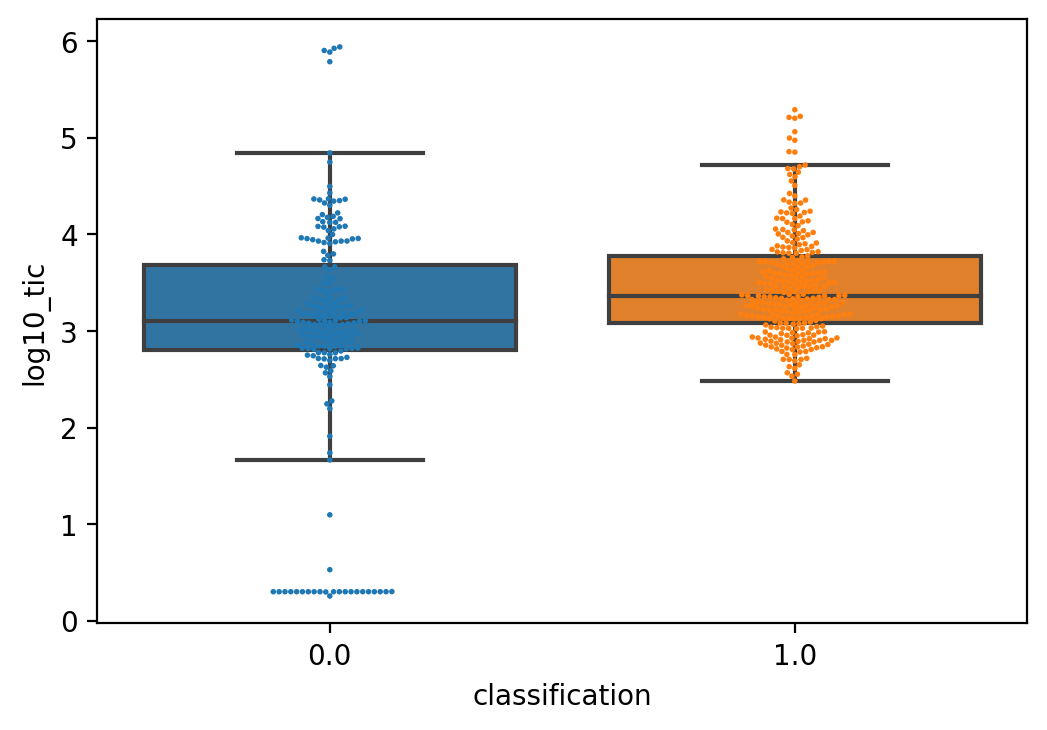

In [9]:
peakList_labeled["log10_tic"] = np.log10(peakList_labeled["tic"] + 2.0)
sb.swarmplot(data=peakList_labeled,x="classification",y="log10_tic",s=2)
sb.boxplot(data=peakList_labeled,x="classification",y="log10_tic",fliersize=0)

In [10]:
peakList

mz         rt
1       52.995260   5.082550
2       54.977009   5.083667
3       55.019199   6.030133
4       57.034543   5.399525
5       57.034540   1.583142
...           ...        ...
3928  1612.974731   6.589500
3929  1612.974770   2.198033
3930  1613.978781  15.015317
3931  1613.978738   2.198033
3932  1614.976147   2.198033

[3932 rows x 2 columns]

Epoch 1/30
186/186 [==============================] - 2s 7ms/step - loss: 0.3954 - mean_absolute_error: 0.2075 - val_loss: 0.6883 - val_mean_absolute_error: 0.3161
Epoch 2/30
186/186 [==============================] - 1s 5ms/step - loss: 0.1736 - mean_absolute_error: 0.0592 - val_loss: 0.9078 - val_mean_absolute_error: 0.3044
Epoch 3/30
186/186 [==============================] - 1s 5ms/step - loss: 0.1078 - mean_absolute_error: 0.0358 - val_loss: 1.1174 - val_mean_absolute_error: 0.3019
Epoch 4/30
186/186 [==============================] - 1s 5ms/step - loss: 0.0809 - mean_absolute_error: 0.0278 - val_loss: 1.2683 - val_mean_absolute_error: 0.3013
Epoch 4: early stopping
366/366 [==============================] - 1s 2ms/step


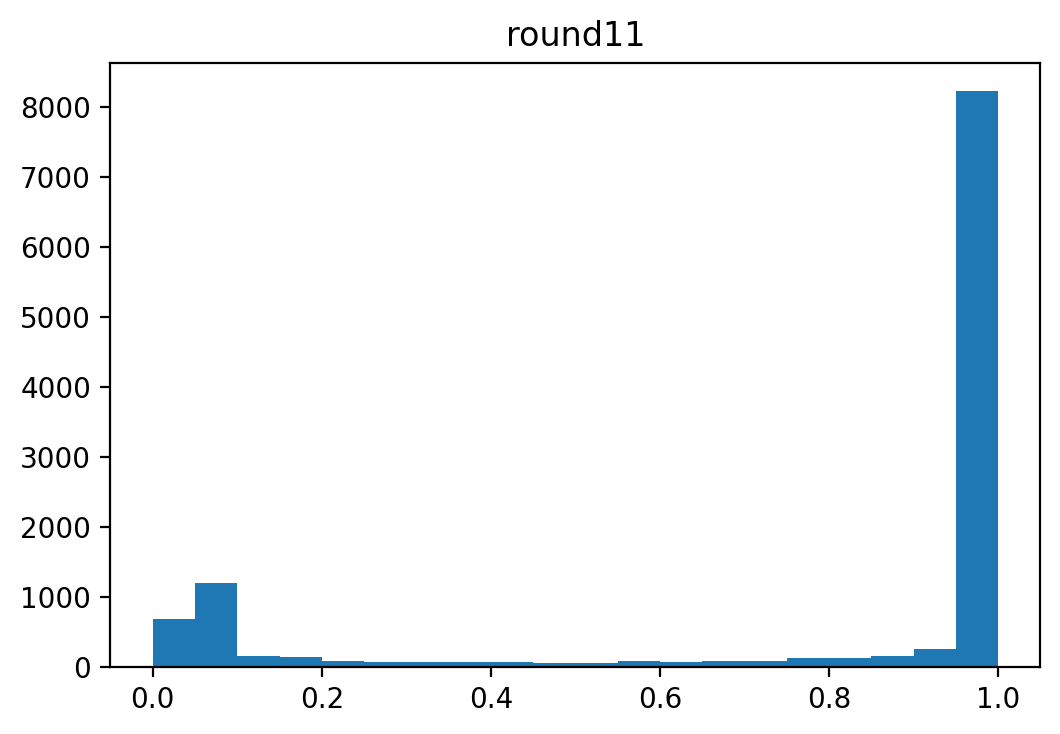

11686 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


369/369 [==============================] - 1s 2ms/step
done
formatting output...

In [39]:
# format X
if __name__ == "__main__":
    ms1_peaks_curated,X_norm,X_orig,tics,scores,progress,peak_scores,performance = integ.curatePeaks(raw_data,peakList,
                                                                                min_peaks=50000,shift=7.0,
                                                                                smooth_epochs=20,class_epochs=30,
                                                                                threshold=0.5,useSynthetic=True,
                                                                                numManualPerRound=10,validation_split=0.1,
                                                                                autoClassify = False,noise=0)

In [40]:
ms1_peaks_curated

{'../data/covid_plasma/B1_NIST1950_1_6540.mzML':                mz         rt
 1       52.995260   5.082550
 2       54.977009   5.083667
 3       55.019199   6.030133
 4       57.034543   5.399525
 5       57.034540   1.583142
 ...           ...        ...
 3912  1144.635590  13.056317
 3914  1175.773152   0.919300
 3915  1176.777577   0.917967
 3918  1419.984310   0.488400
 3932  1614.976147   2.198033
 
 [3091 rows x 2 columns],
 '../data/covid_plasma/B1_NIST1950_2_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199   6.030133
 4       57.034543   5.399525
 5       57.034540   1.583142
 6       56.995904  13.078800
 ...           ...        ...
 3923  1612.976393  14.998683
 3929  1612.974770   2.198033
 3930  1613.978781  15.015317
 3931  1613.978738   2.198033
 3932  1614.976147   2.198033
 
 [3067 rows x 2 columns],
 '../data/covid_plasma/B1_NIST1950_3_6540.mzML':                mz         rt
 2       54.977009   5.083667
 3       55.019199  

[11796, 11786, 11776, 11766, 11756, 11746, 11736, 11726, 11716, 11706, 11696]


Text(0, 0.5, 'log10(# of uncertain peaks)')

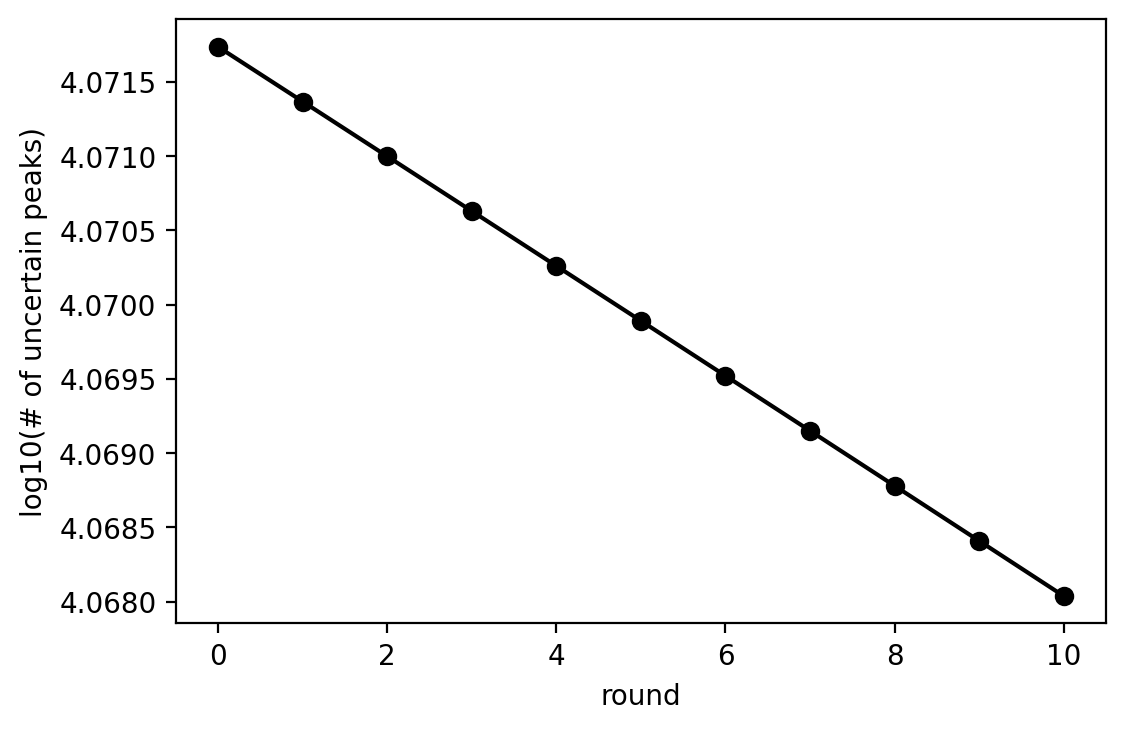

In [41]:
print(progress)
plt.plot(list(range(len(progress))),np.log10(progress),color="black")
plt.scatter(list(range(len(progress))),np.log10(progress),color="black")
plt.xlabel("round")
plt.ylabel("log10(# of uncertain peaks)")

Text(0, 0.5, 'validation mean absolute error')

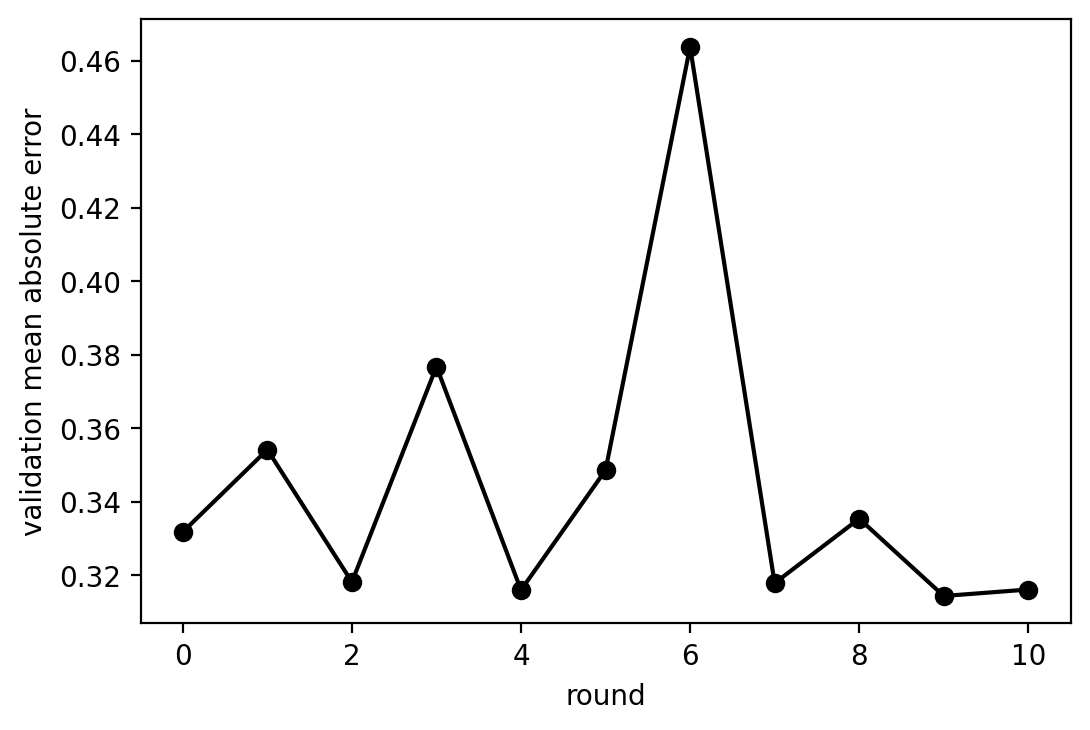

In [42]:
print()
plt.plot(list(range(len(performance))),performance,color="black")
plt.scatter(list(range(len(performance))),performance,color="black")
plt.xlabel("round")
plt.ylabel("validation mean absolute error")

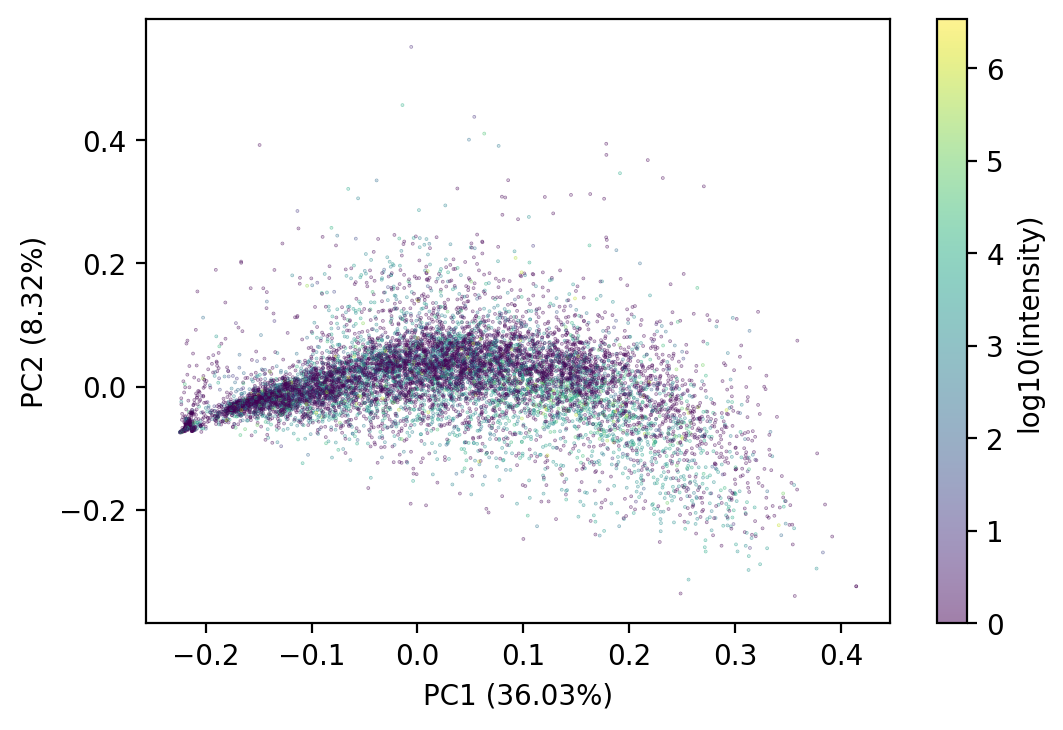

In [43]:
pca = PCA(2)
loads = pca.fit_transform(X_orig)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

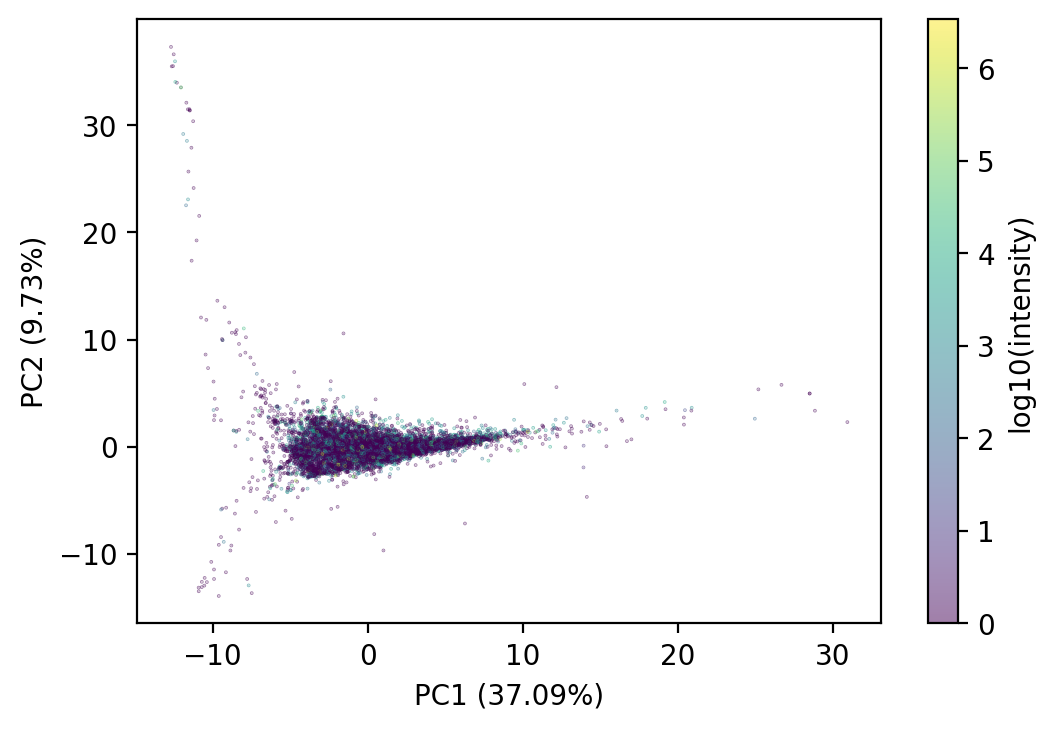

In [44]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
plt.scatter(loads[:,0],loads[:,1],c=tics,s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="log10(intensity)")

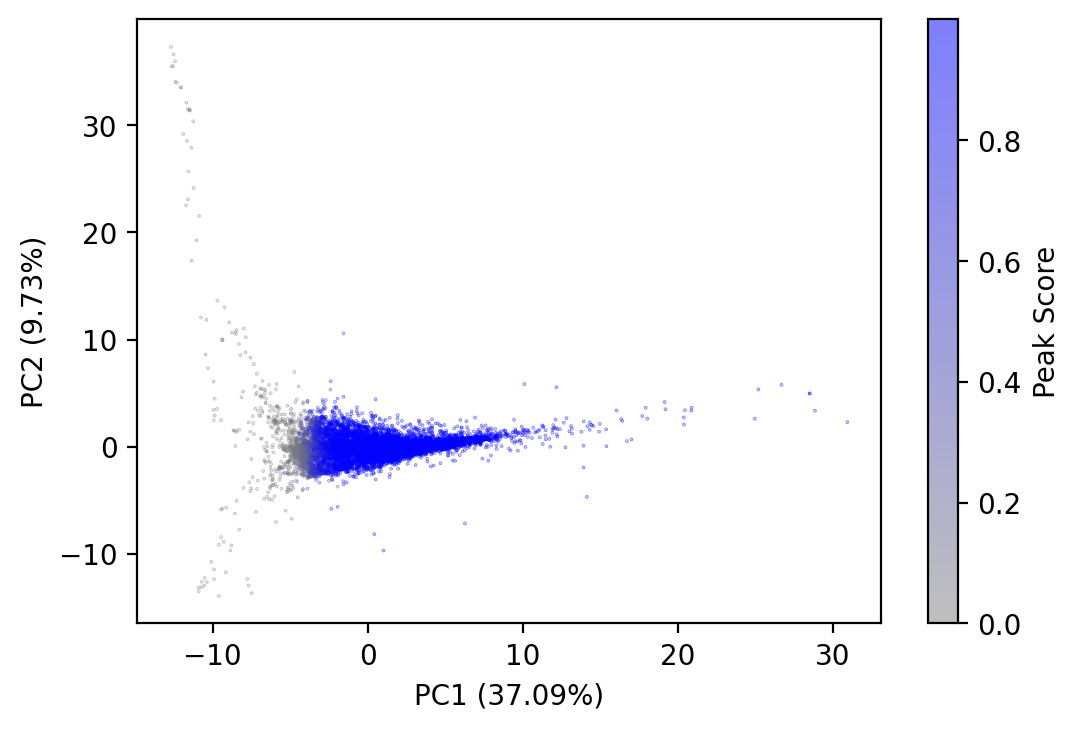

In [45]:
pca = PCA(2)
loads = pca.fit_transform(X_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=scores,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="Peak Score")

Text(0, 0.5, '% of features')

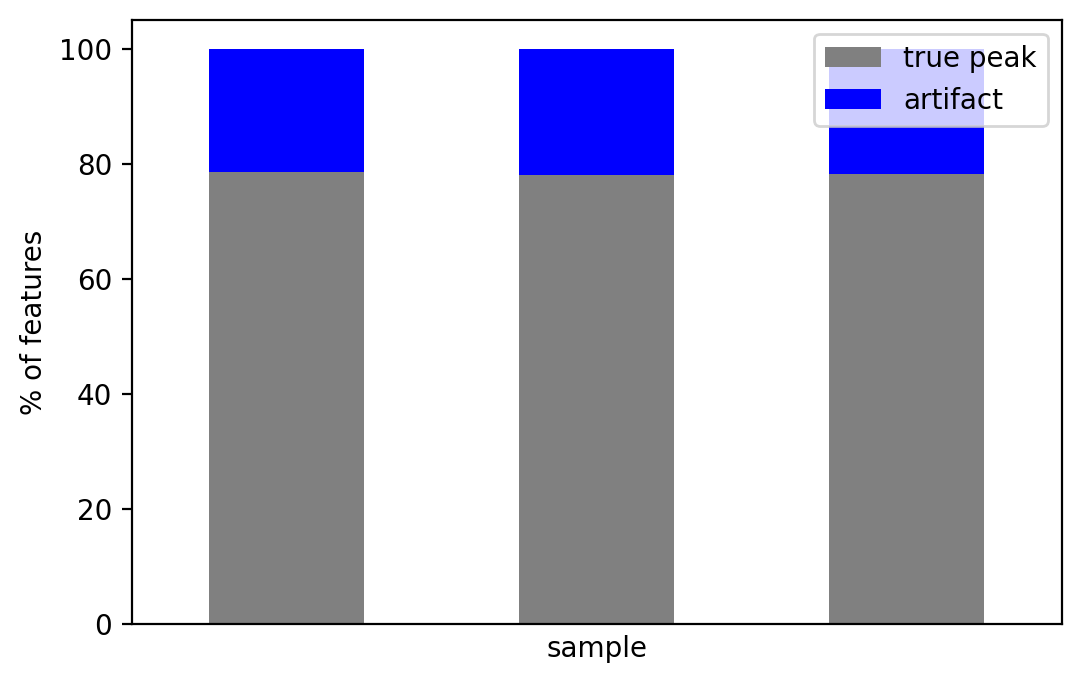

In [46]:
df = {}
for file in files:
    for index,row in peakList.iterrows():
        if index in ms1_peaks_curated[datadir + file].index.values:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


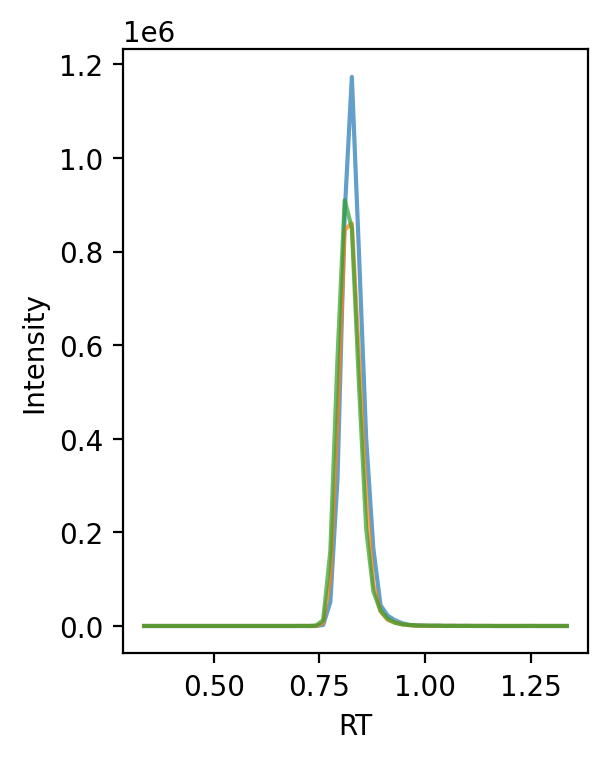

In [47]:
def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end,smoothing)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

file = datadir + files[0]
print(files)
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(3,4))
for i in inds:
    if i in ms1_peaks_curated[file].index.values:
        plot_overlayedEIC(raw_data,ms1_peaks_curated[file].at[i,"mz"],ms1_peaks_curated[file].at[i,"rt"]-.5,ms1_peaks_curated[file].at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

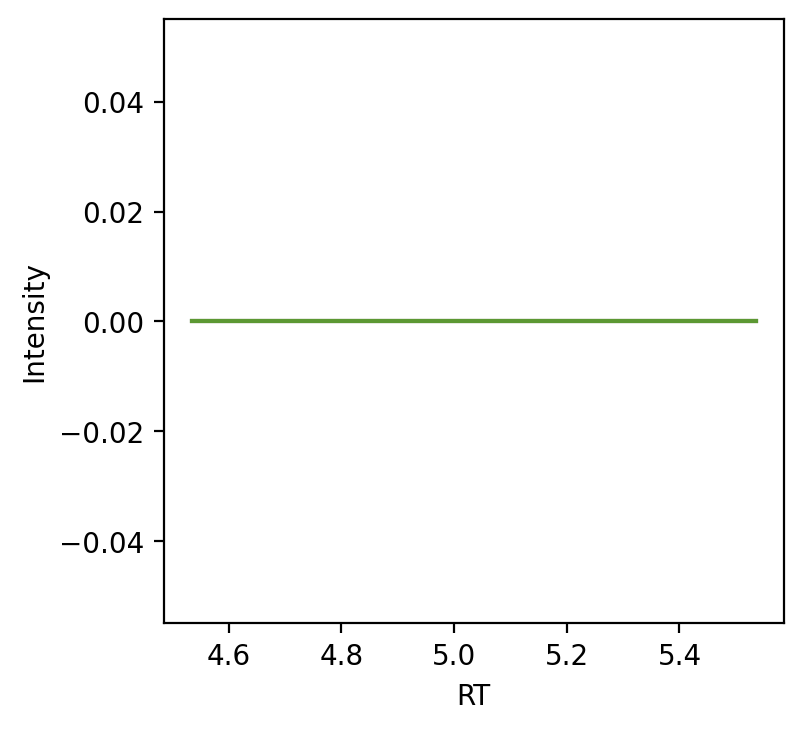

In [48]:
file = datadir + files[0]
inds = list(peakList.index.values)
rd.shuffle(inds)
plt.figure(figsize=(4,4))

for i in inds:
    if all(i not in ms1_peaks_curated[datadir + f].index.values for f in files):
        plot_overlayedEIC(raw_data,peakList.at[i,"mz"],peakList.at[i,"rt"]-.5,peakList.at[i,"rt"] + .5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break

In [49]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if index in ms1_peaks_curated[datadir + file].index.values:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)



array([[102, 102],
       [  4, 292]], dtype=int64)

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


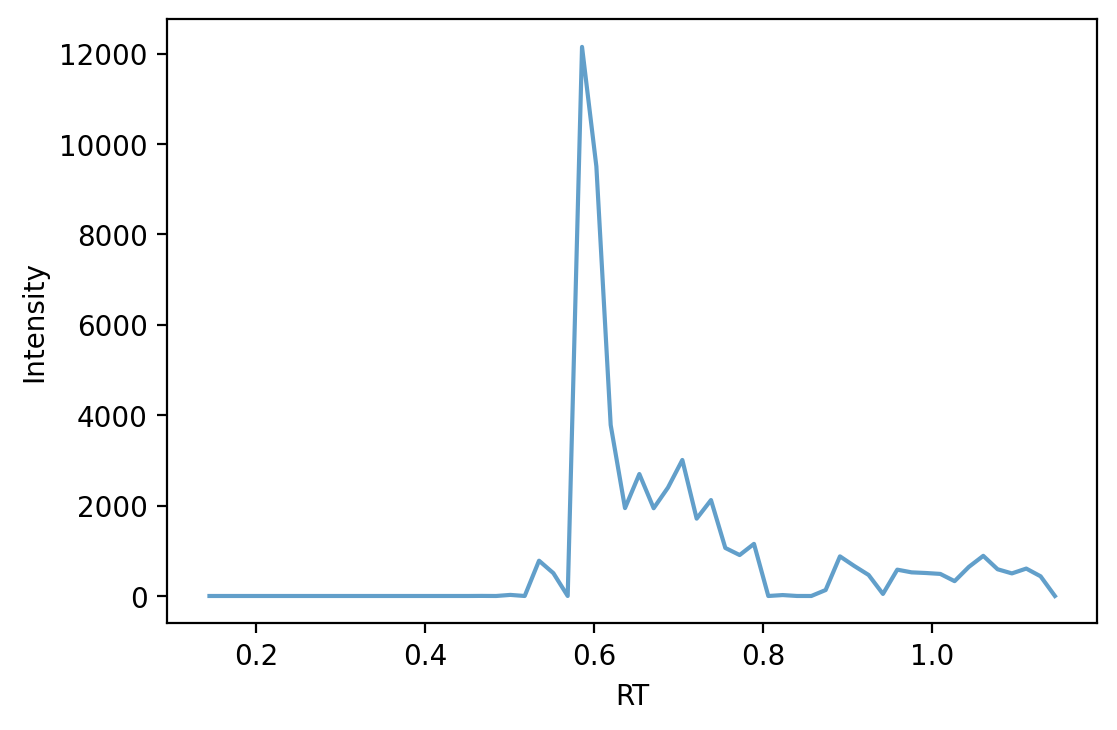

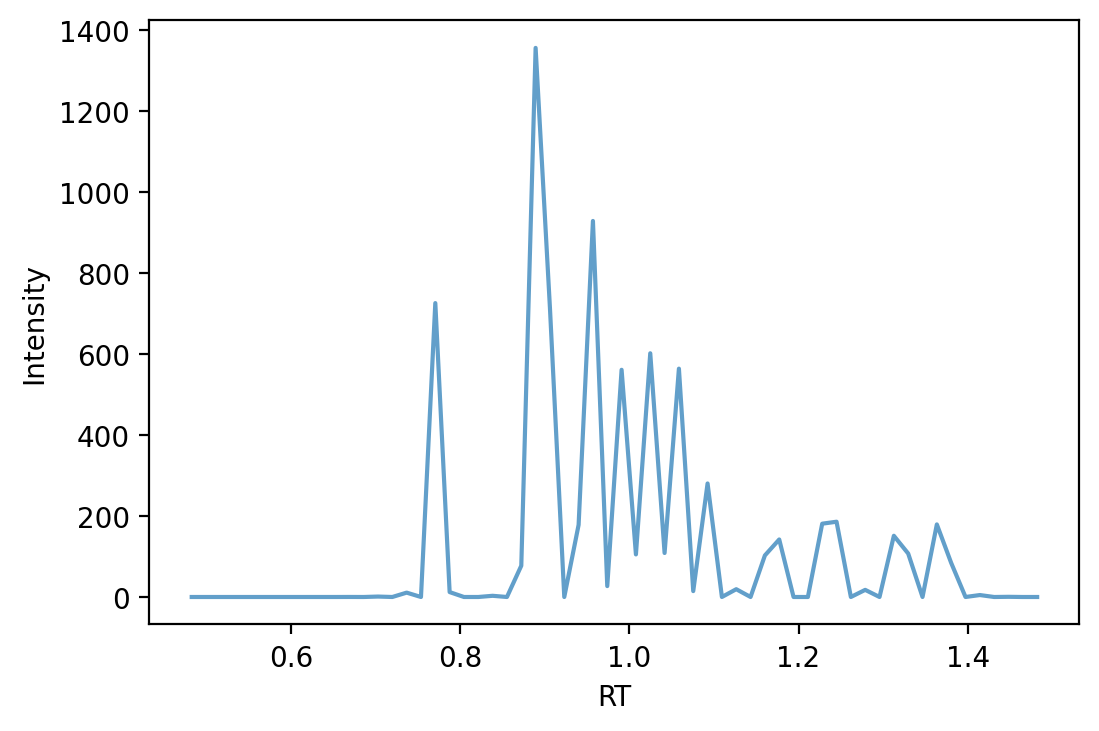

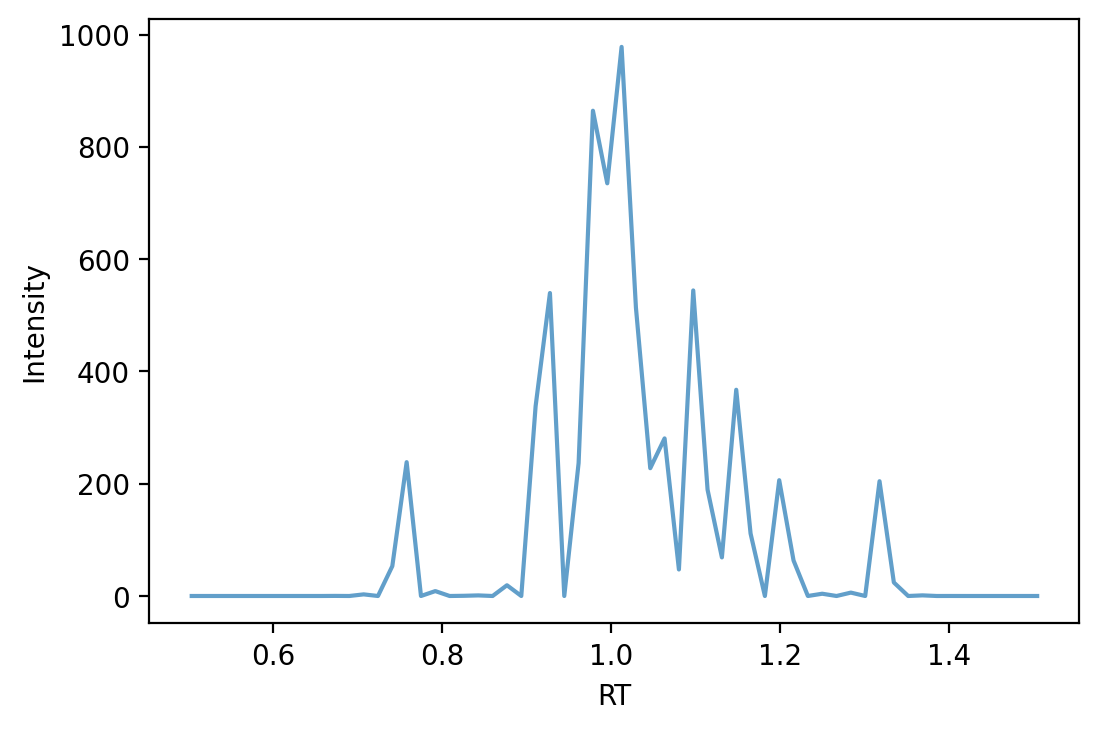

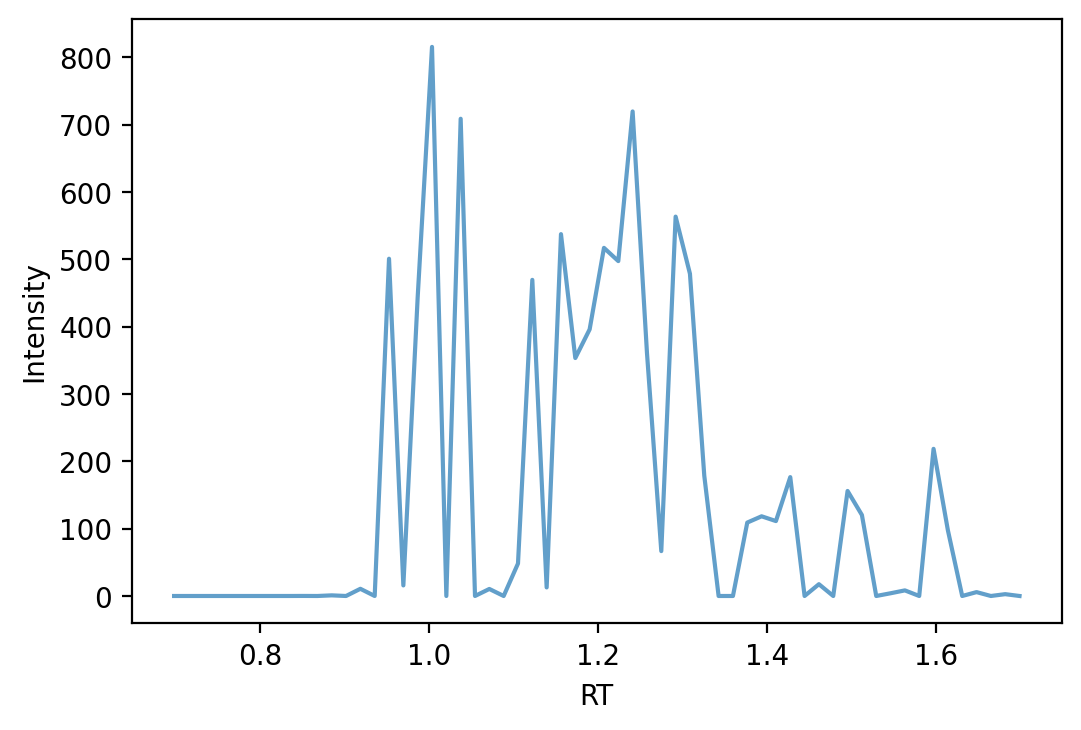

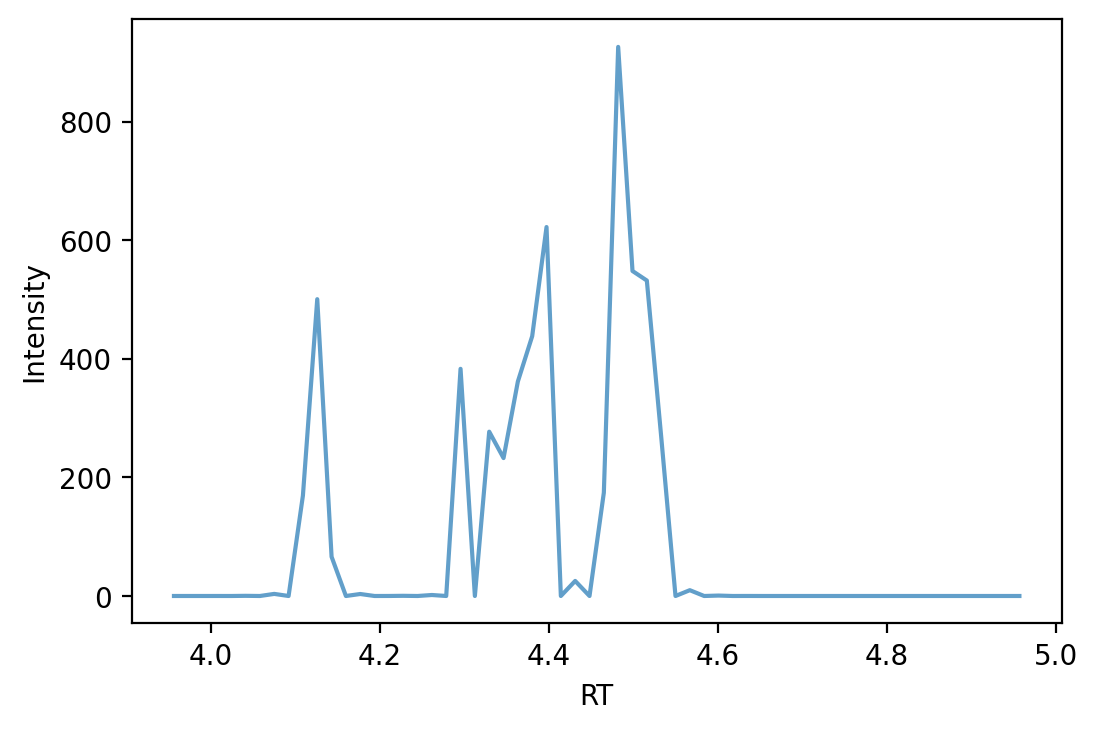

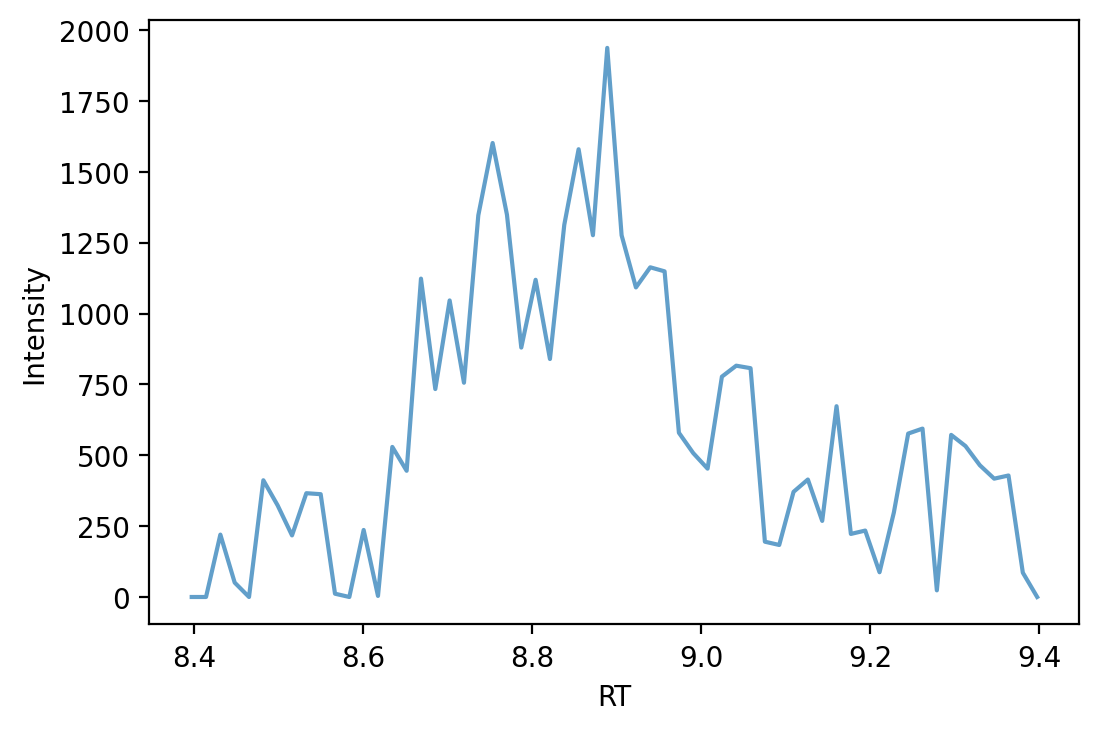

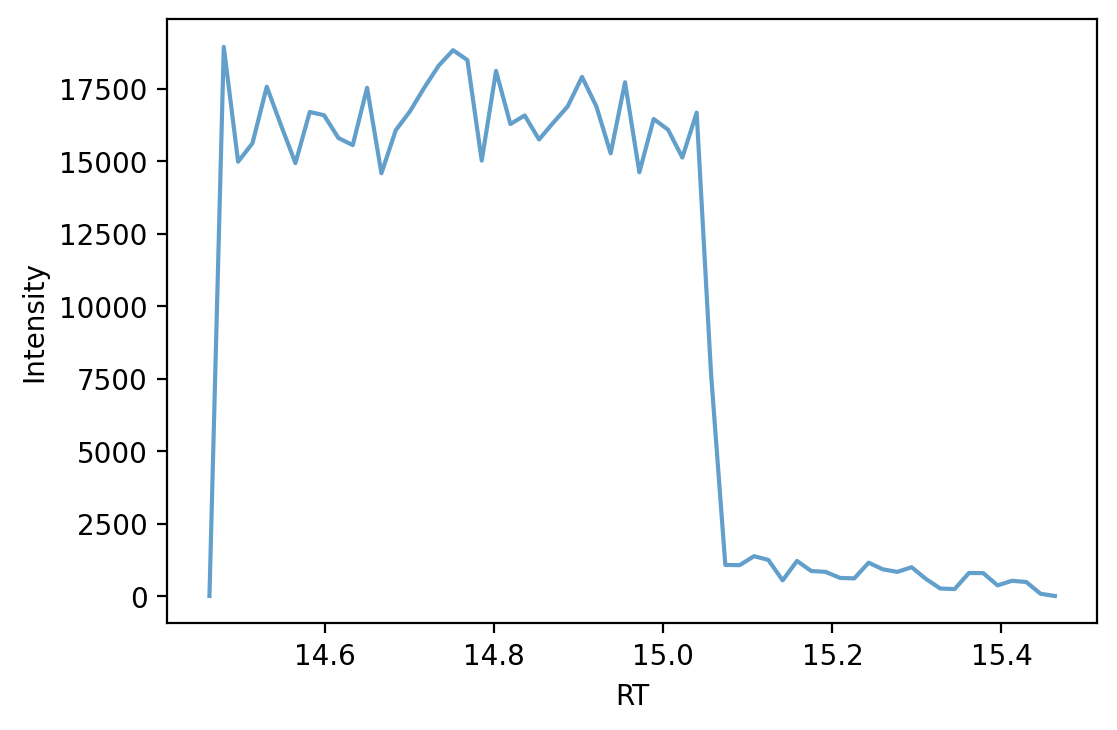

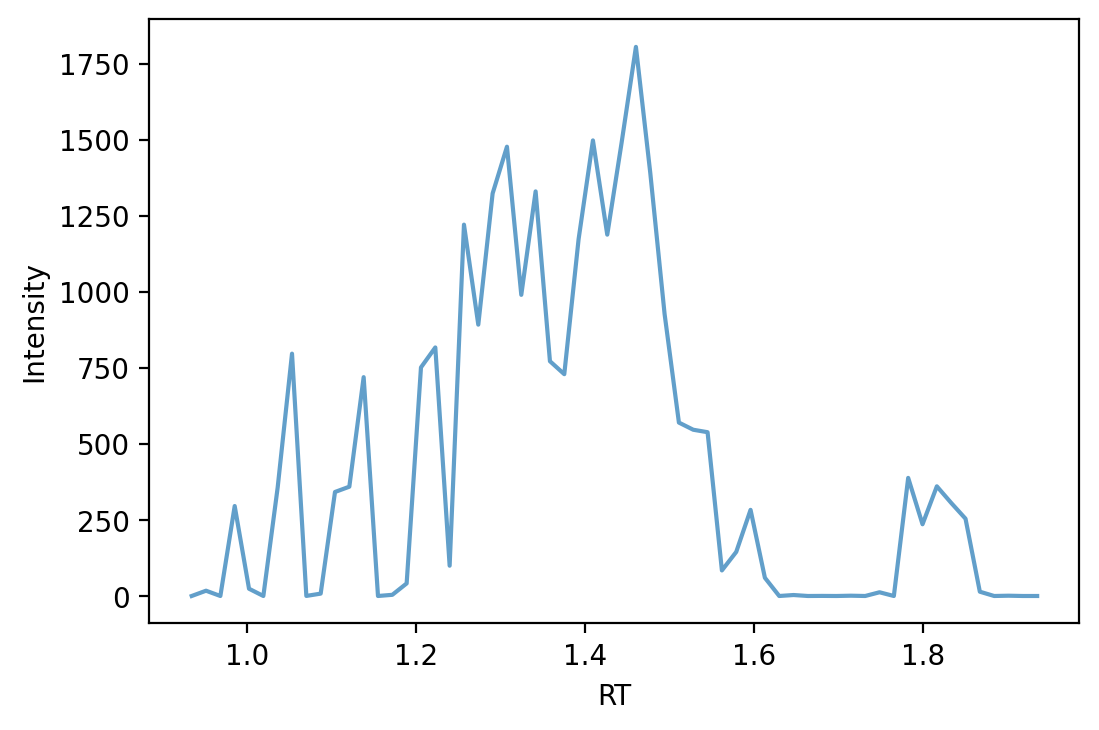

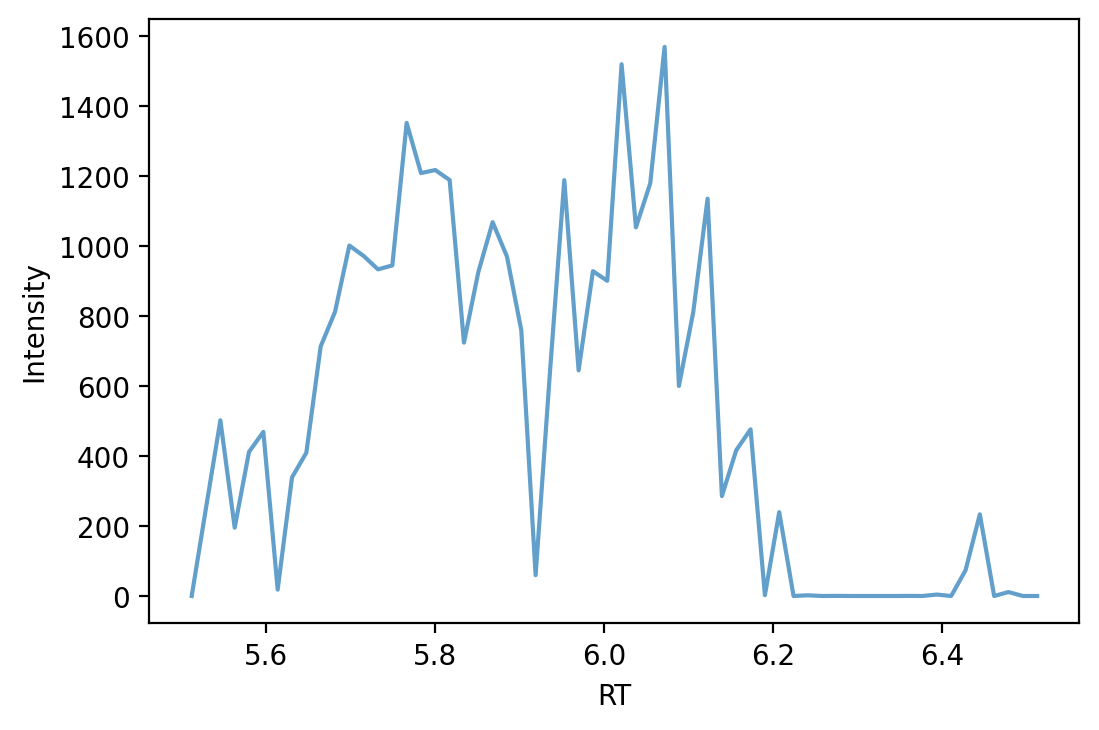

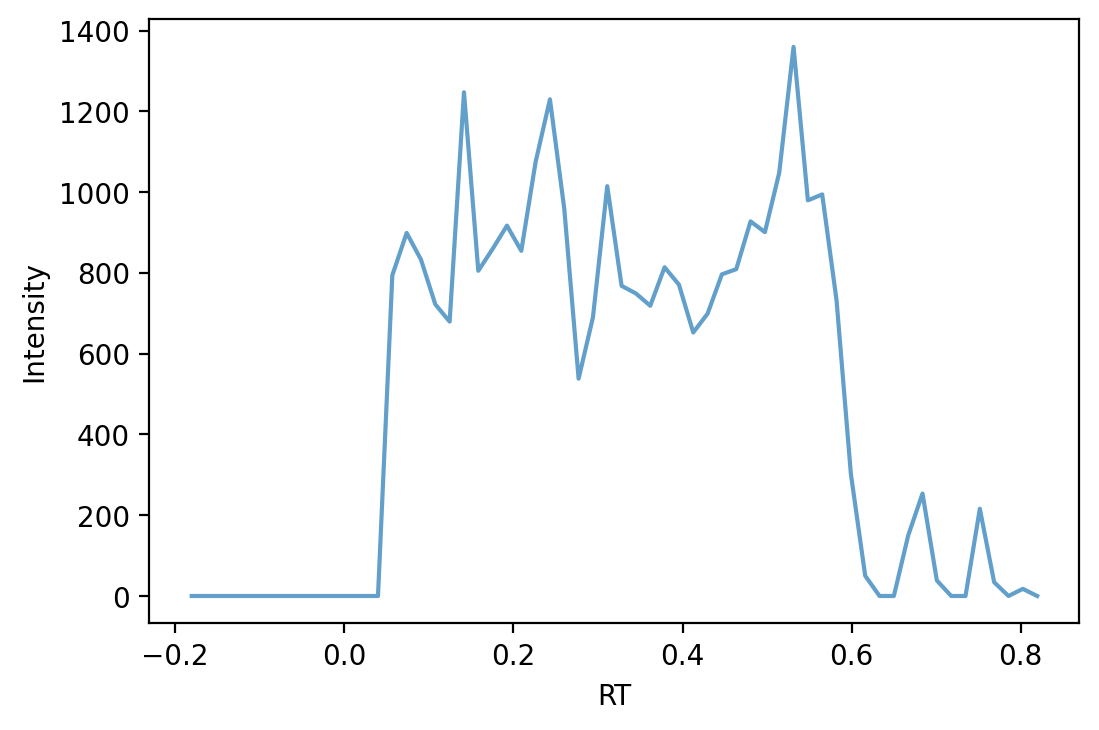

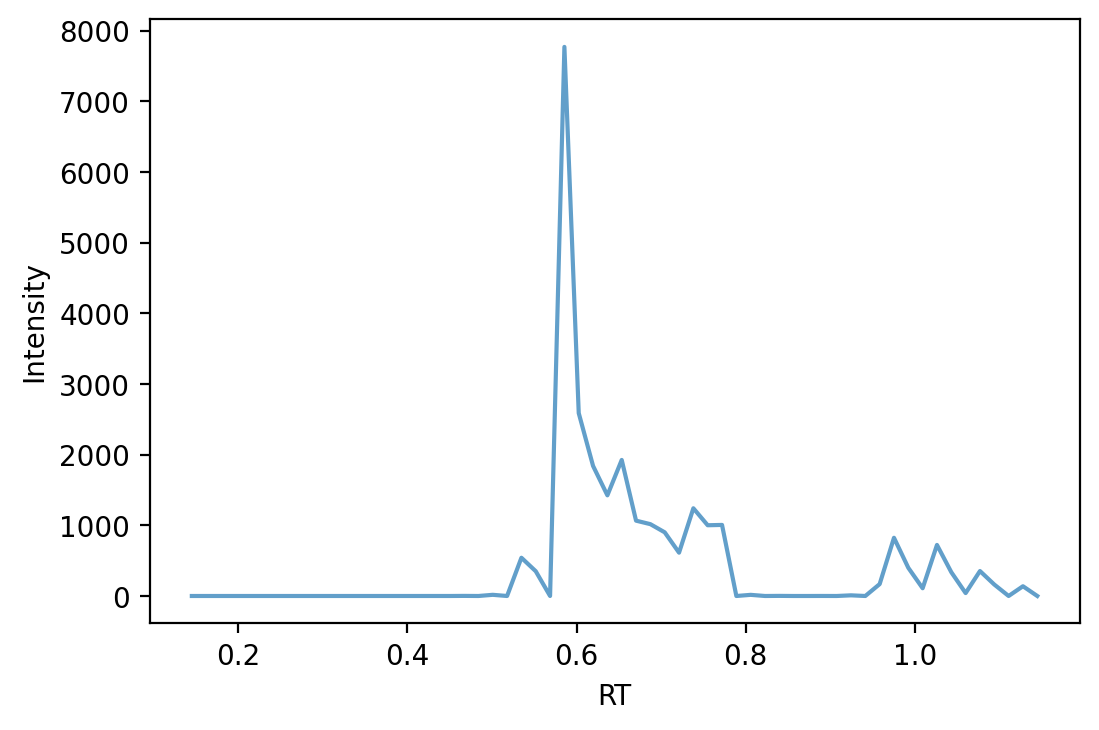

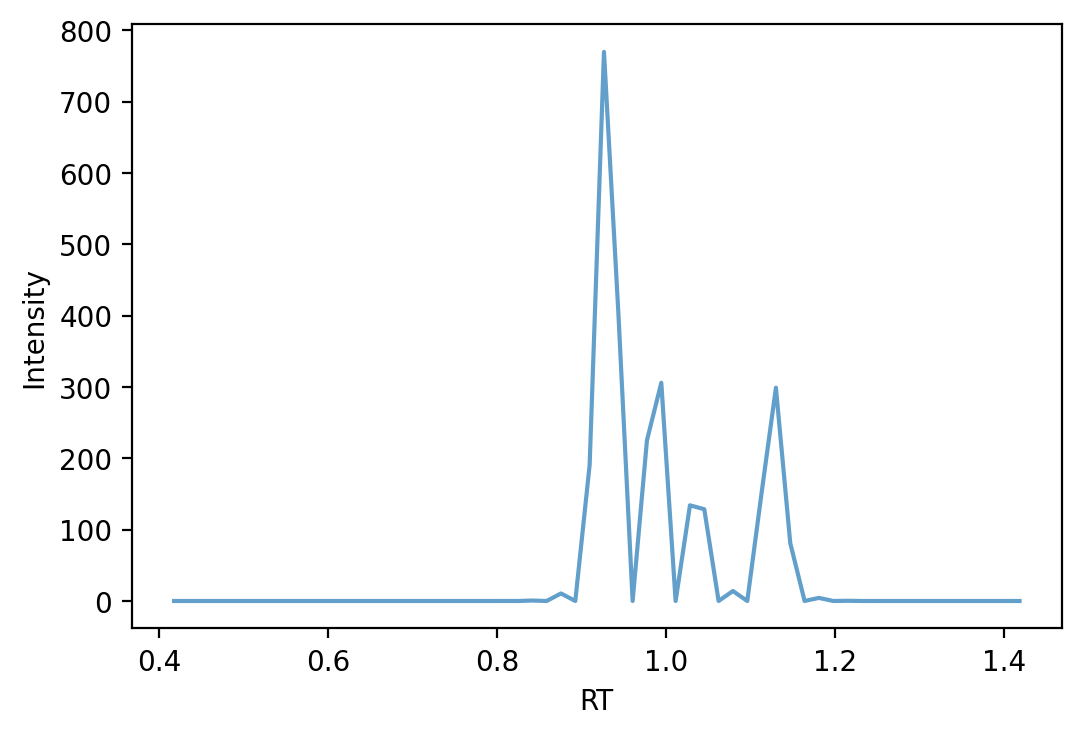

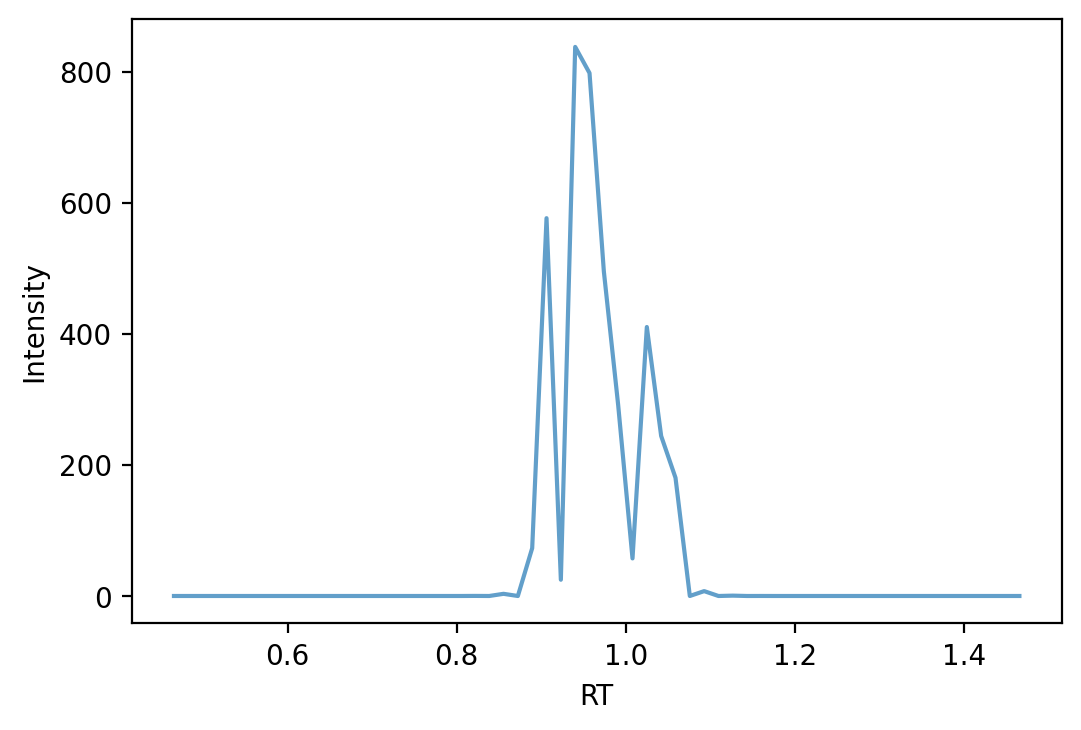

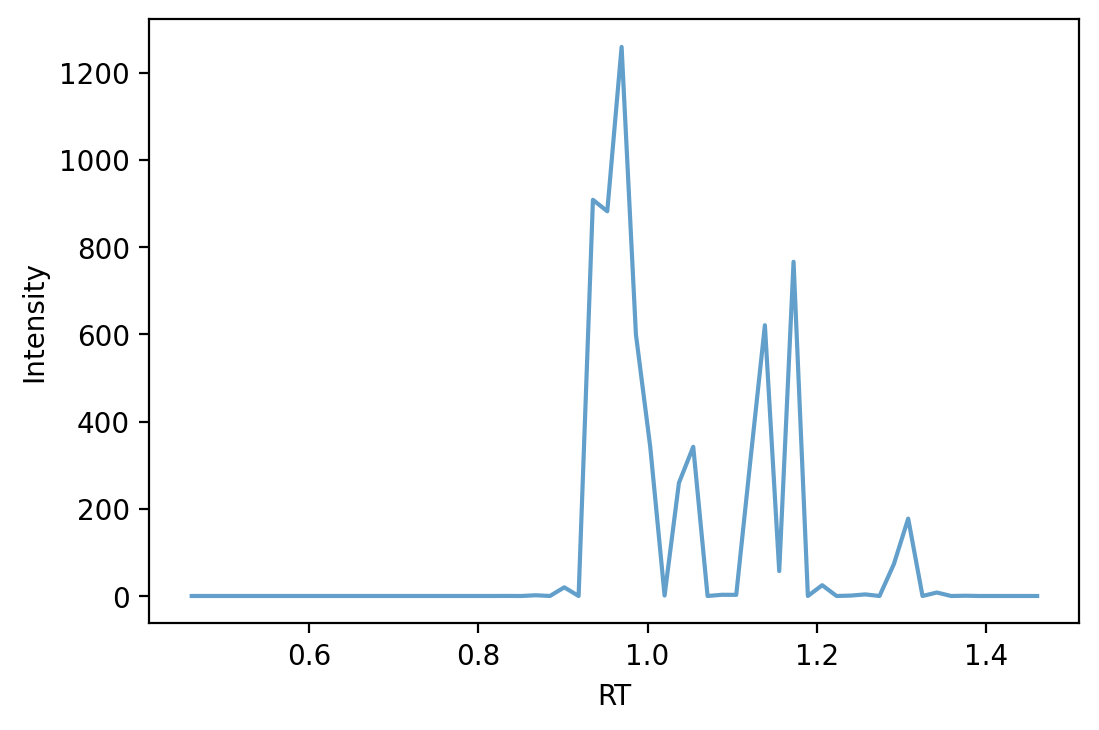

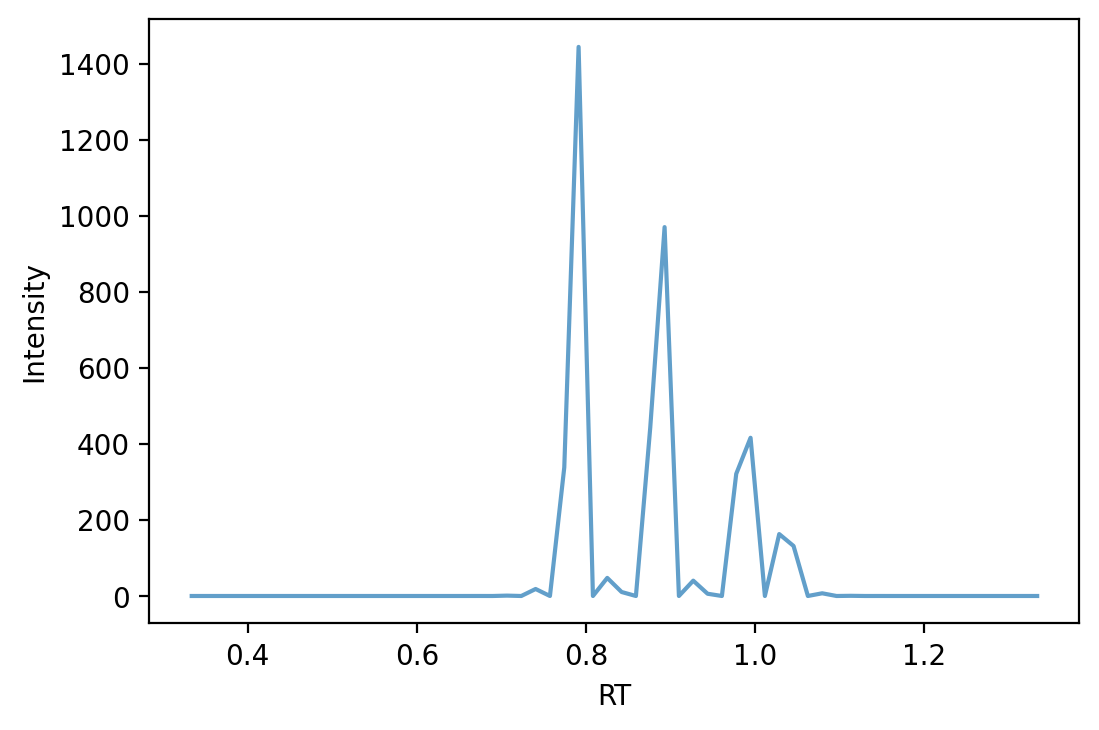

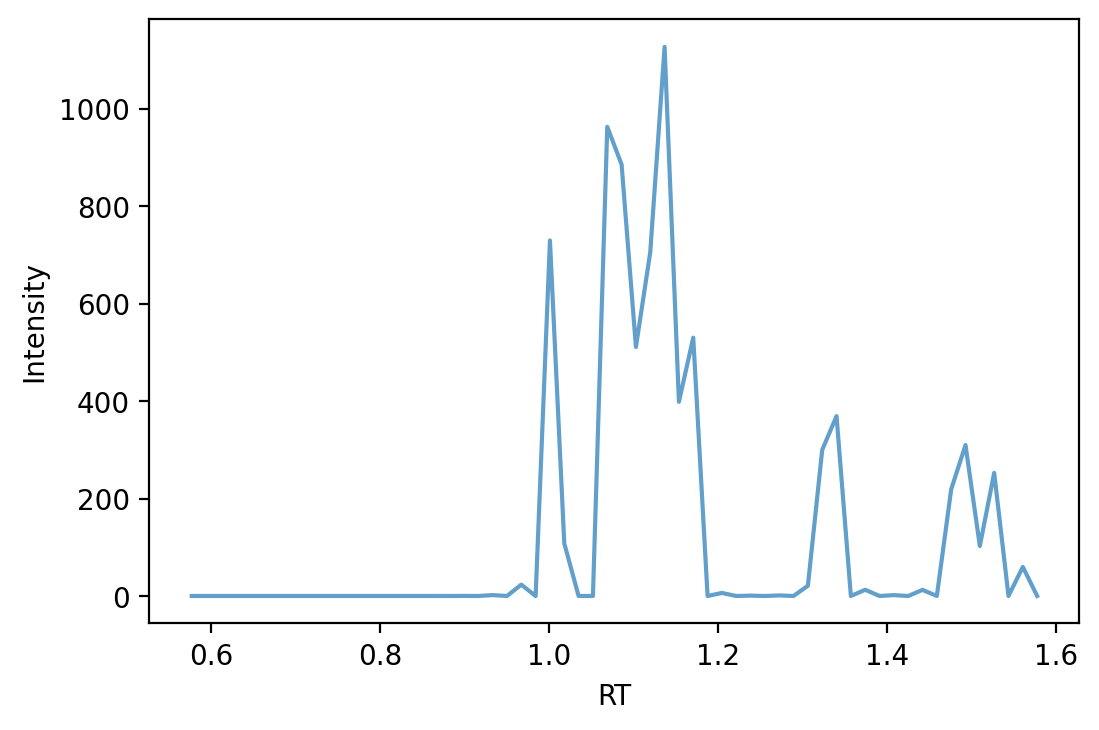

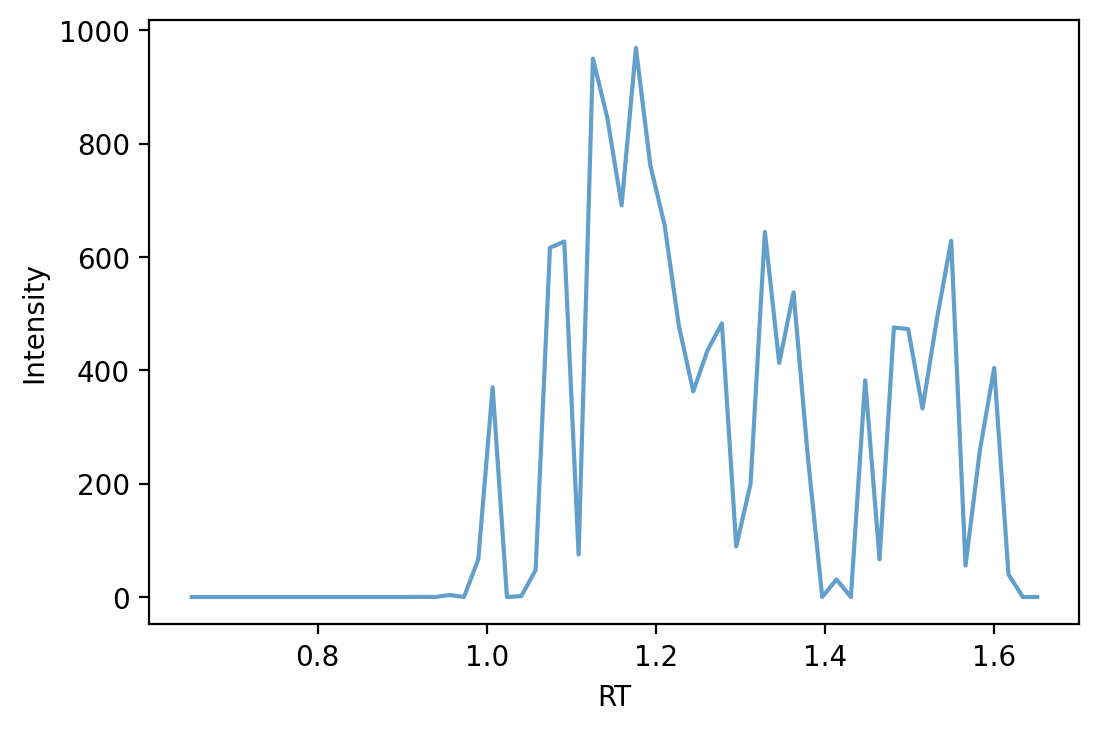

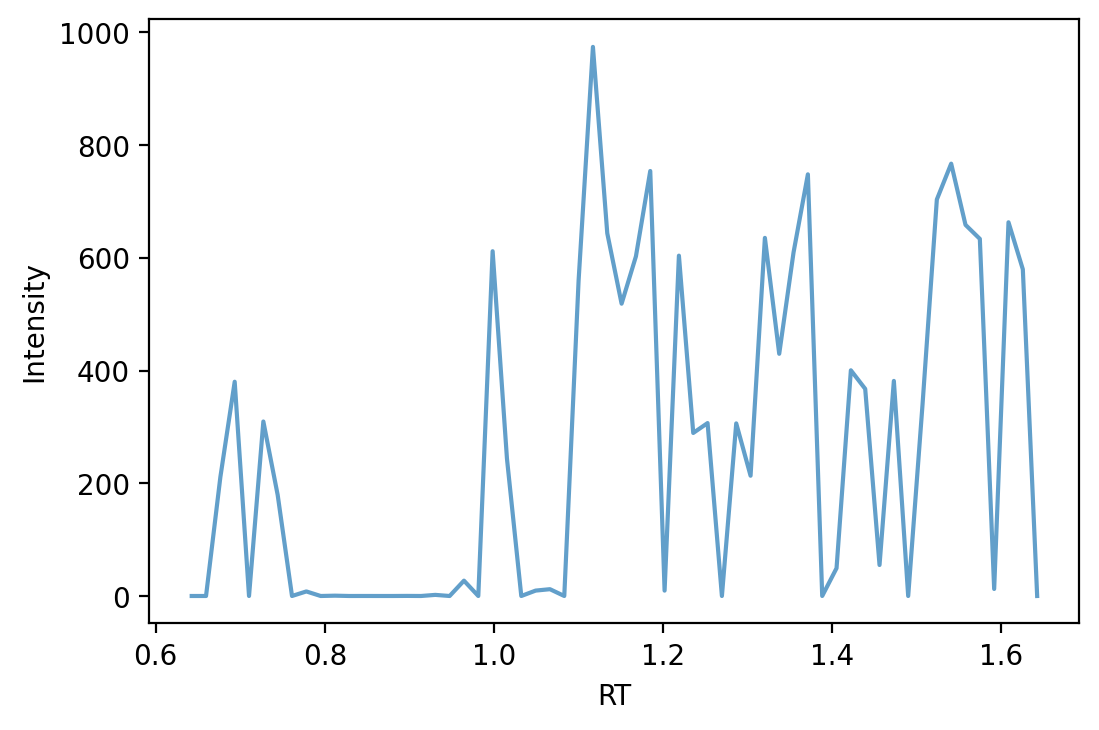

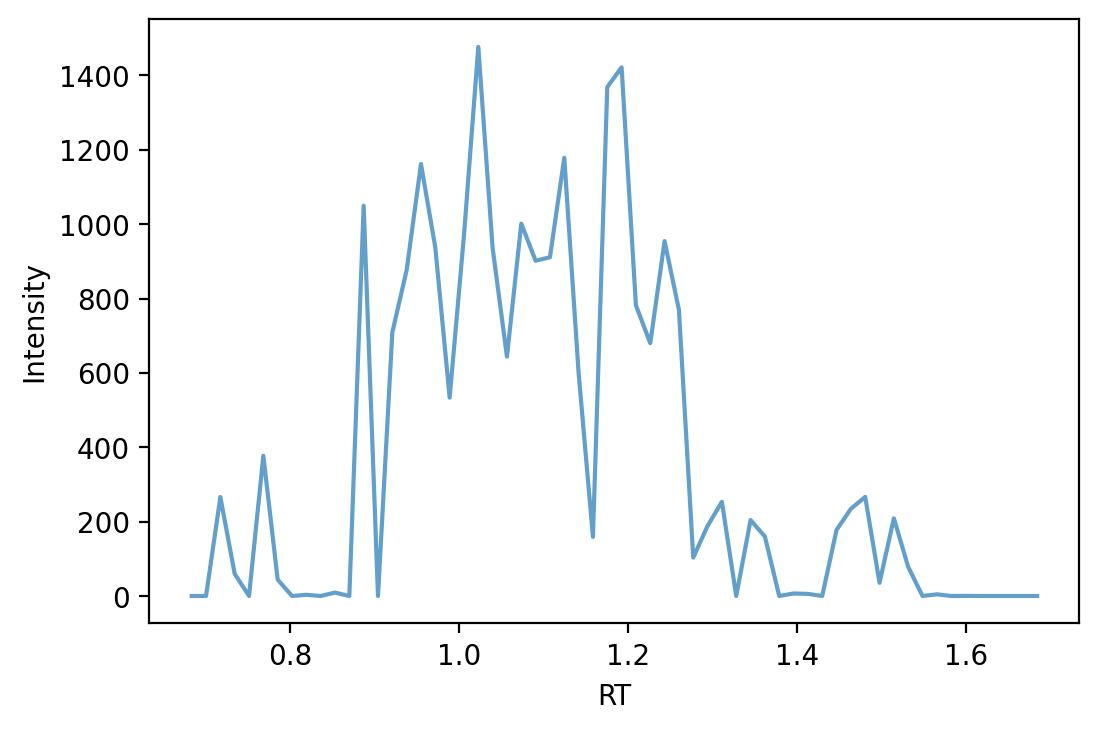

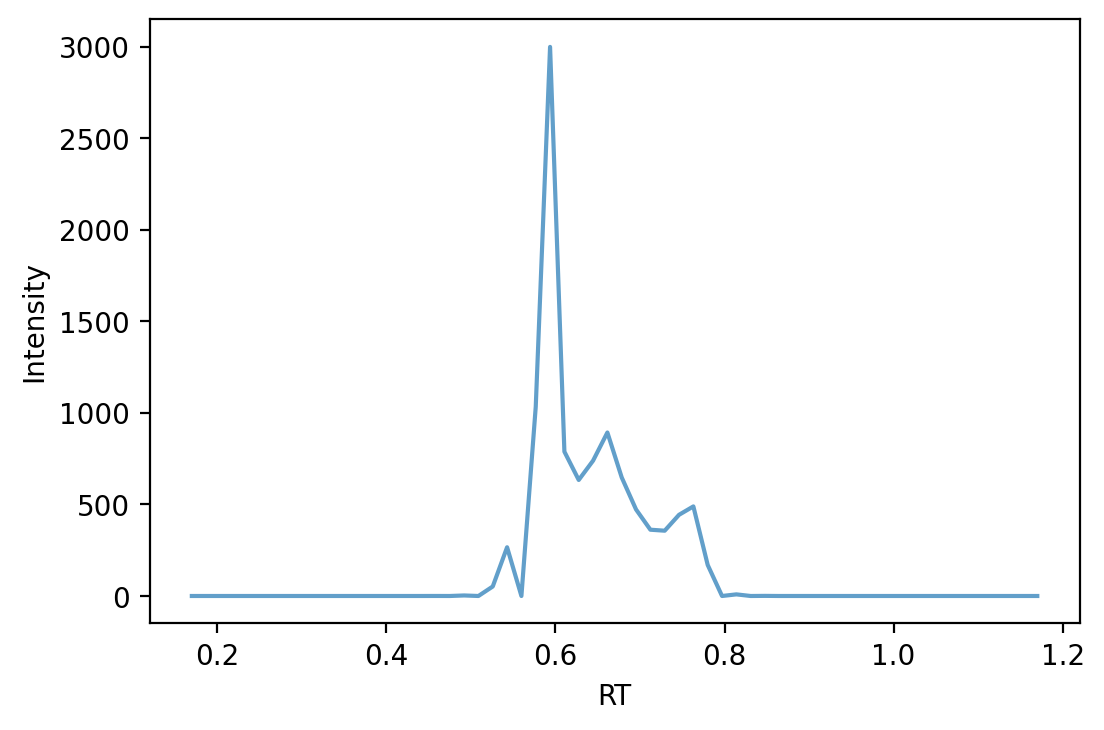

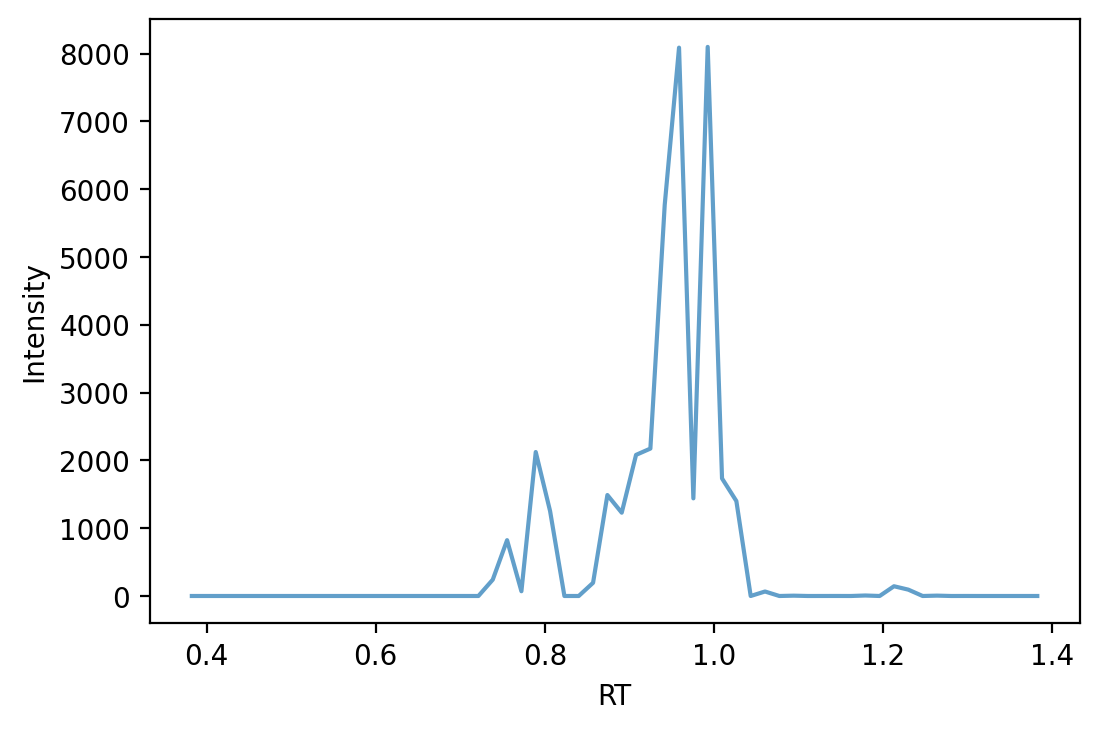

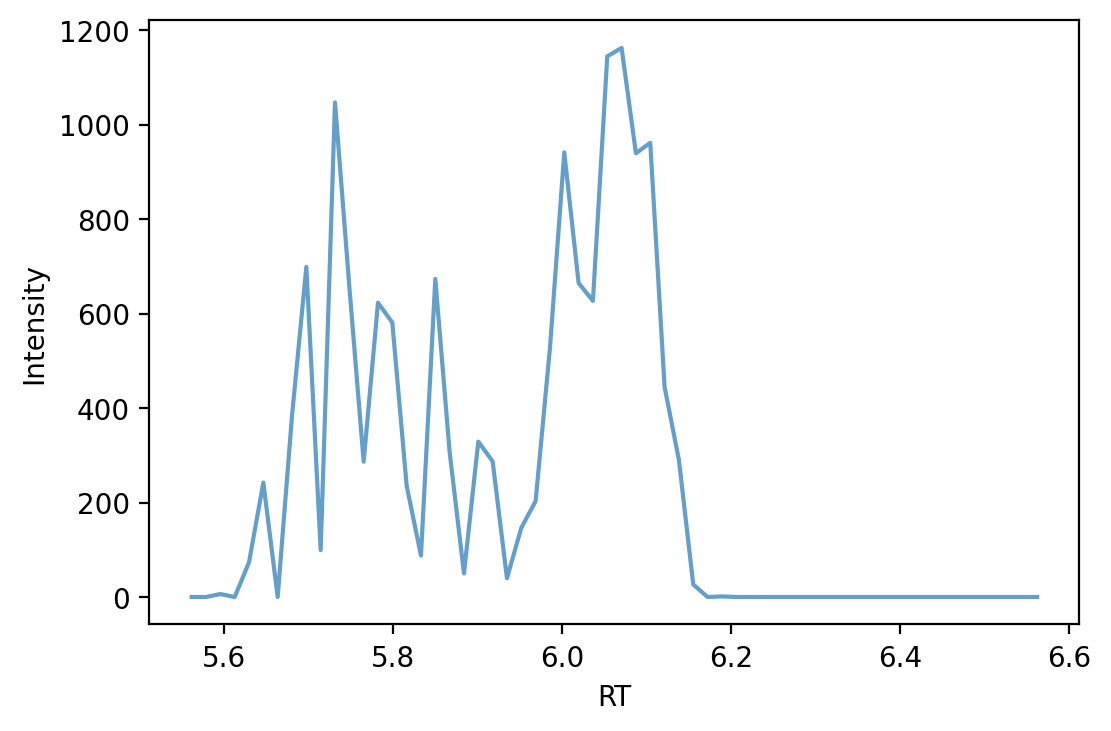

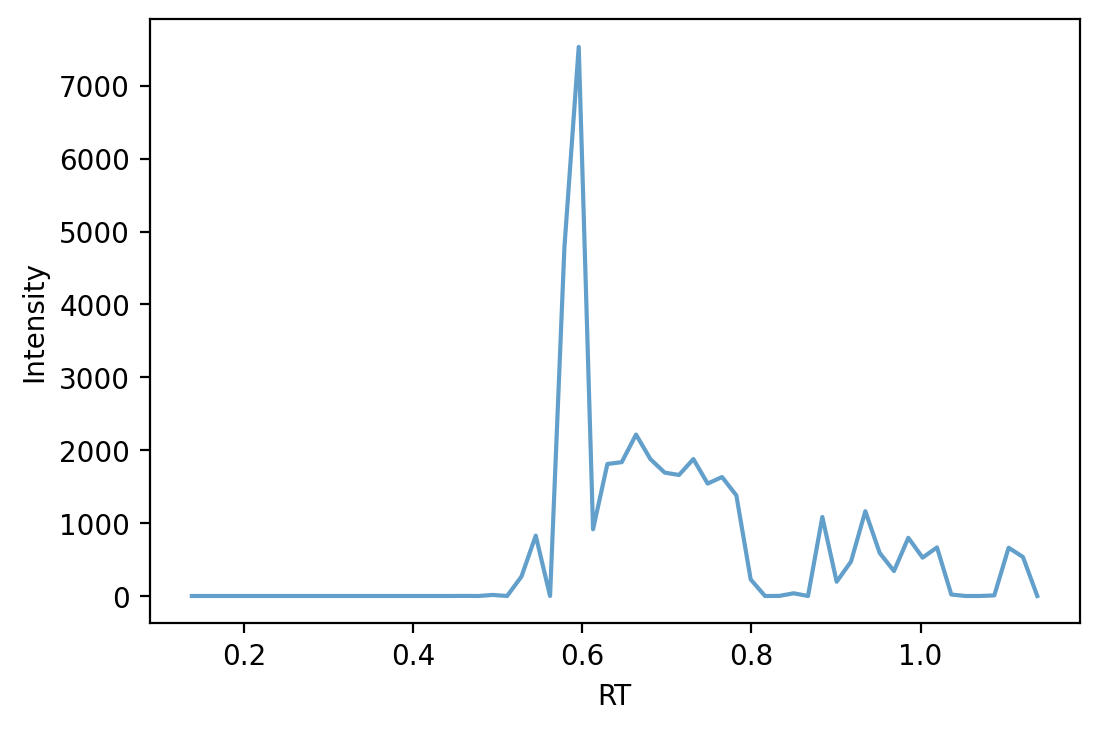

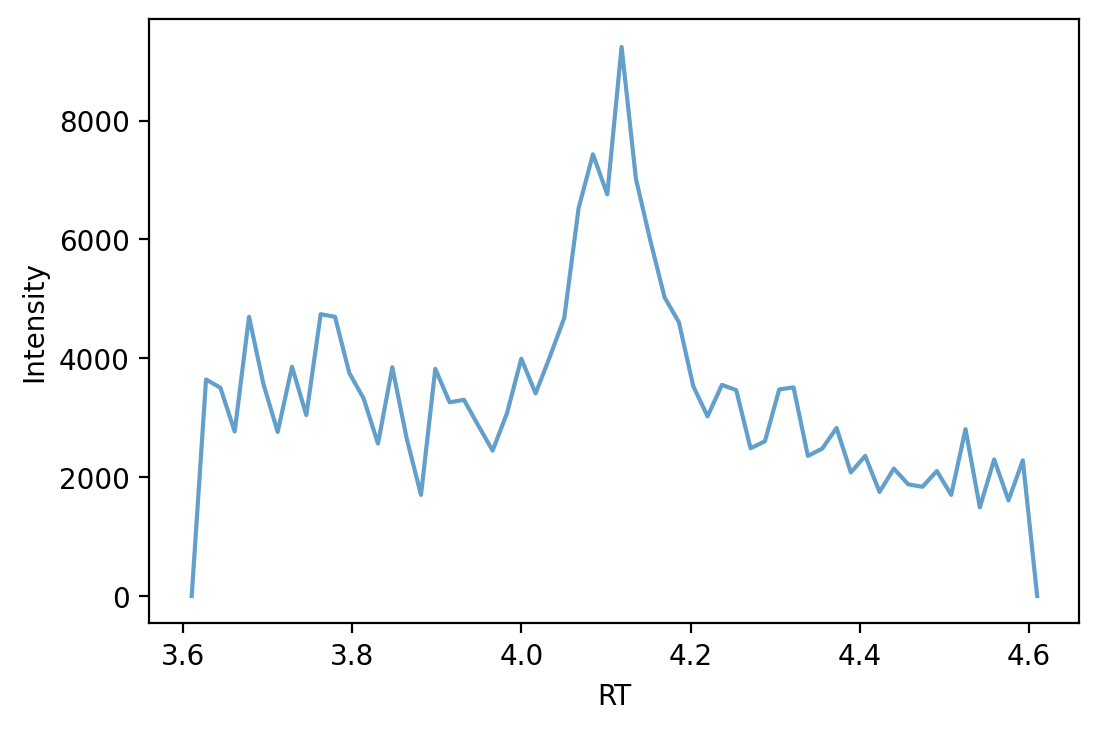

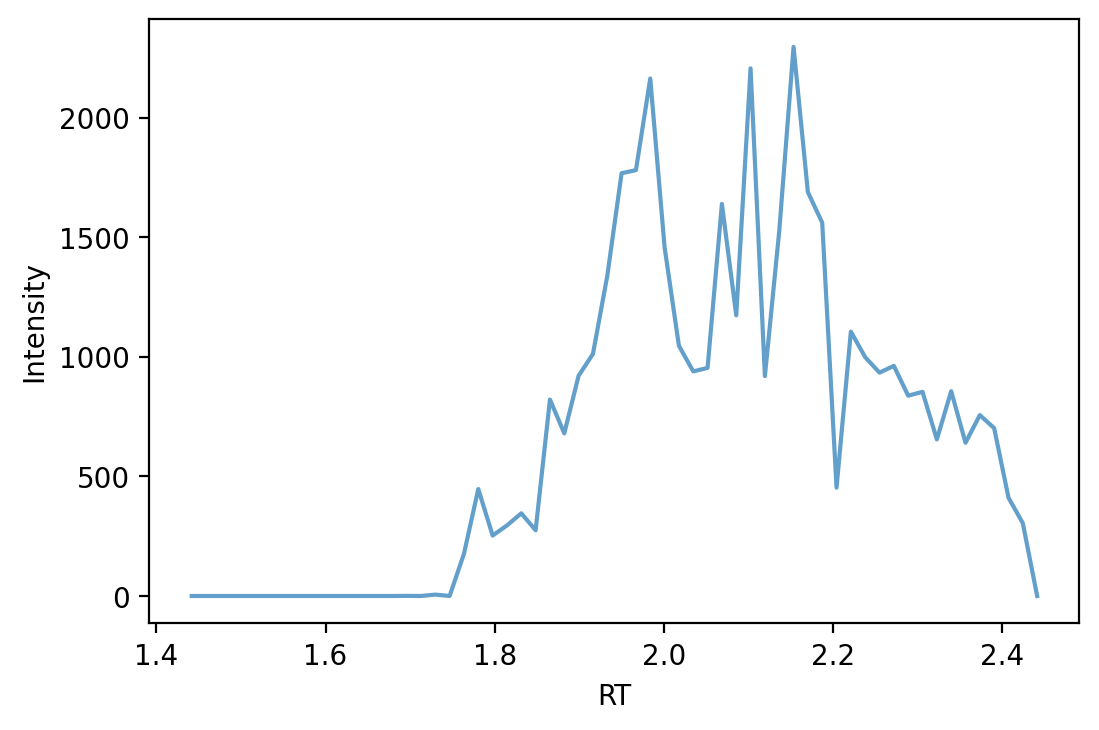

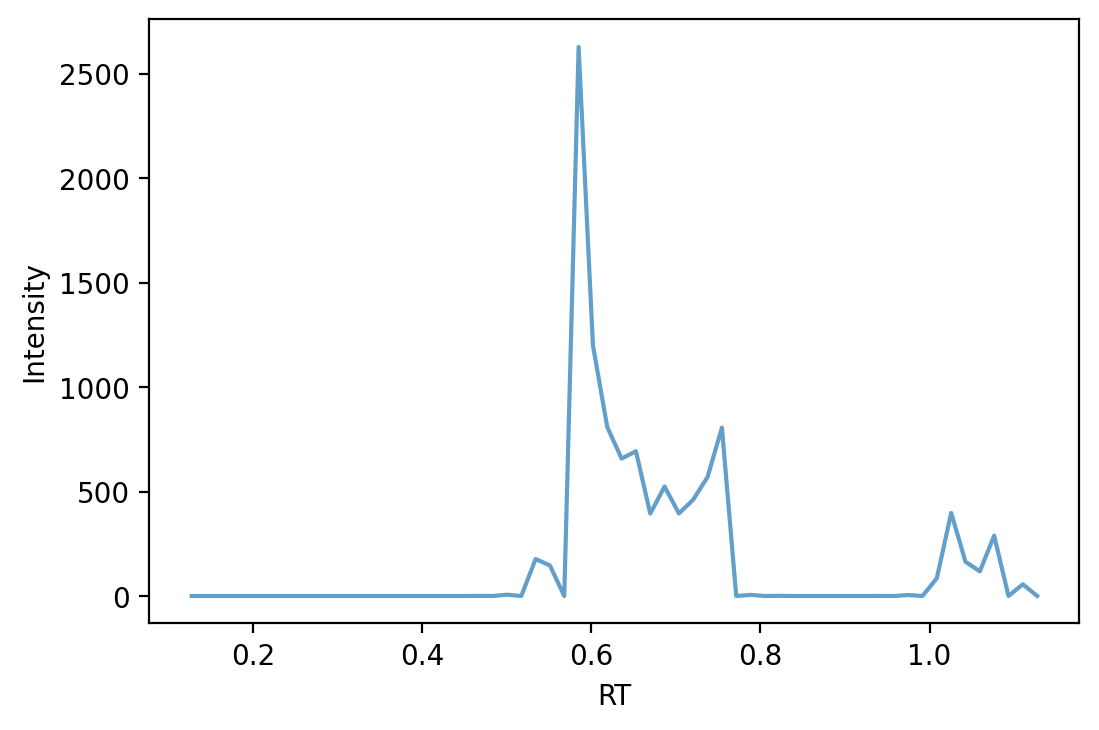

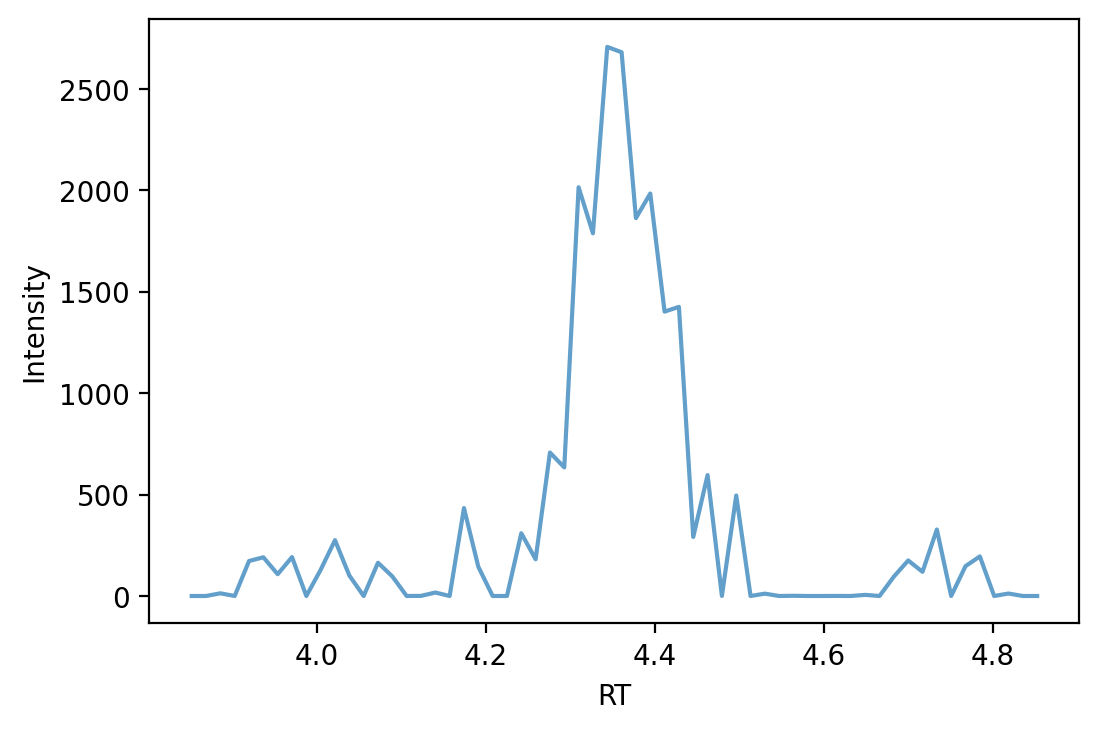

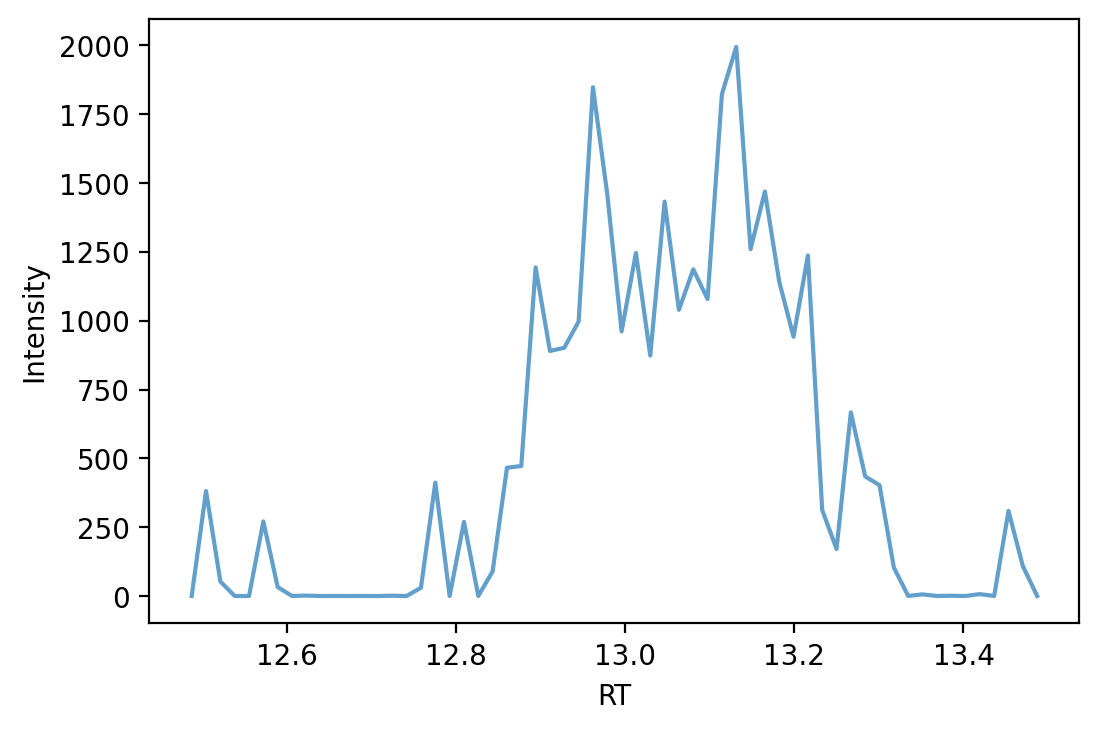

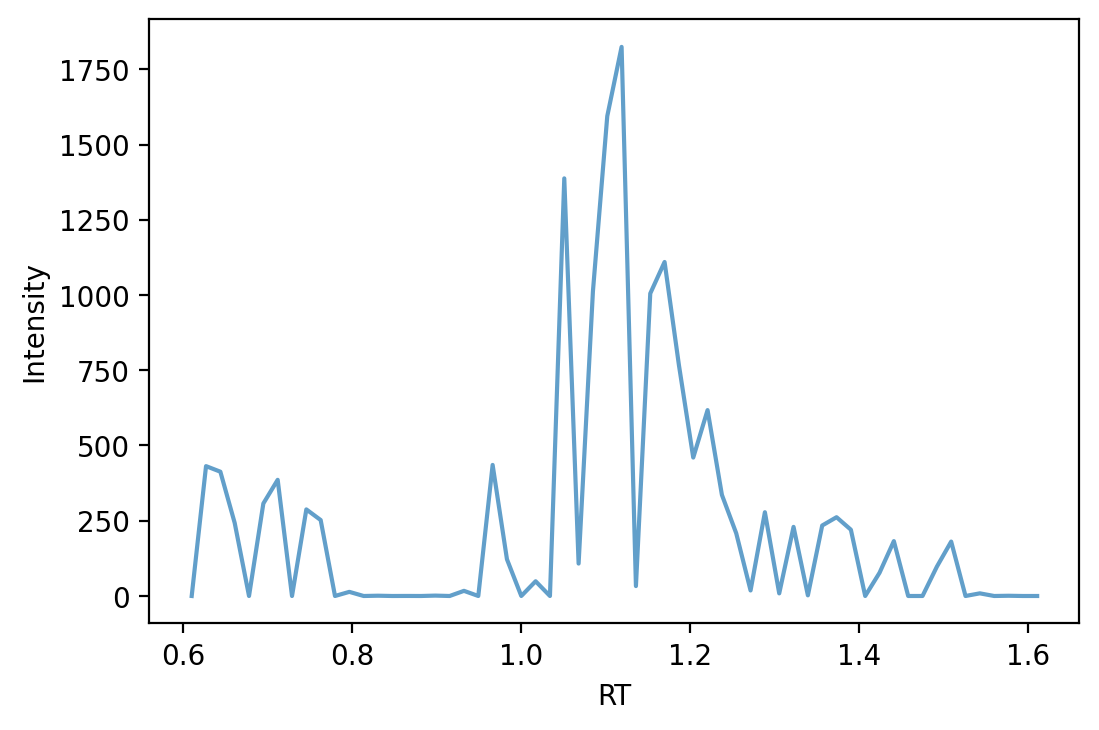

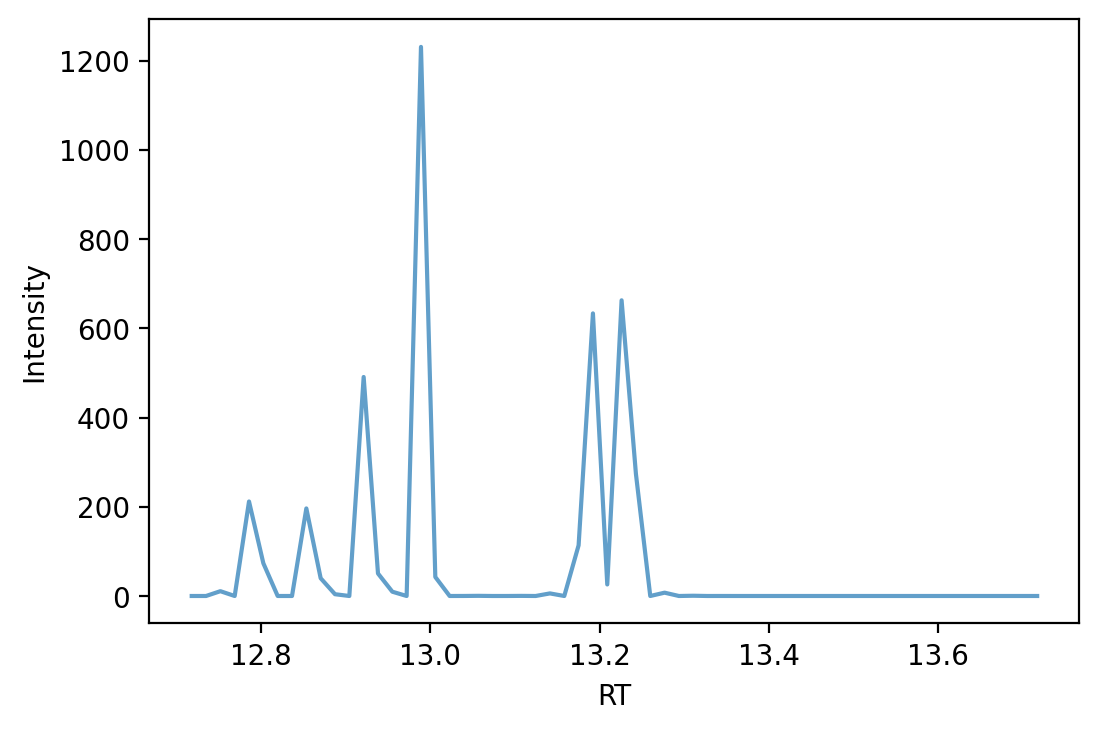

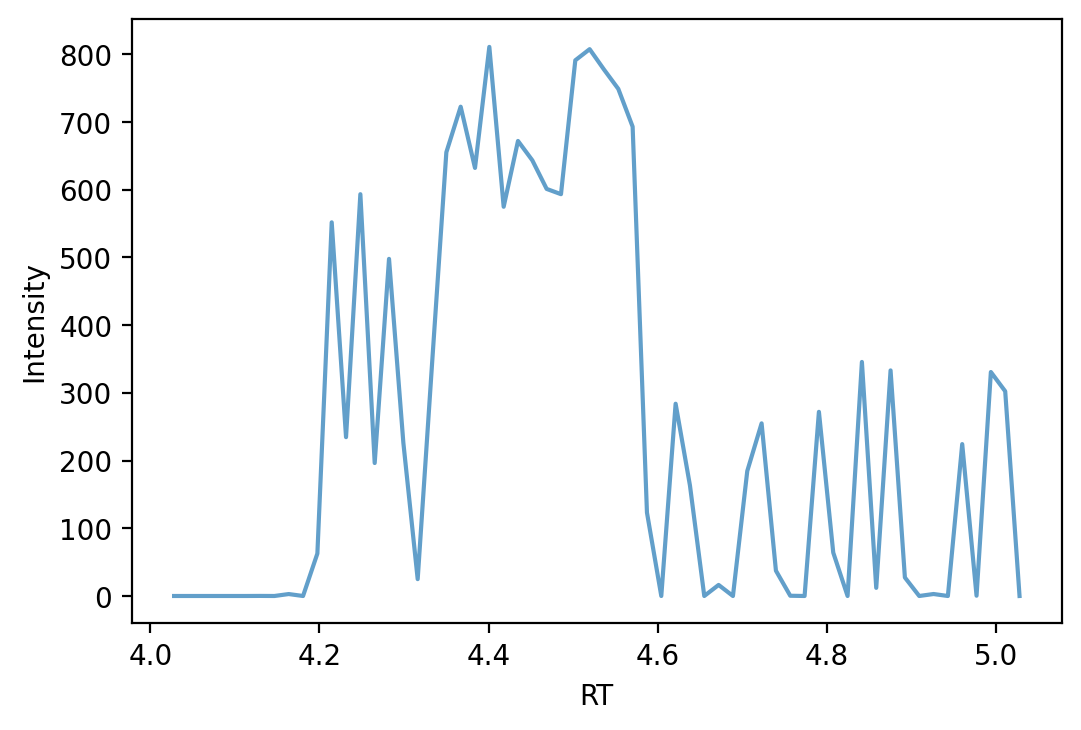

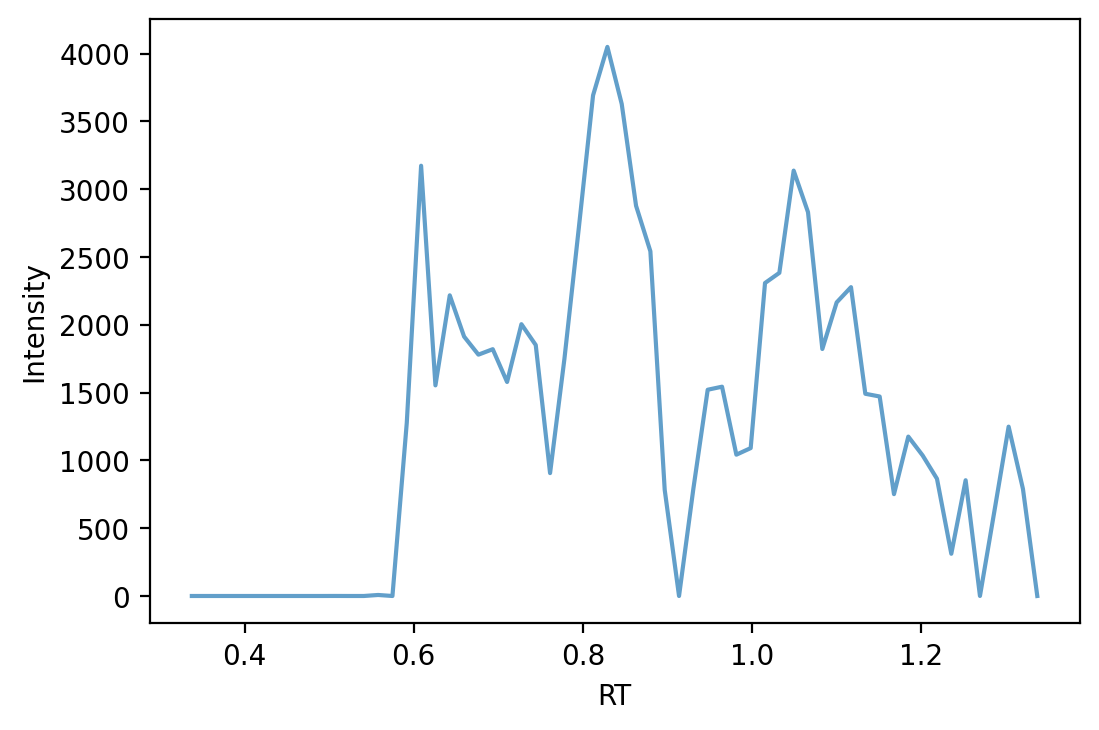

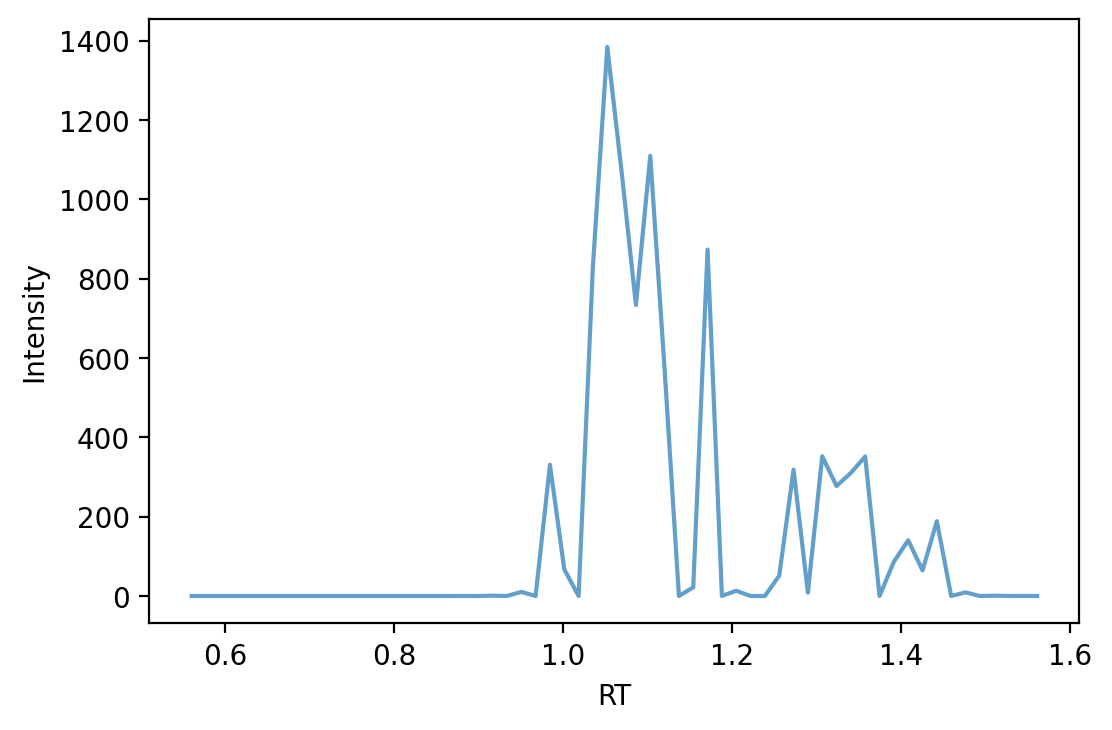

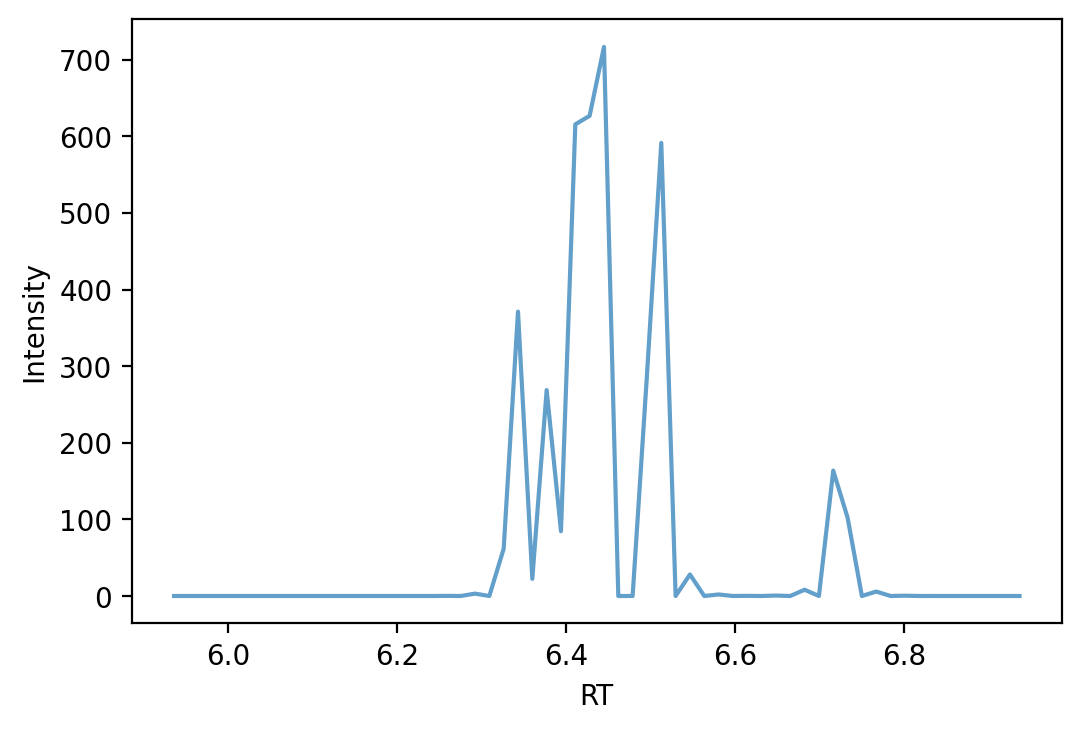

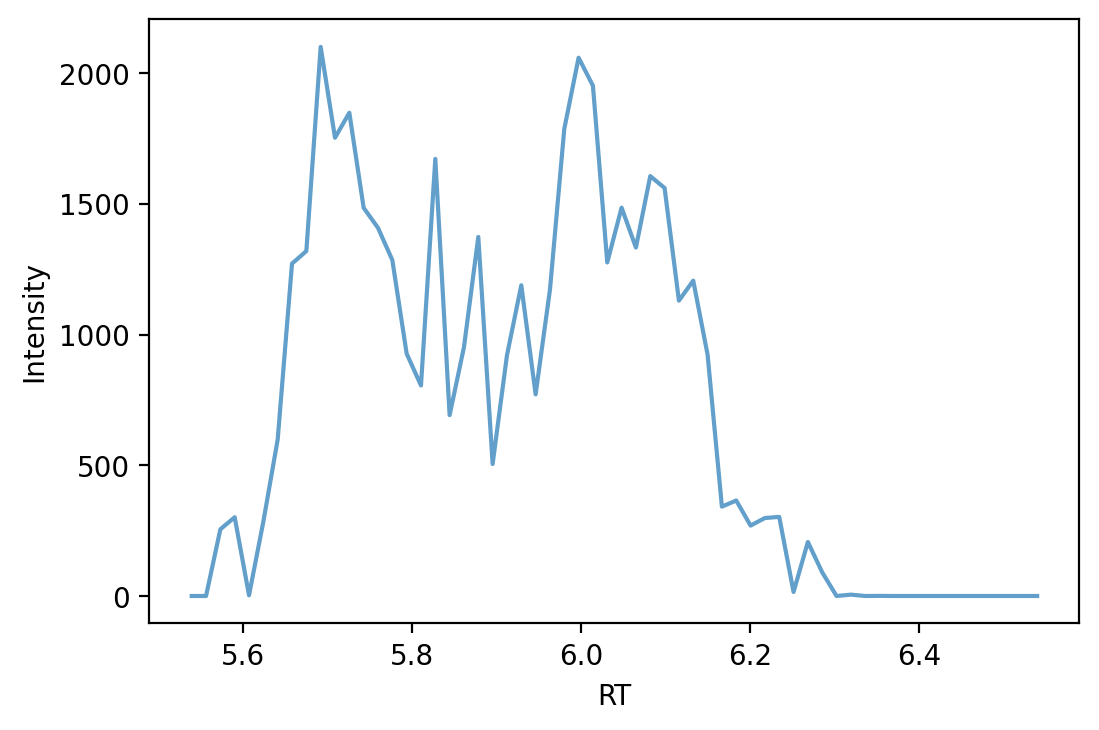

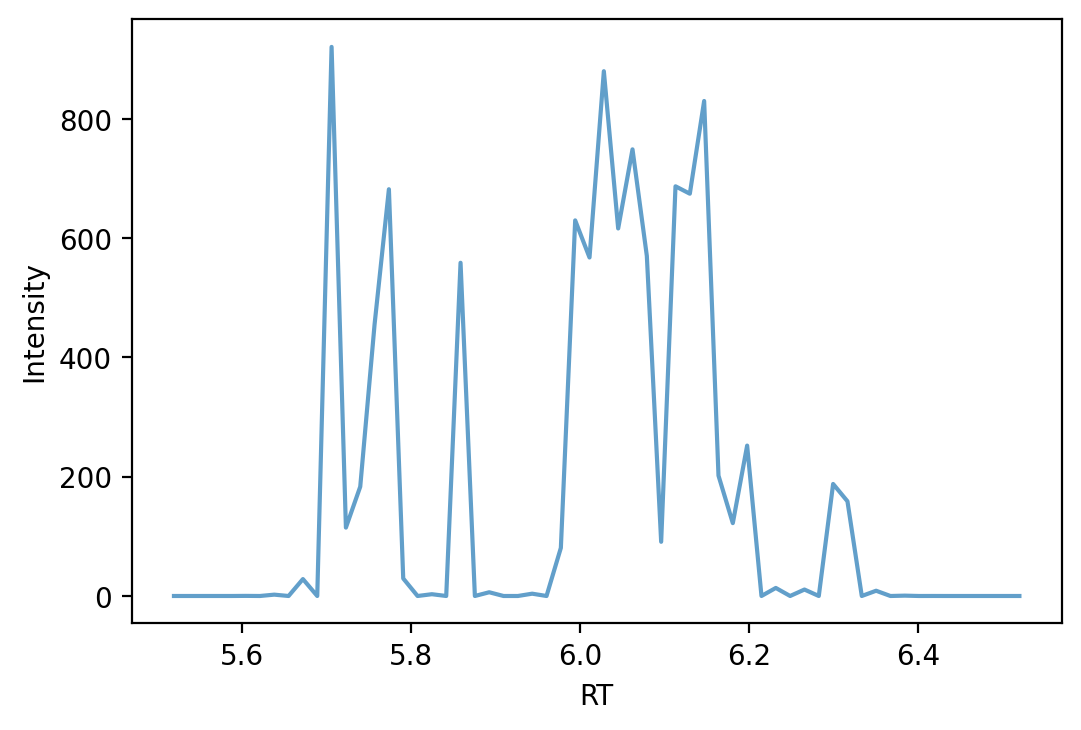

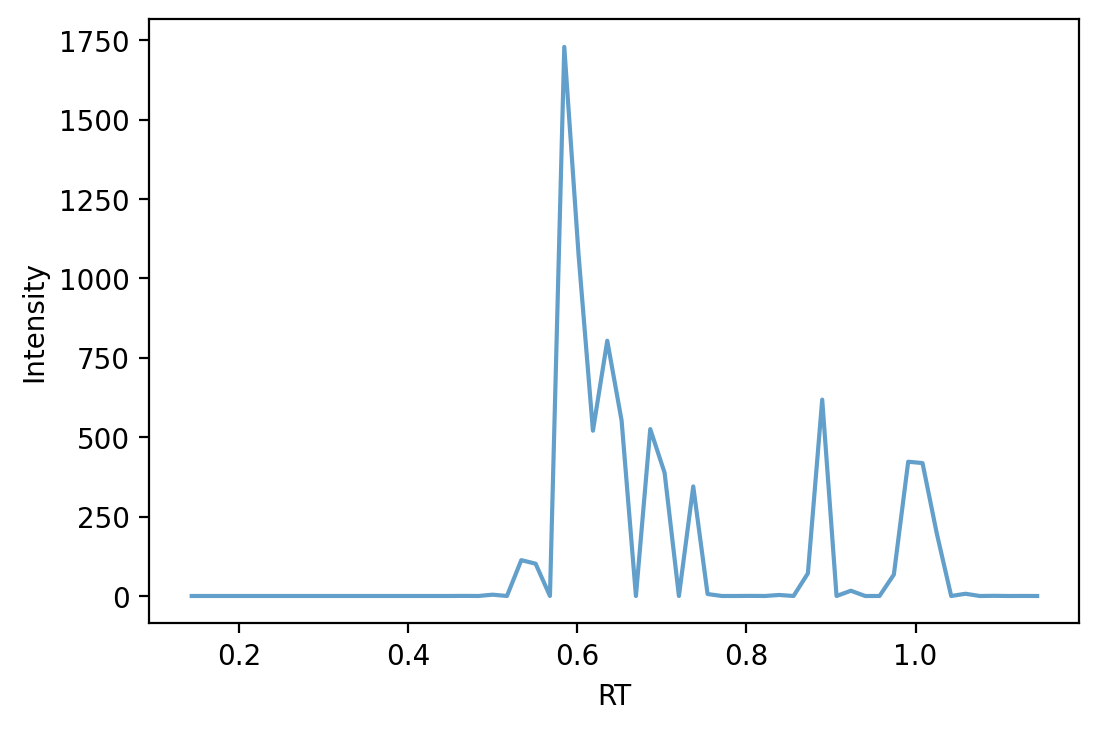

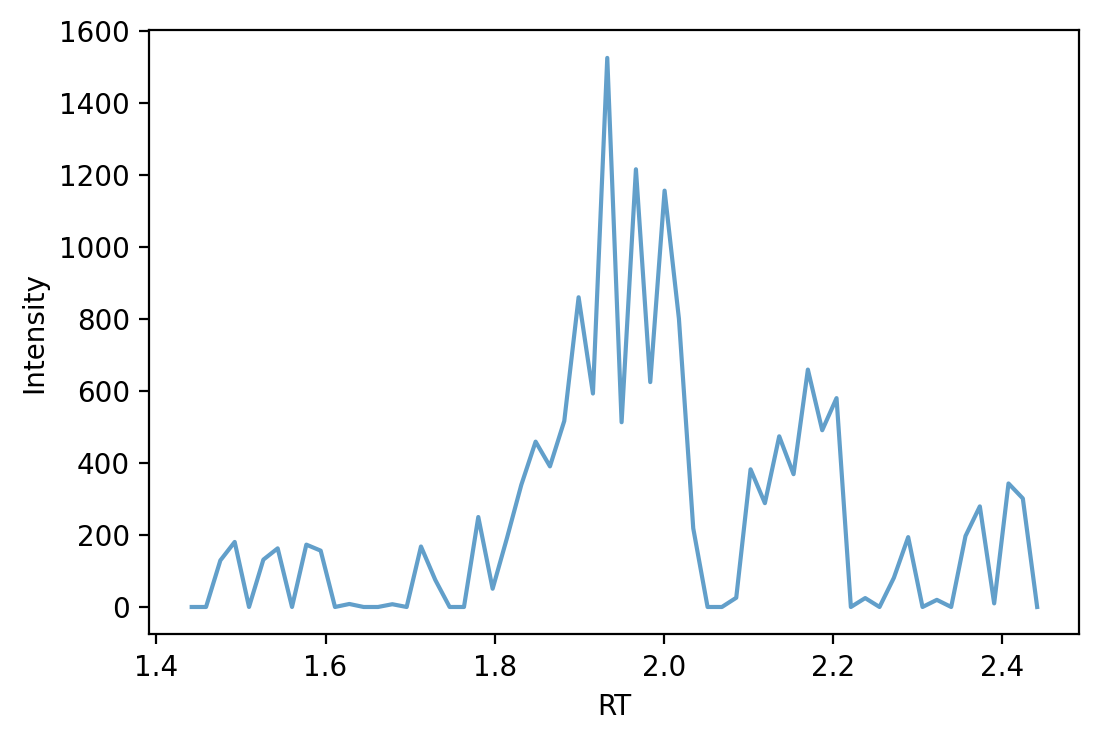

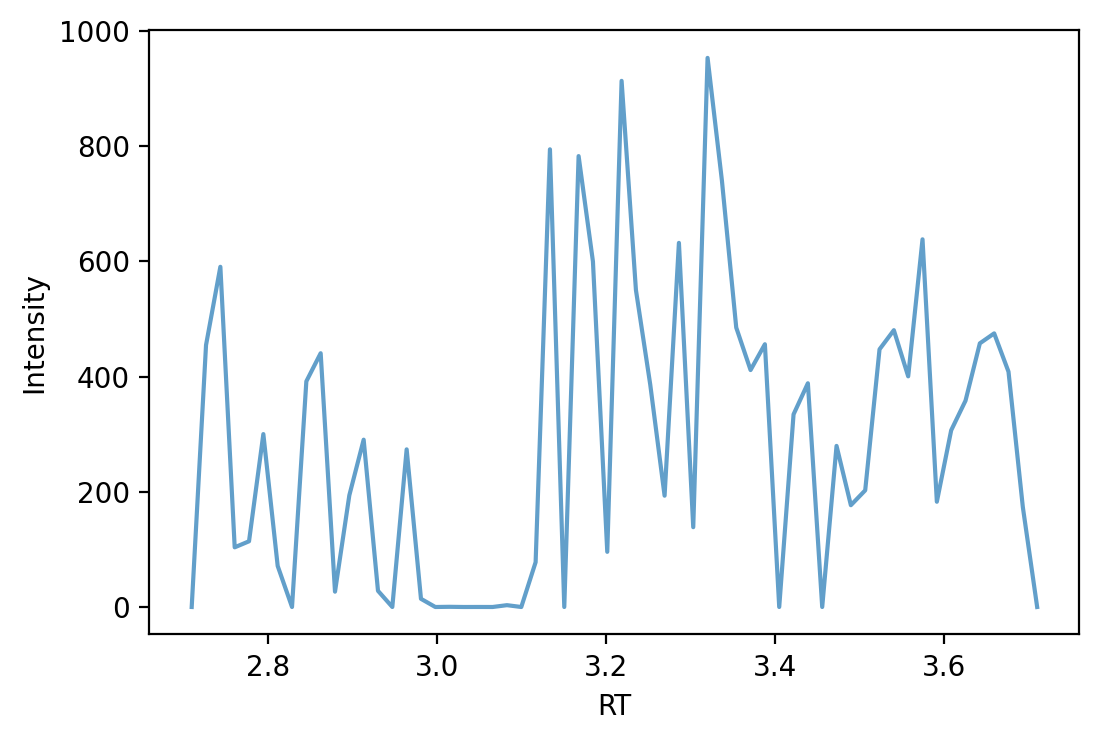

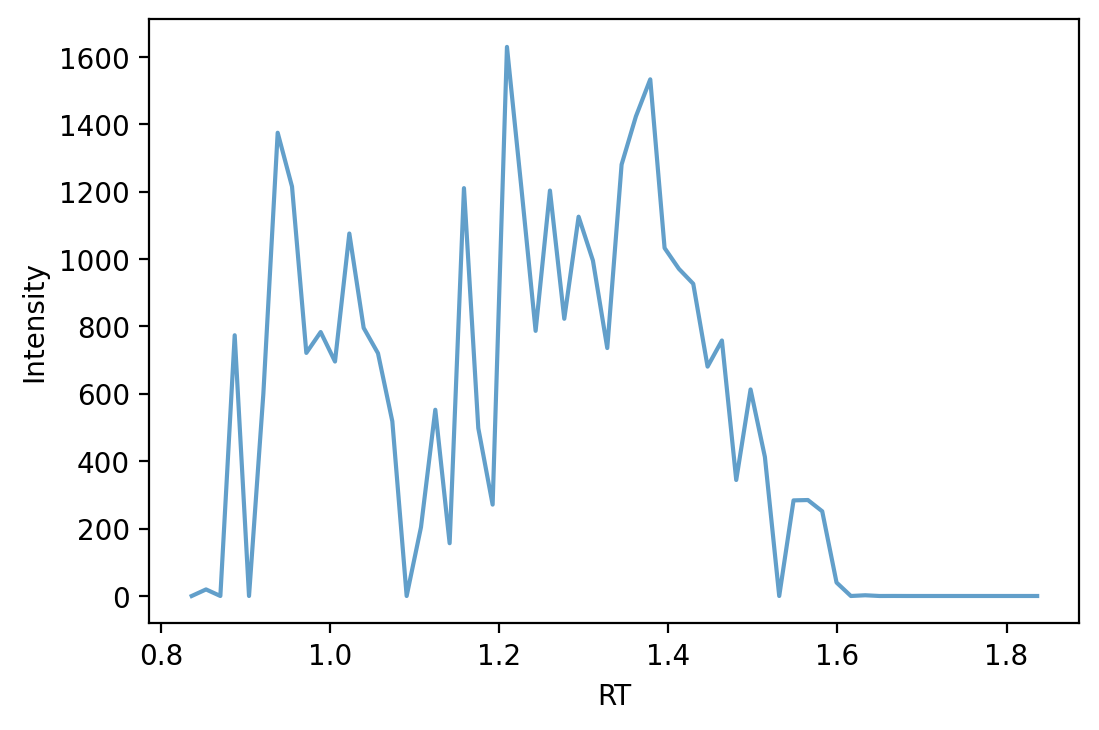

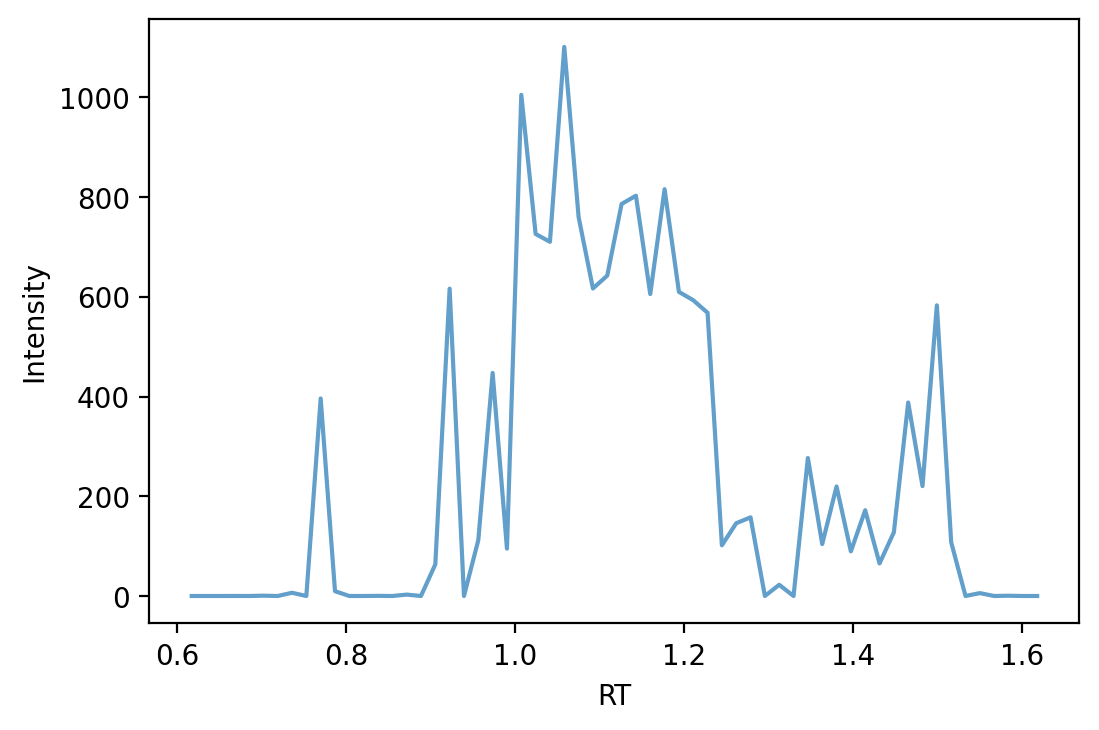

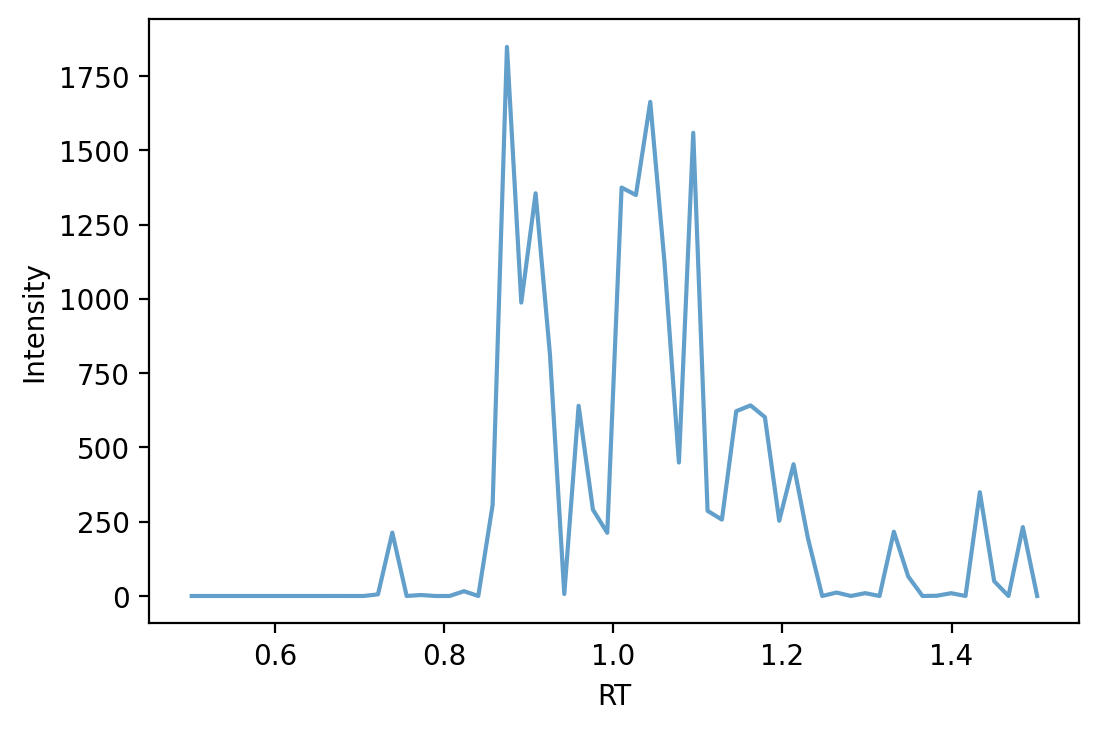

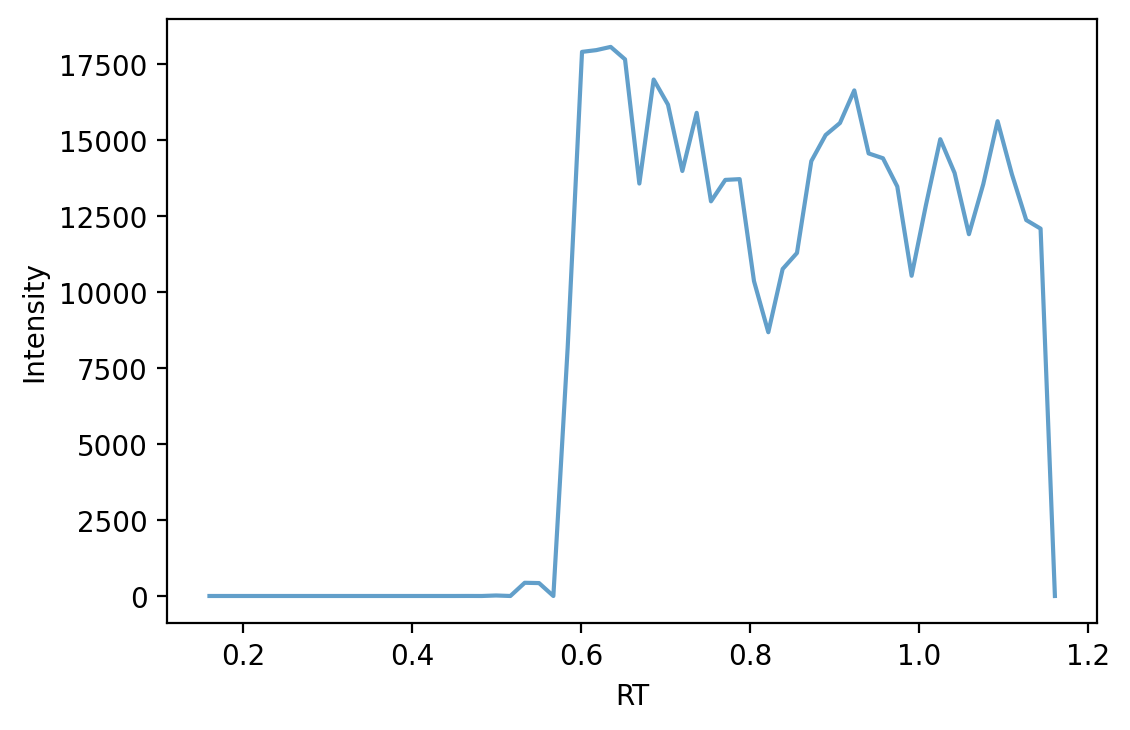

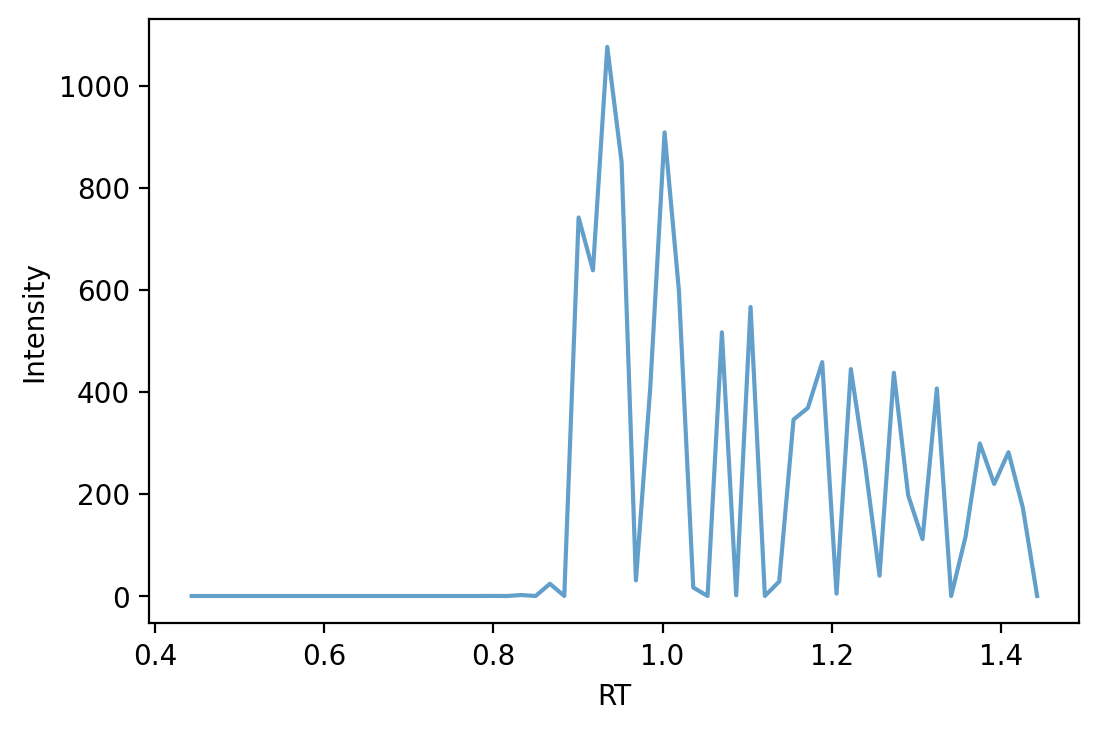

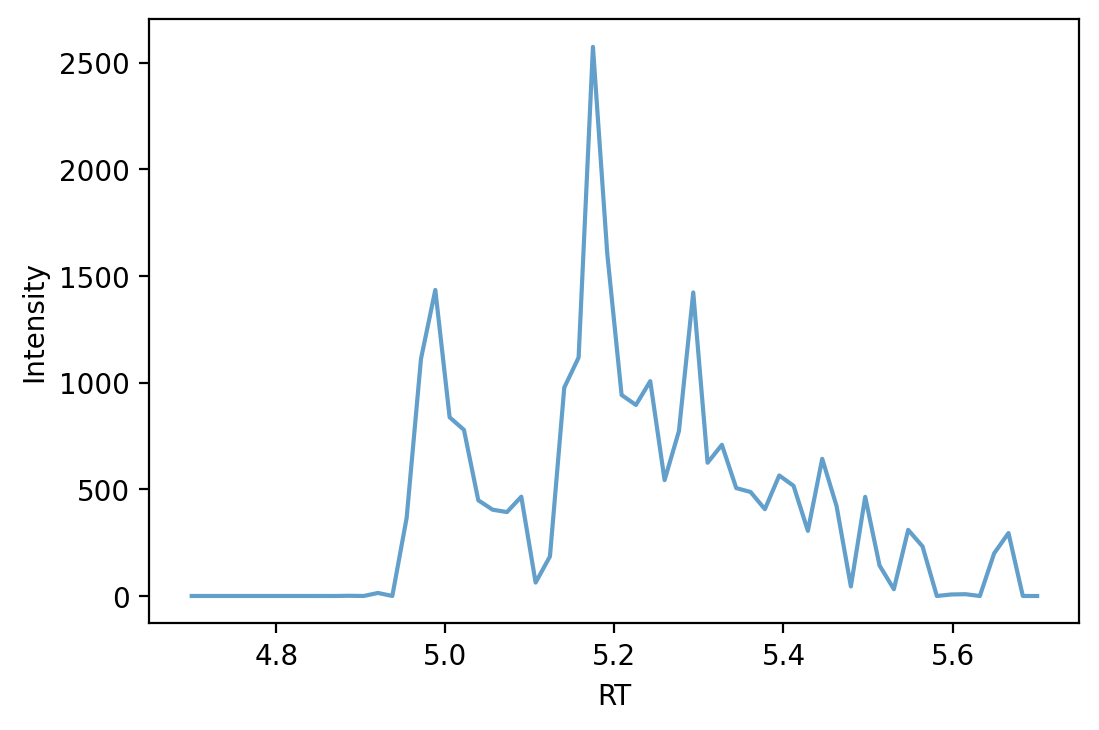

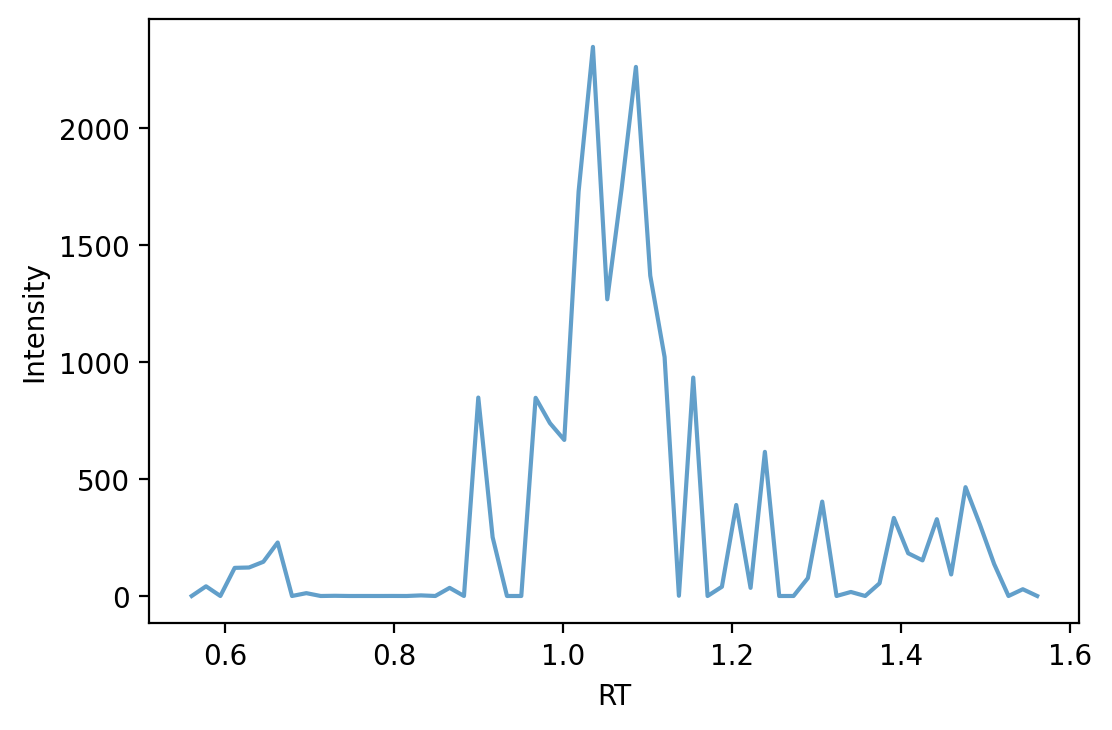

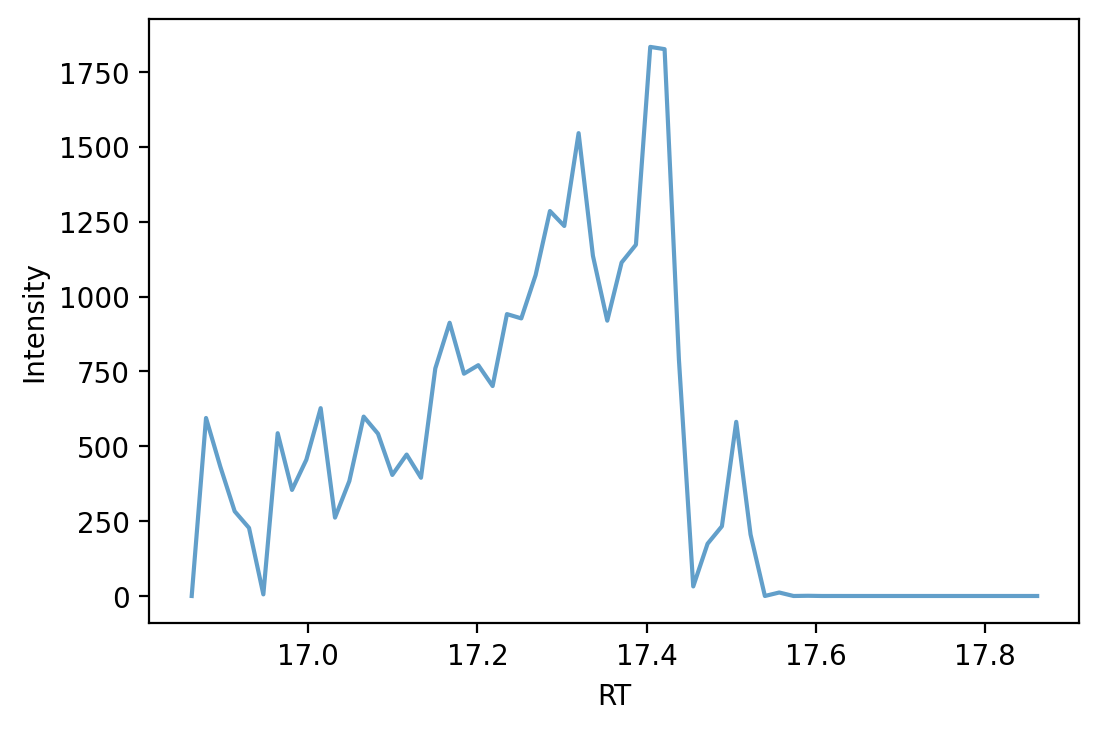

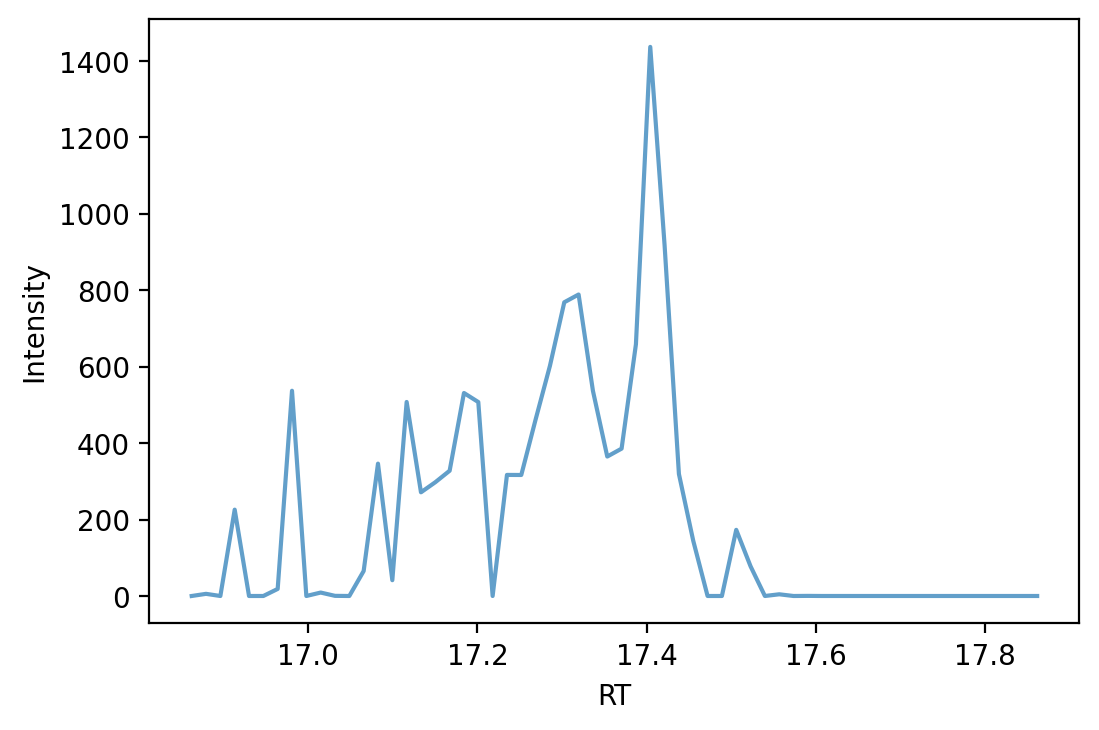

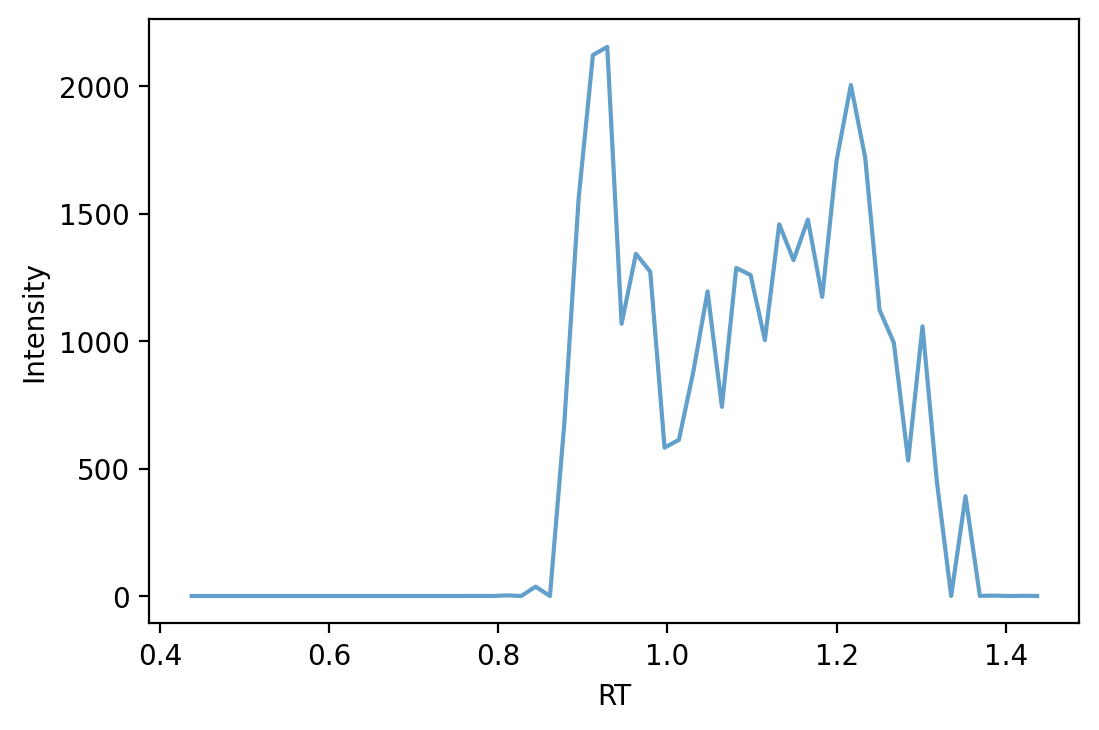

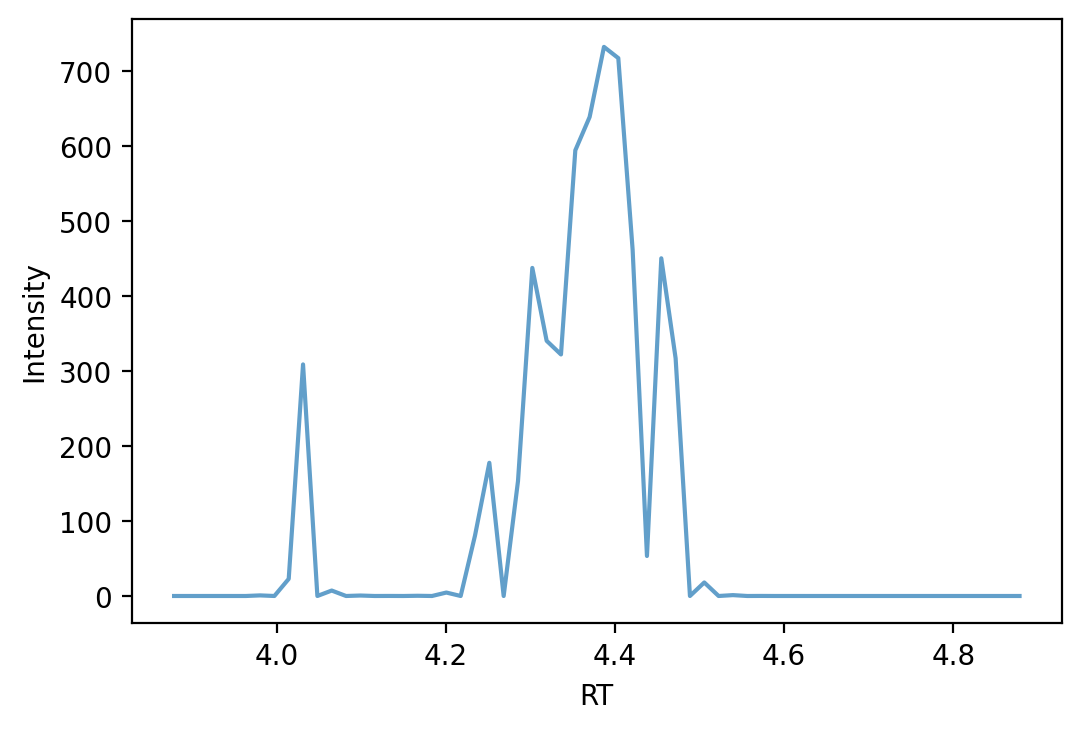

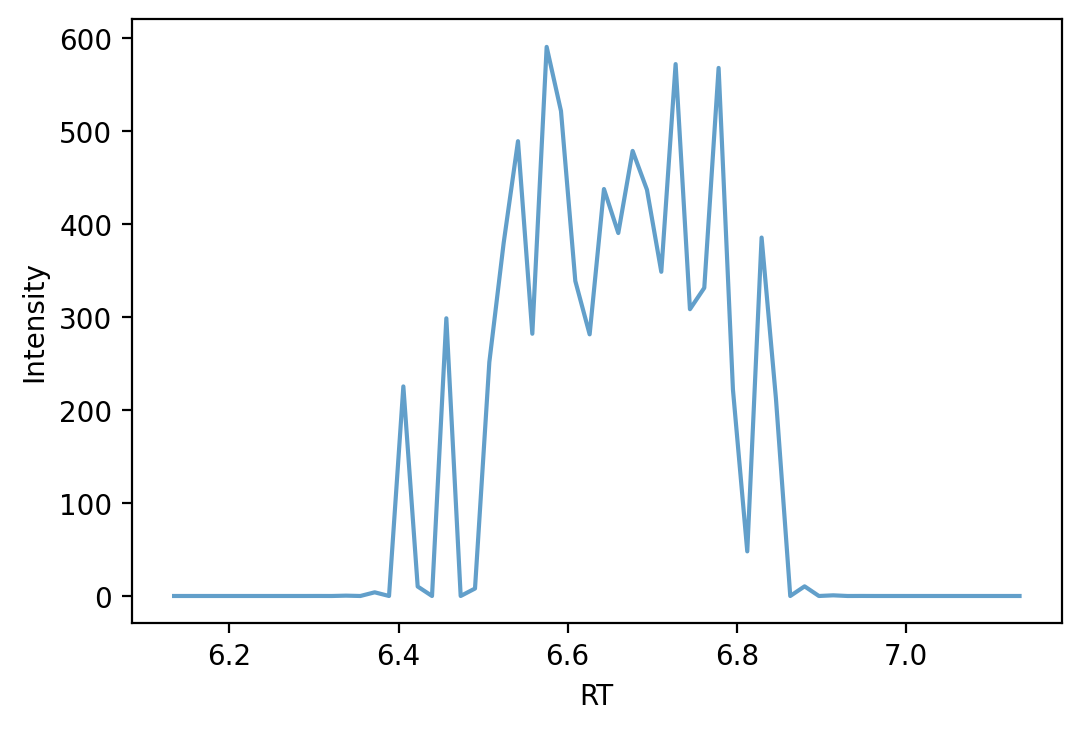

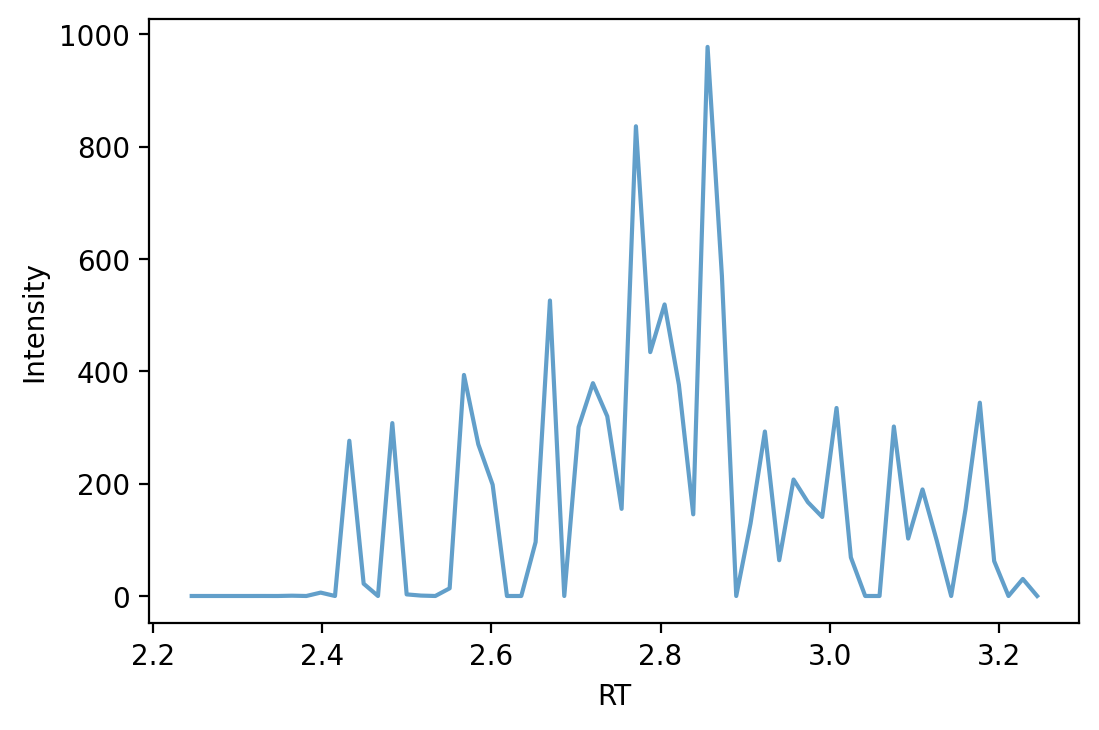

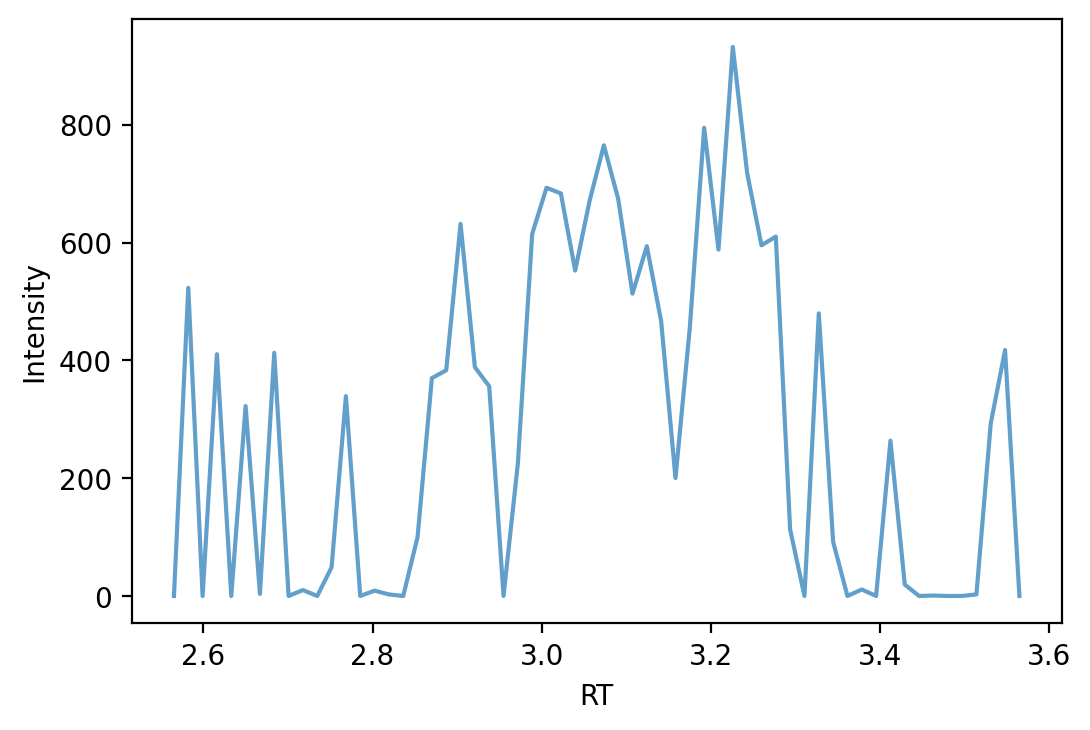

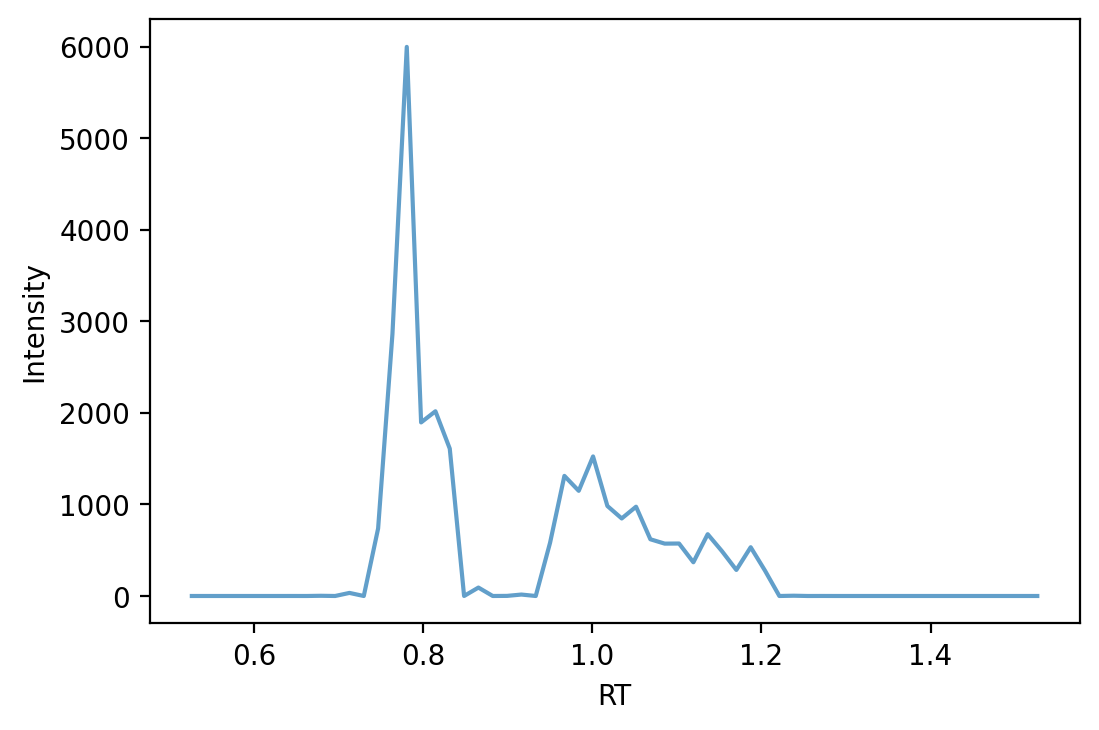

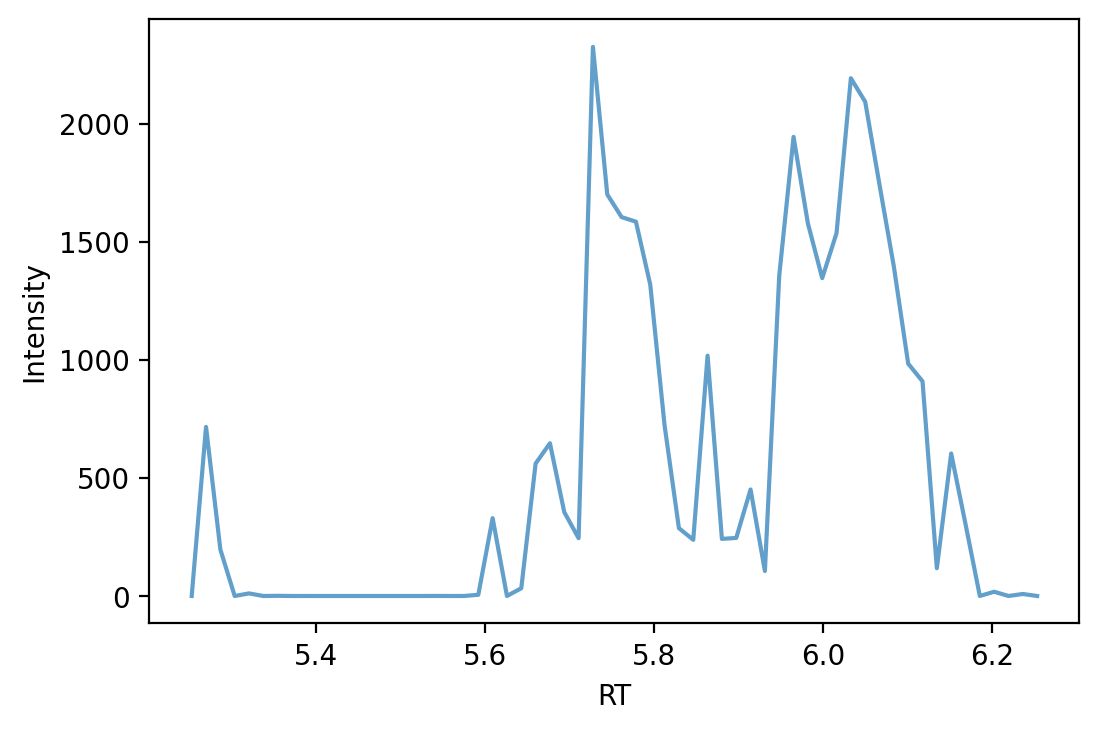

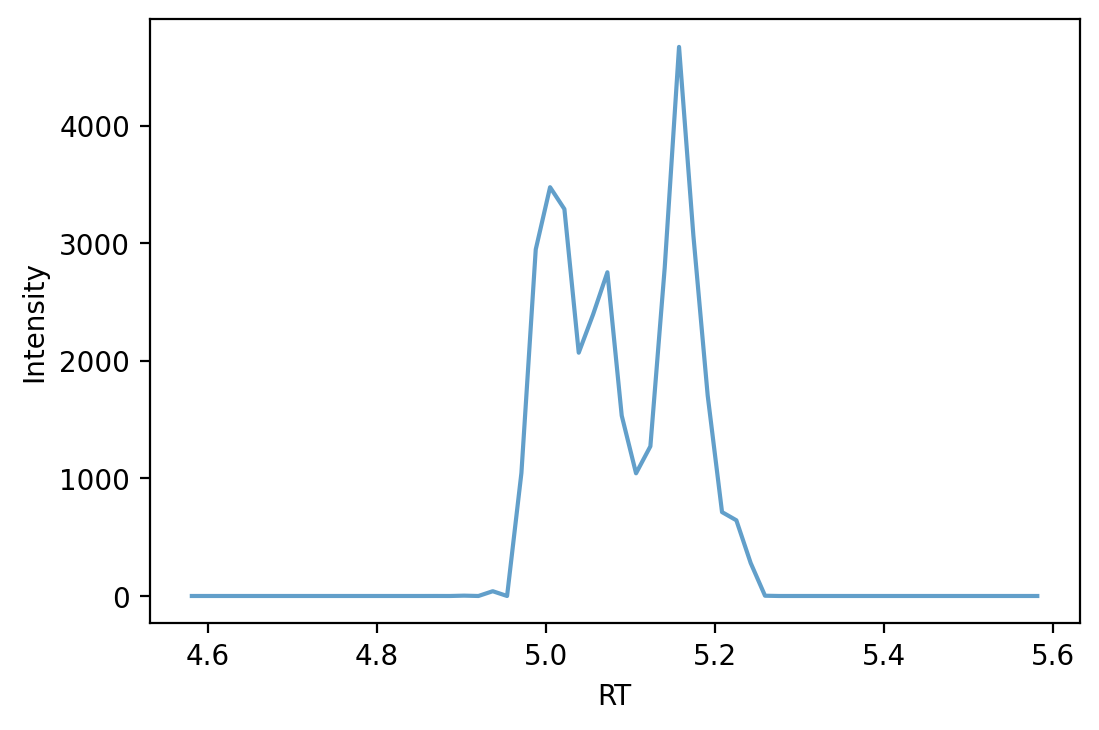

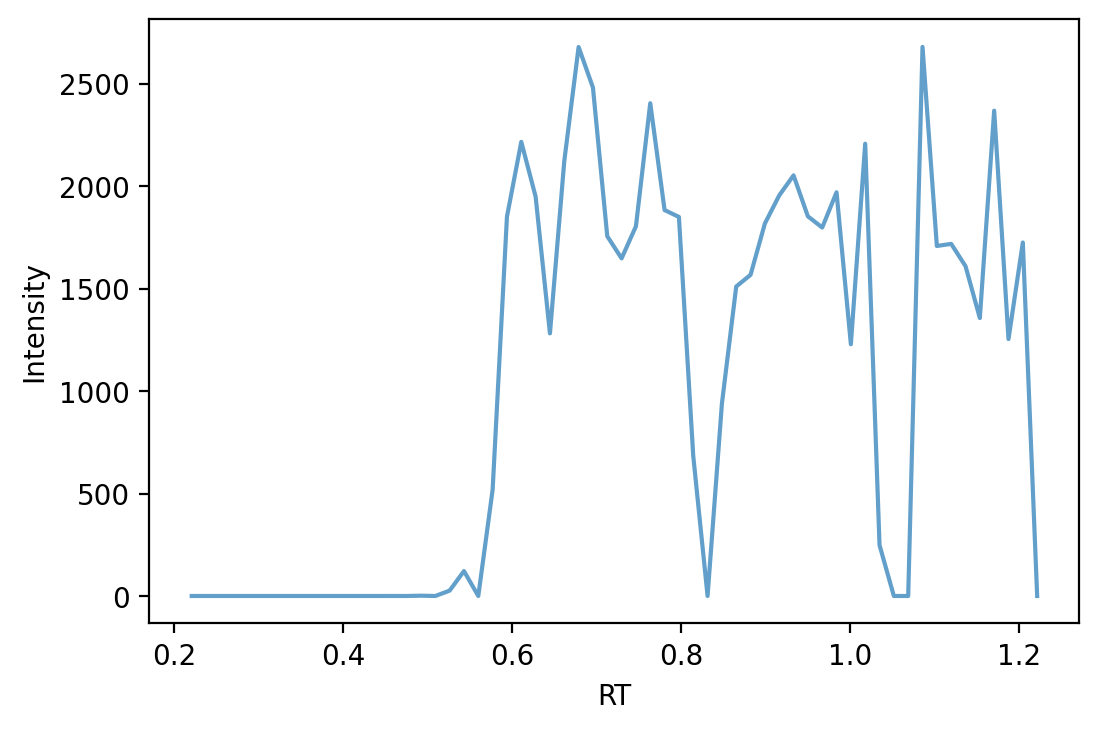

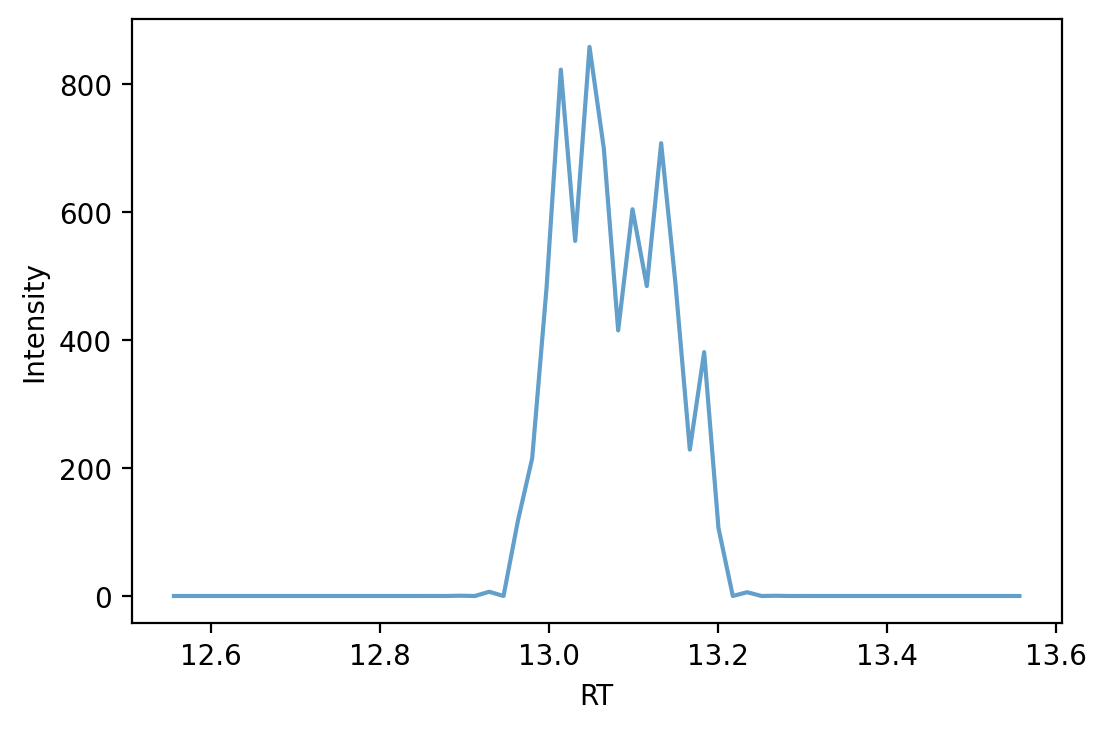

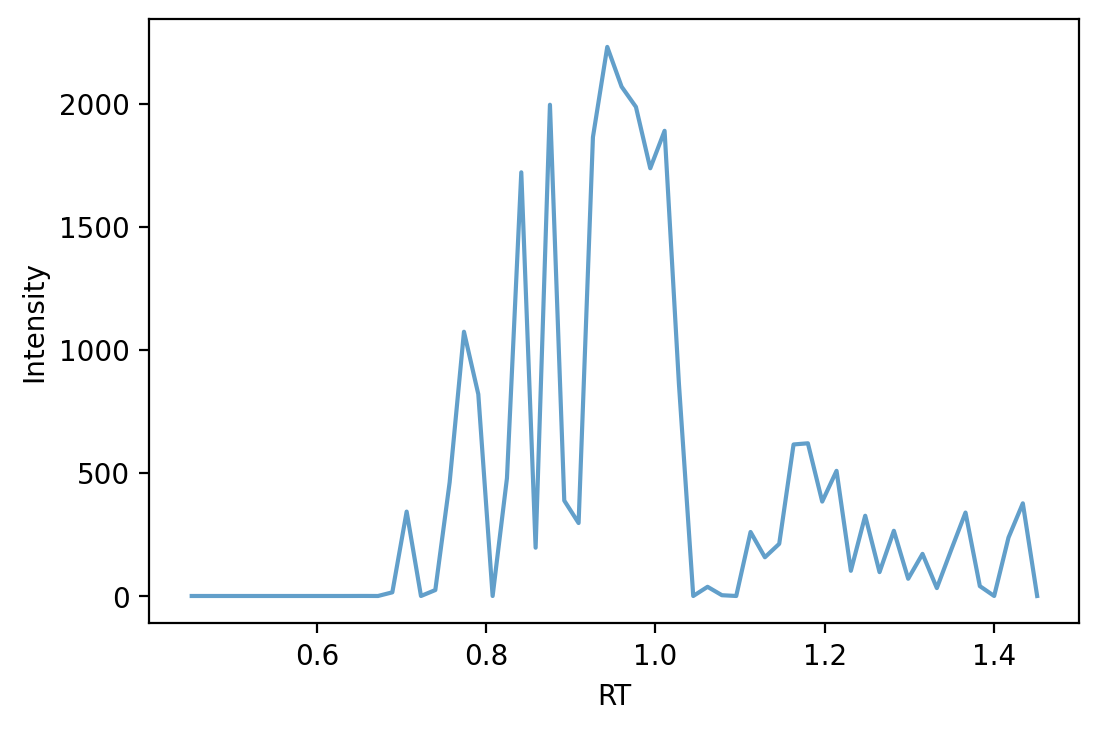

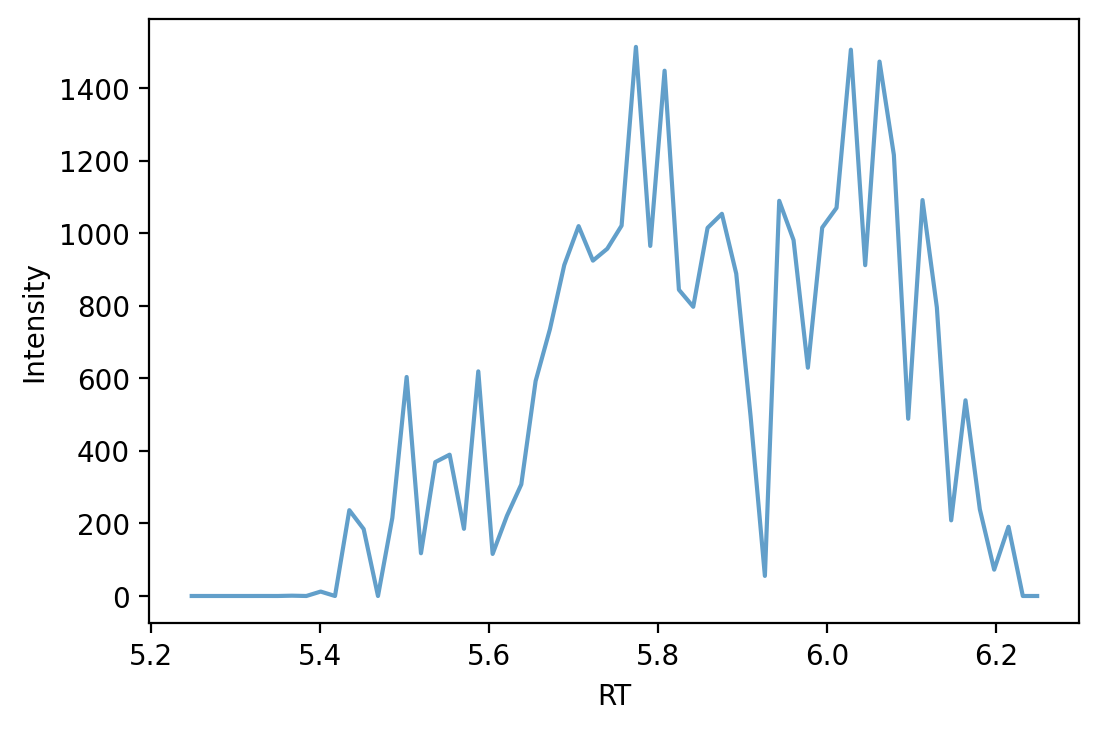

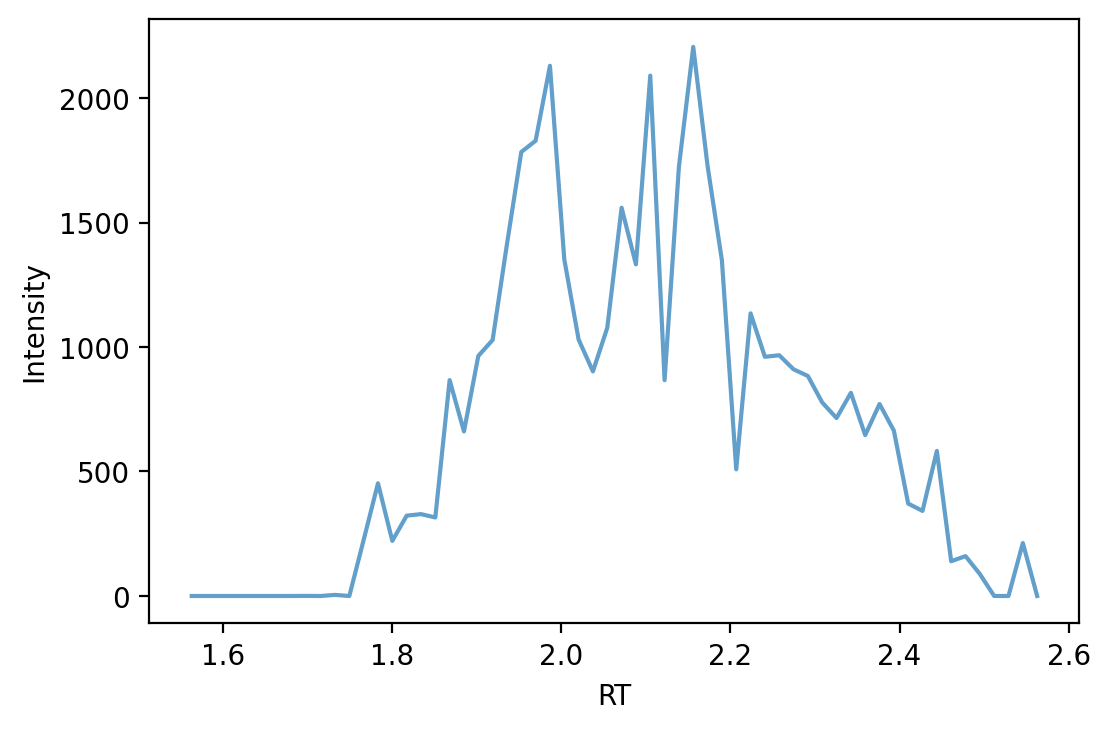

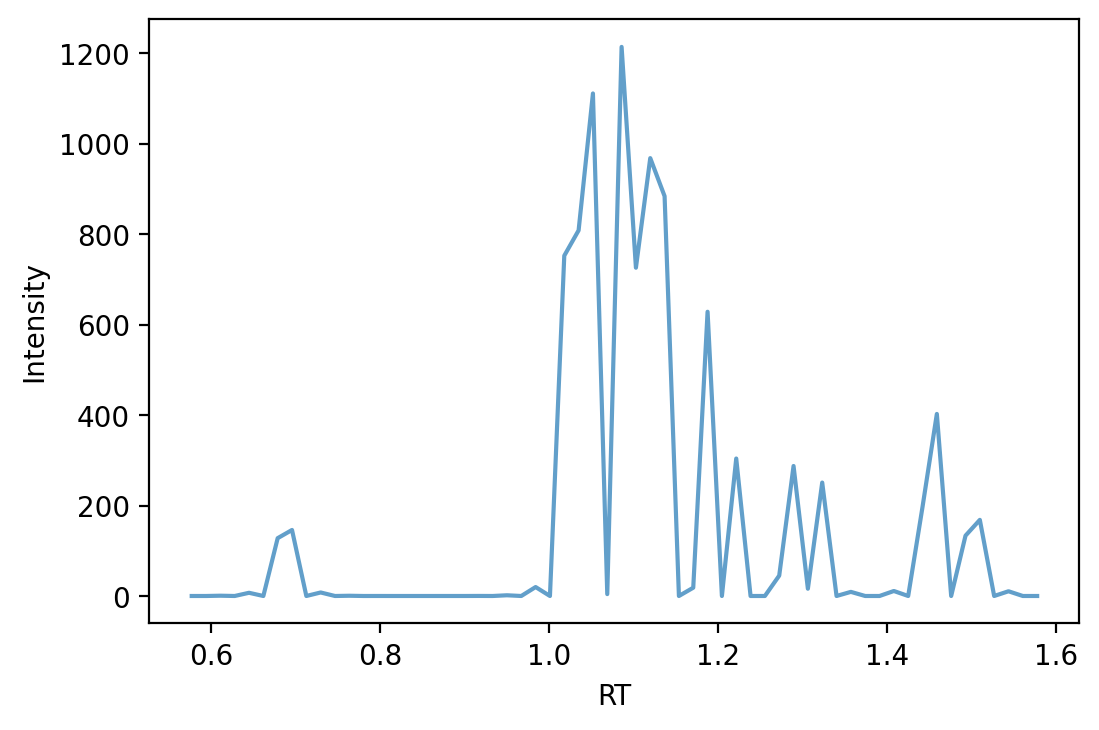

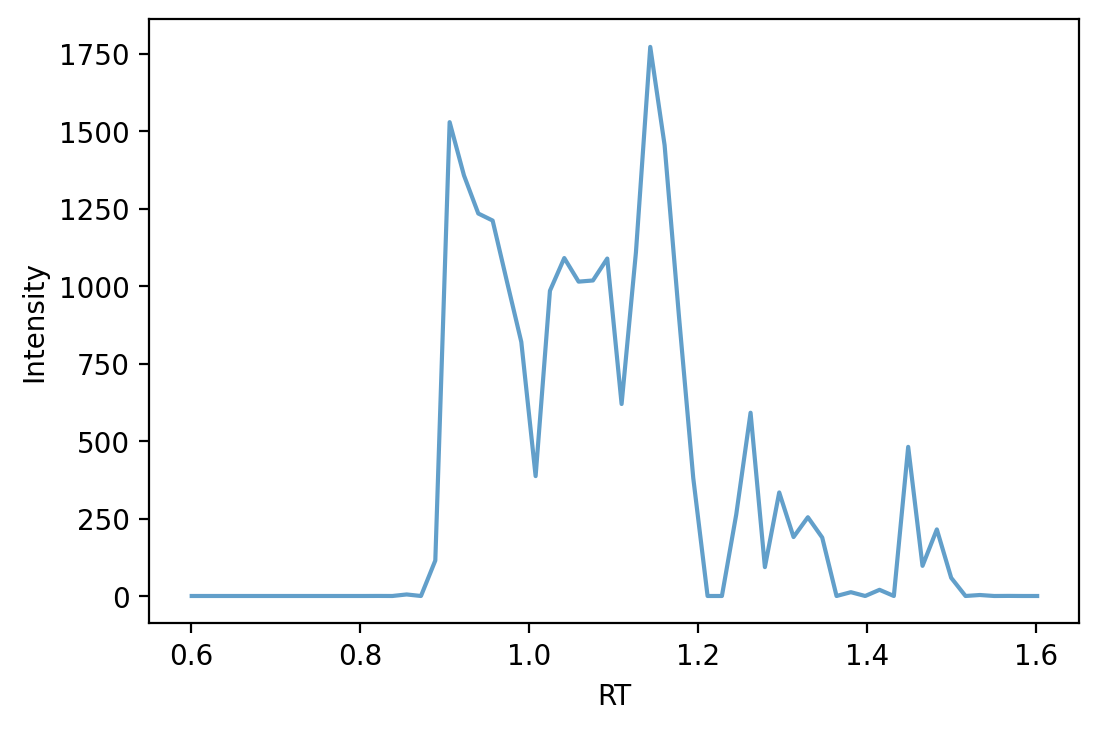

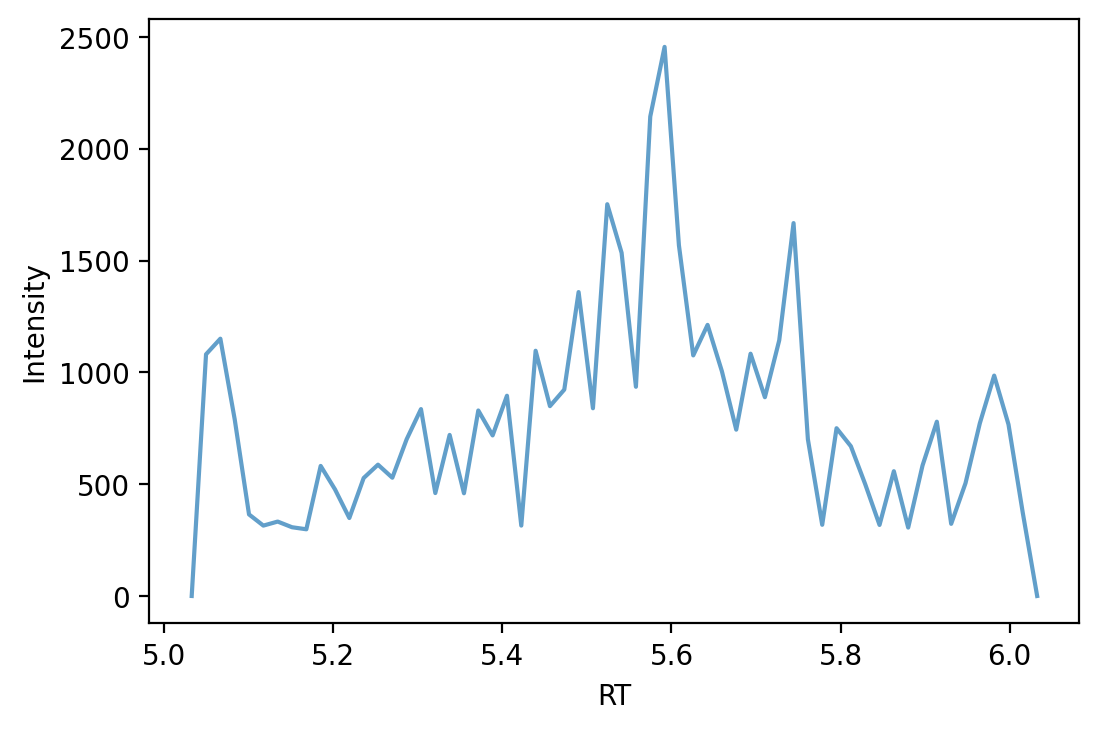

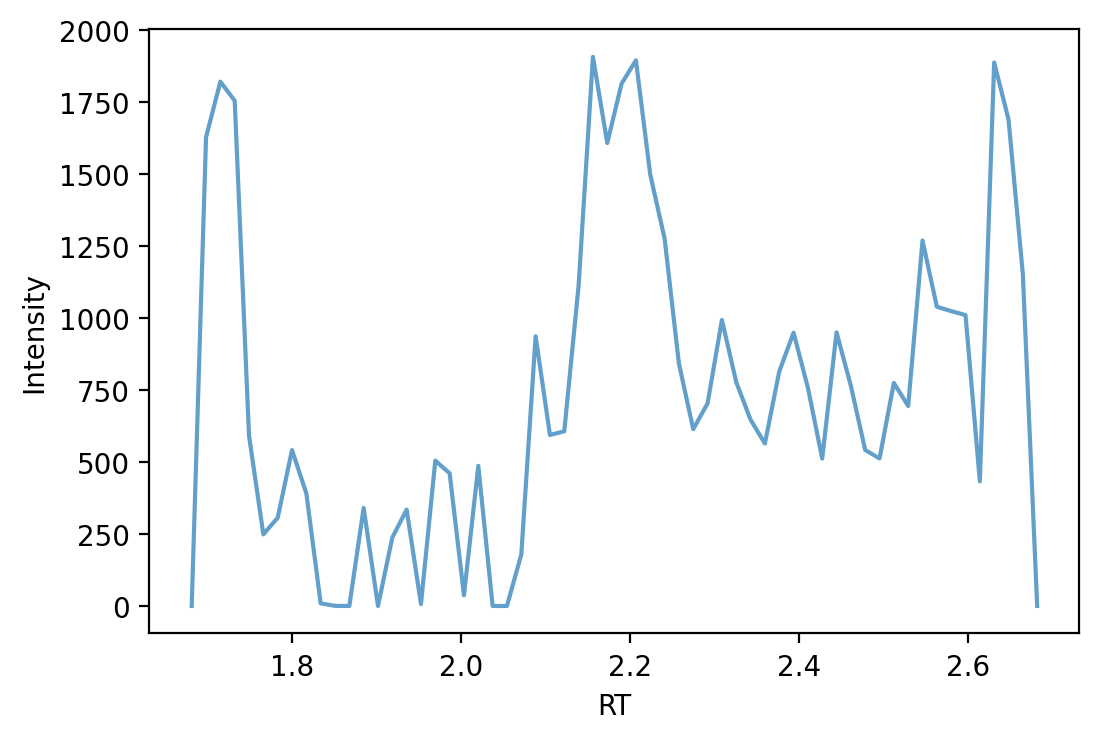

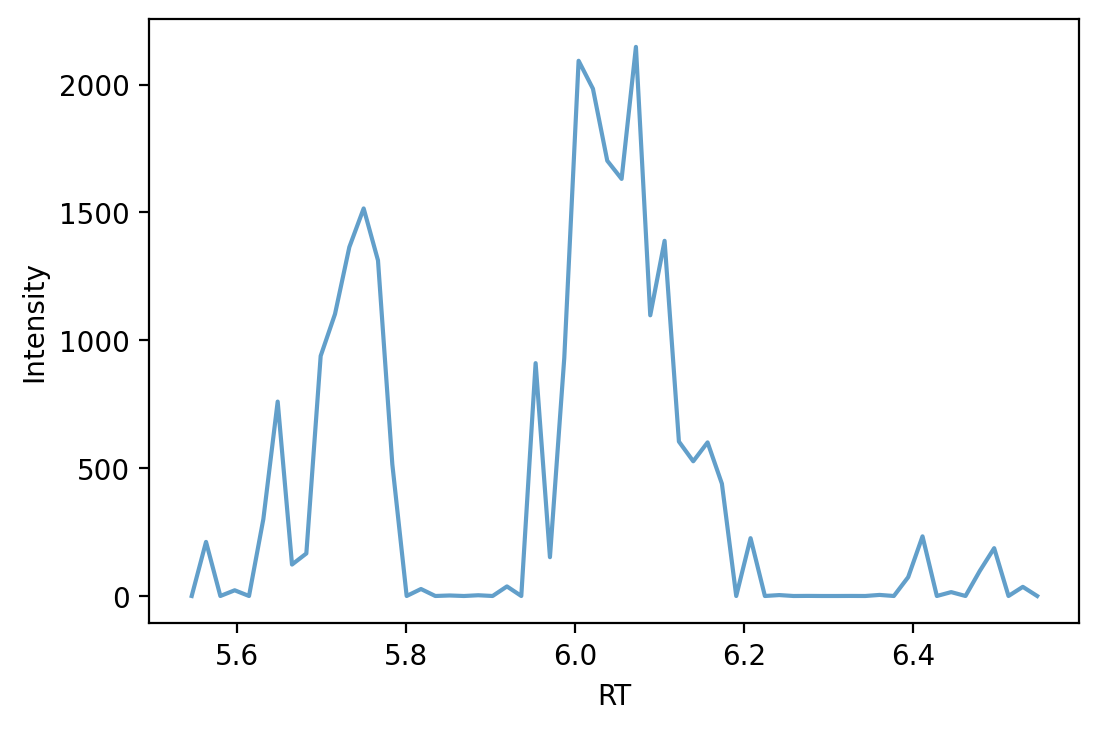

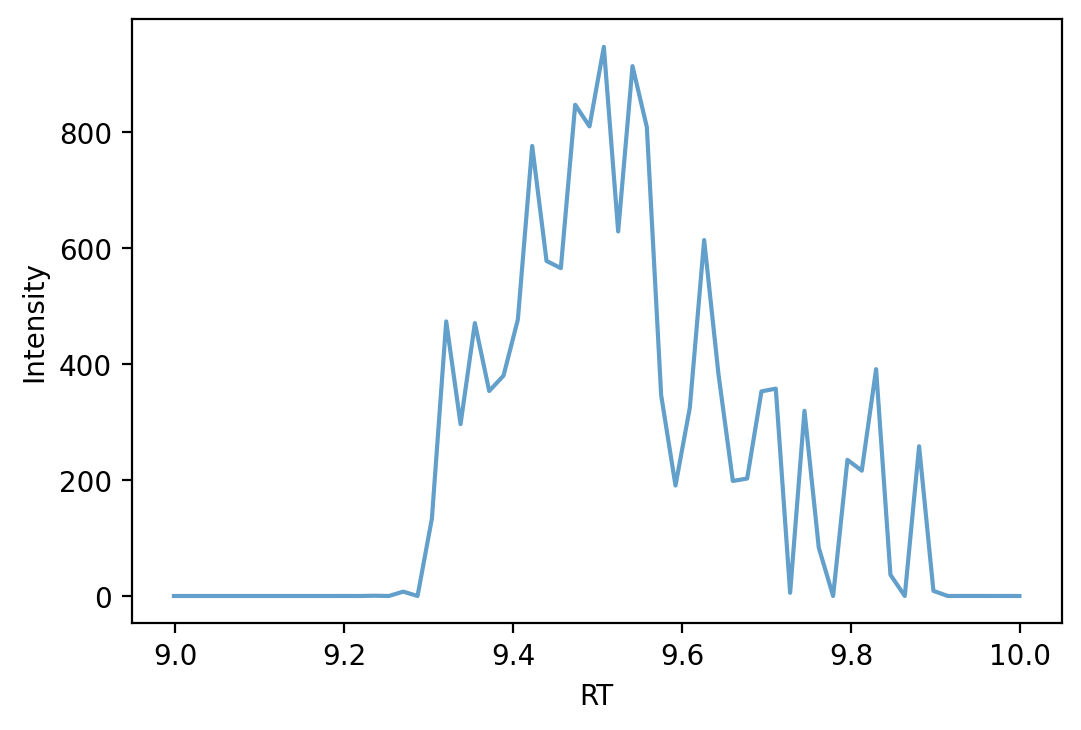

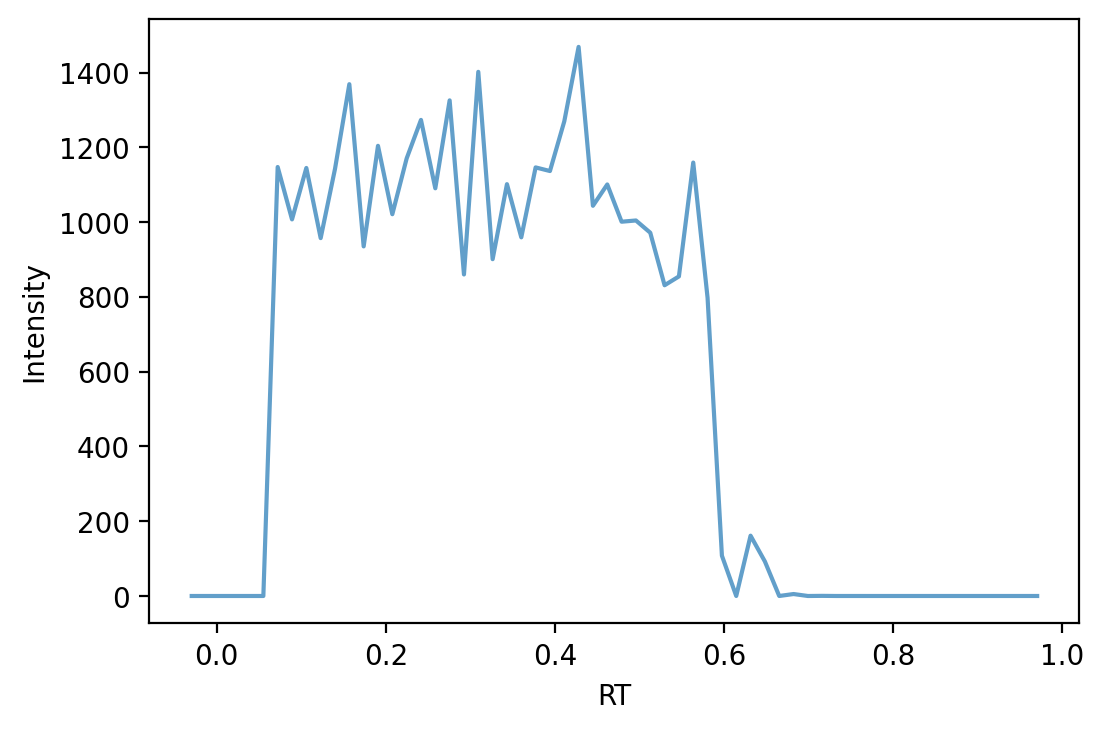

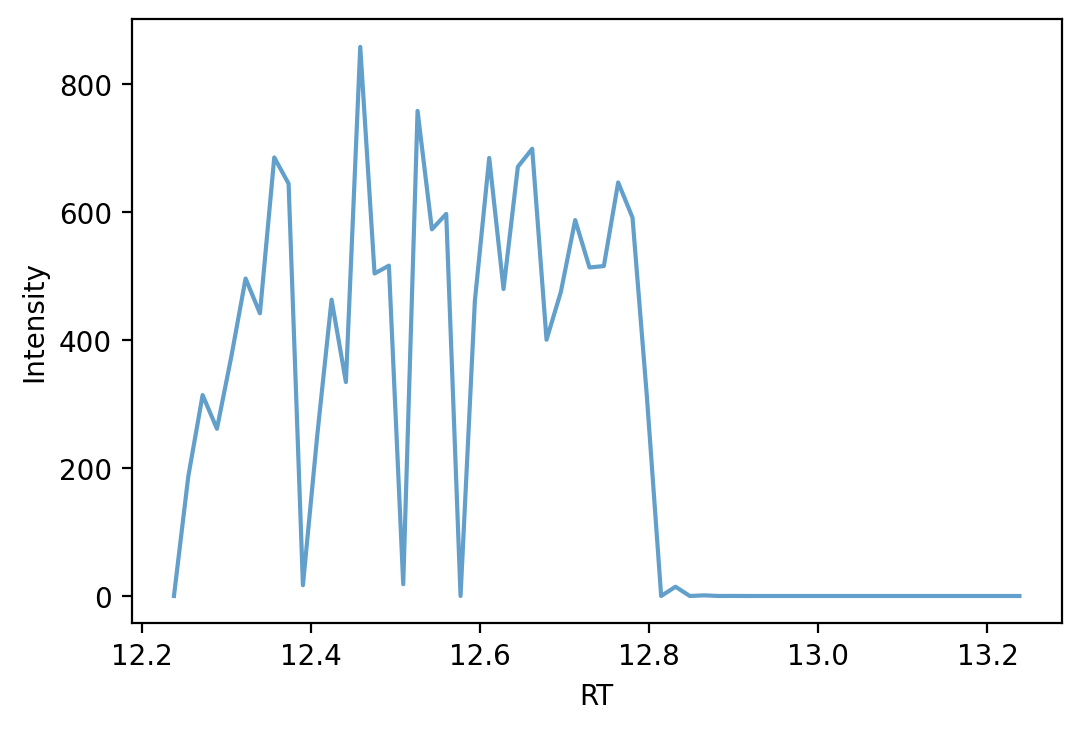

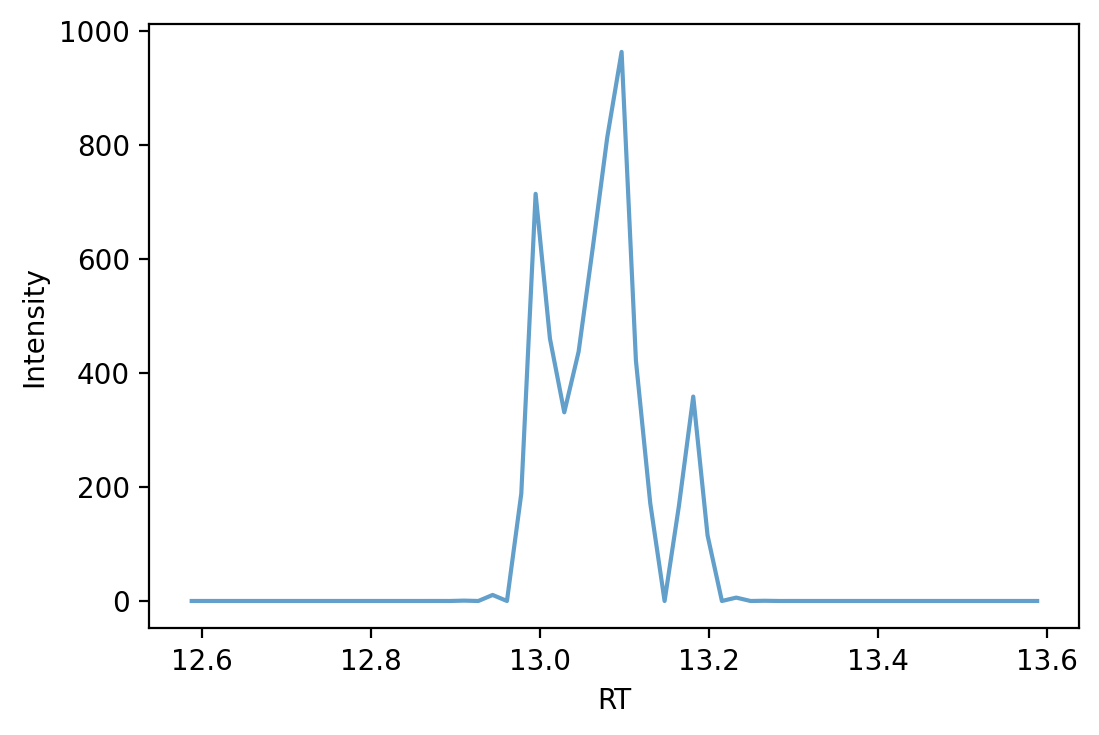

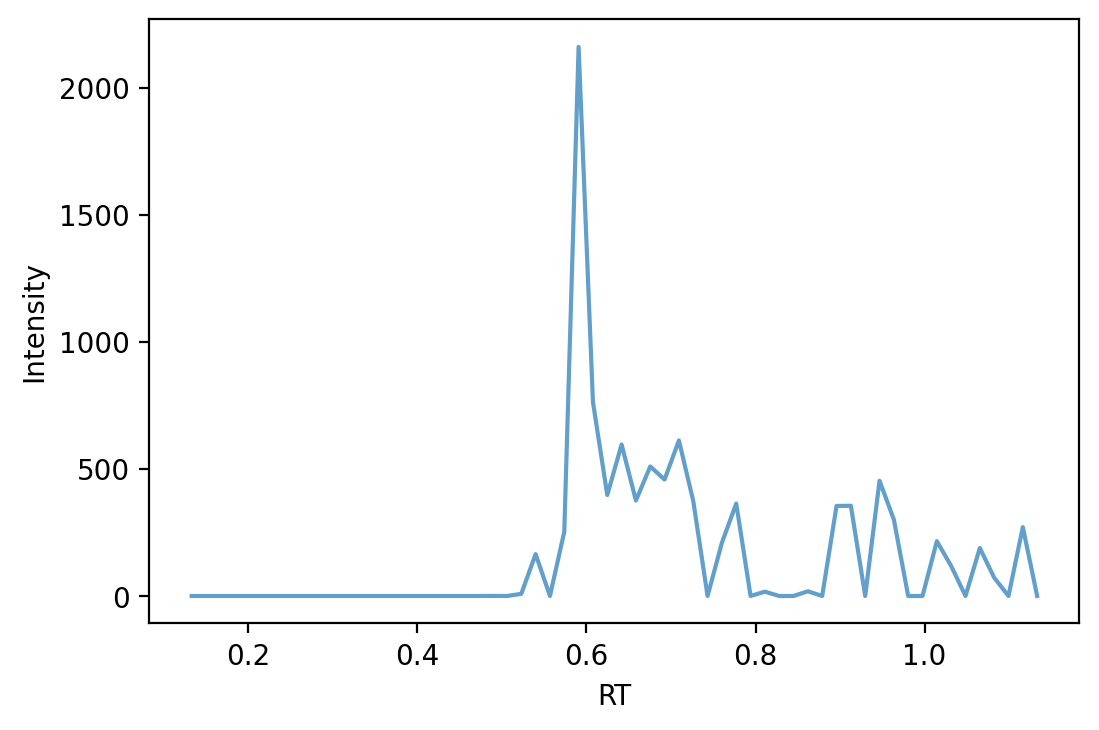

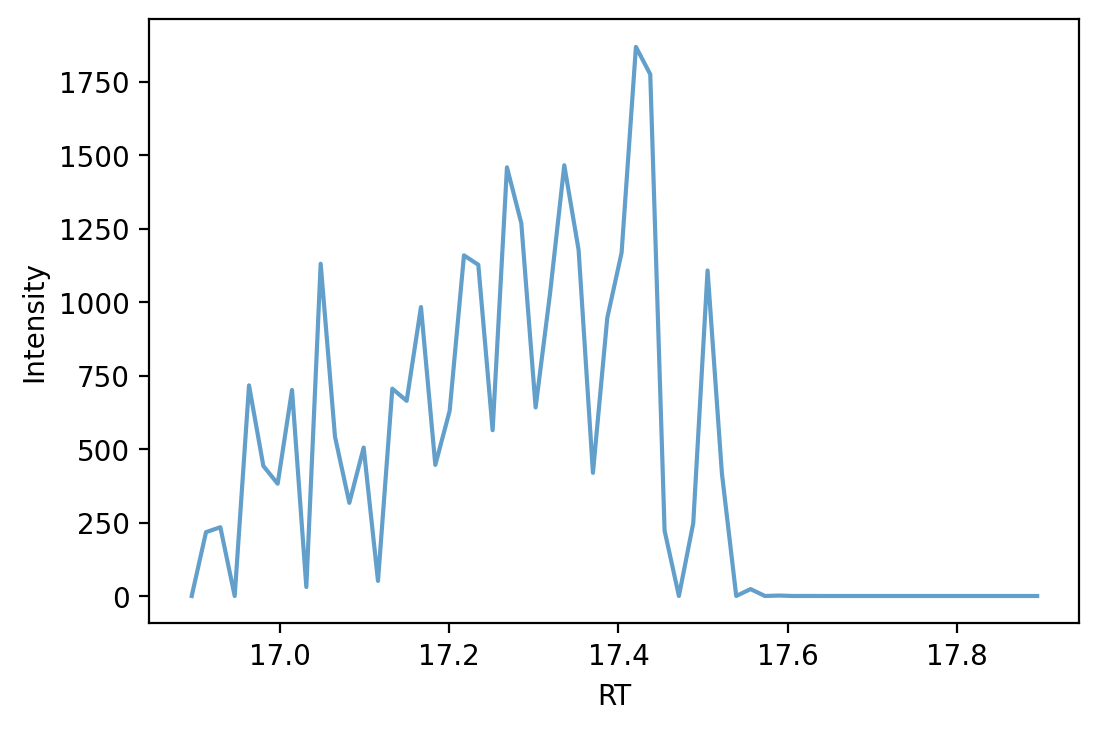

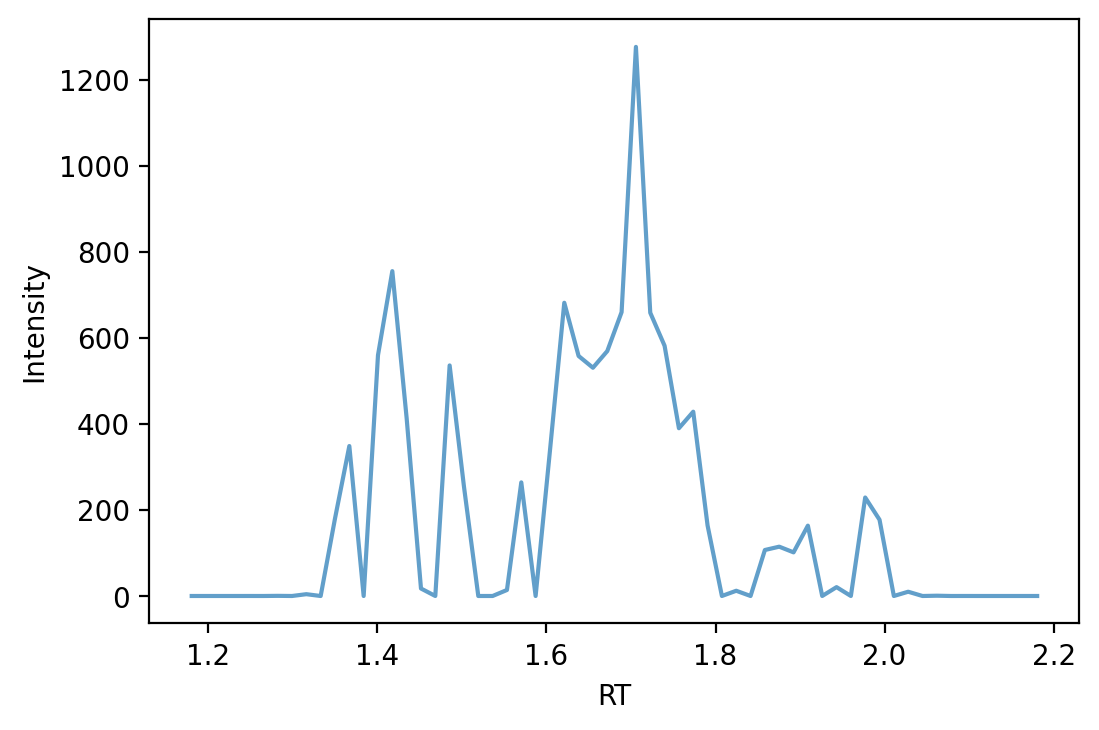

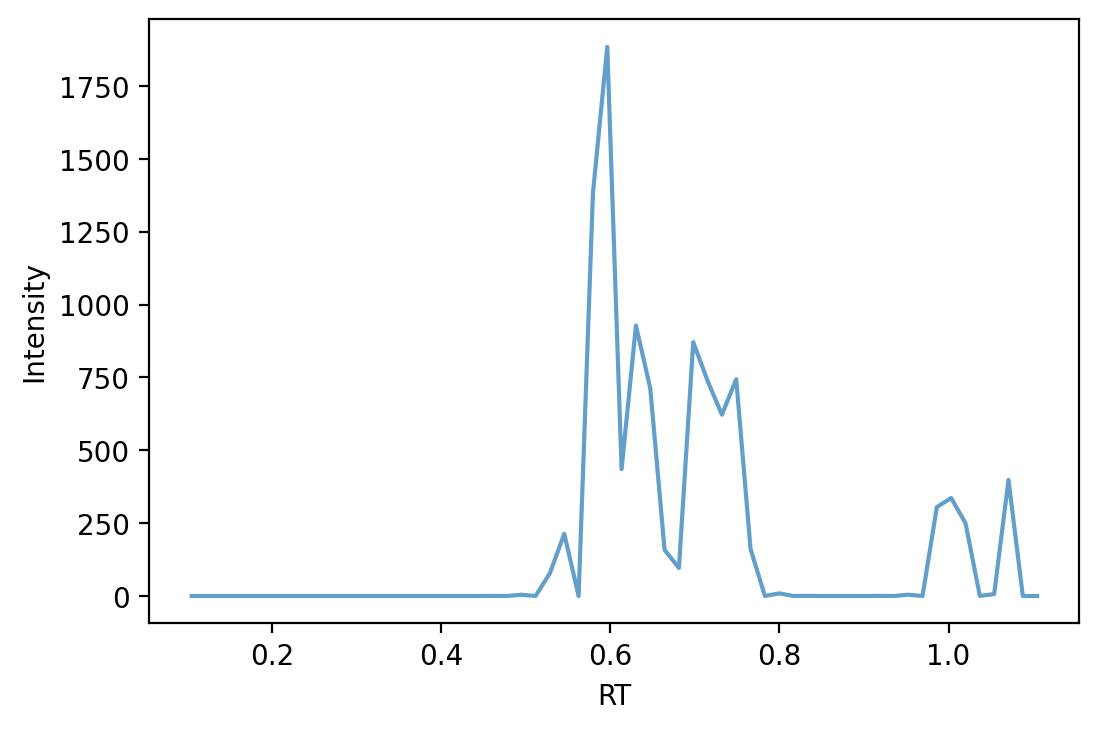

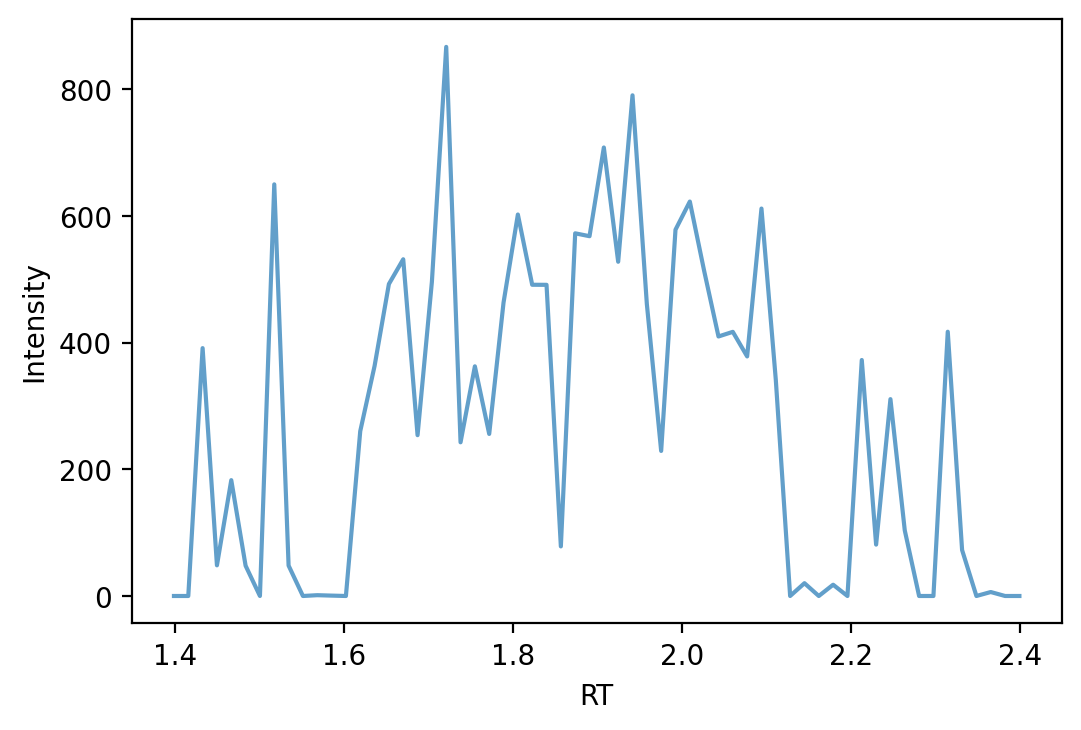

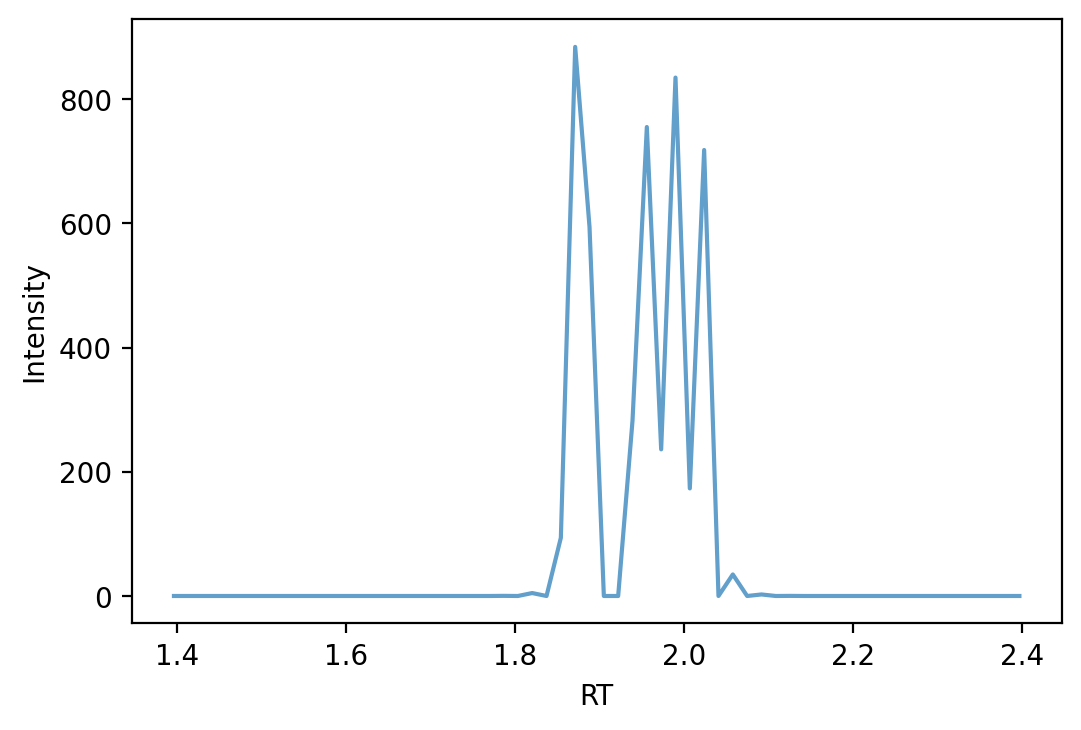

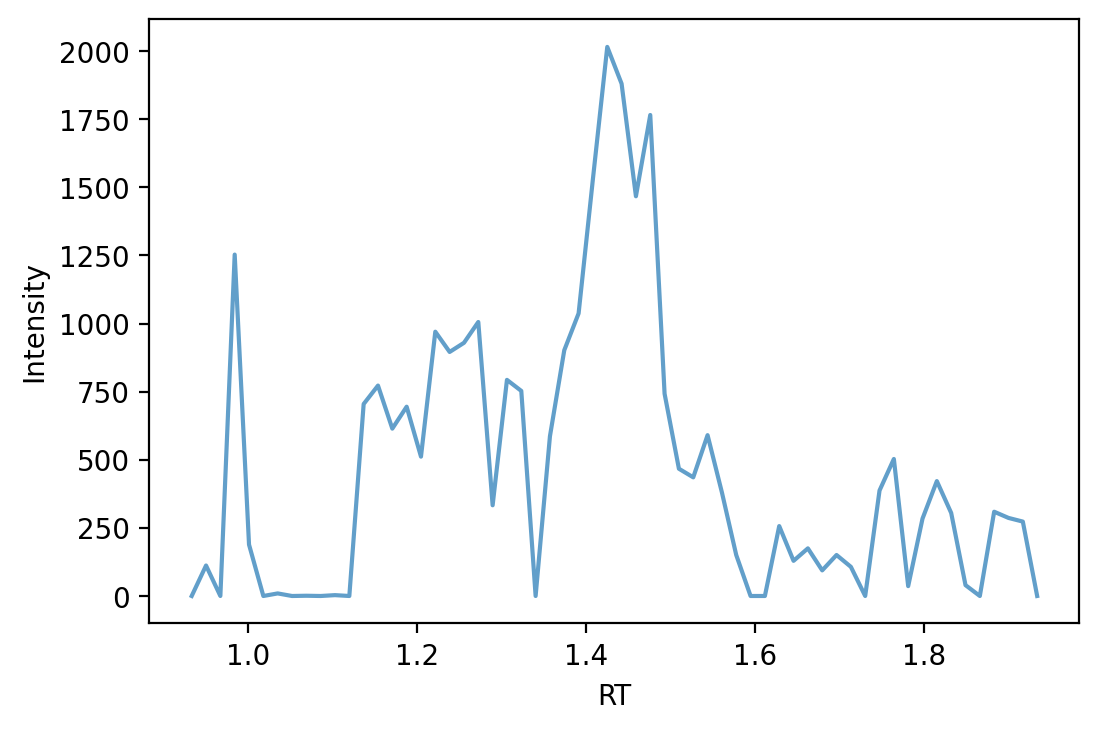

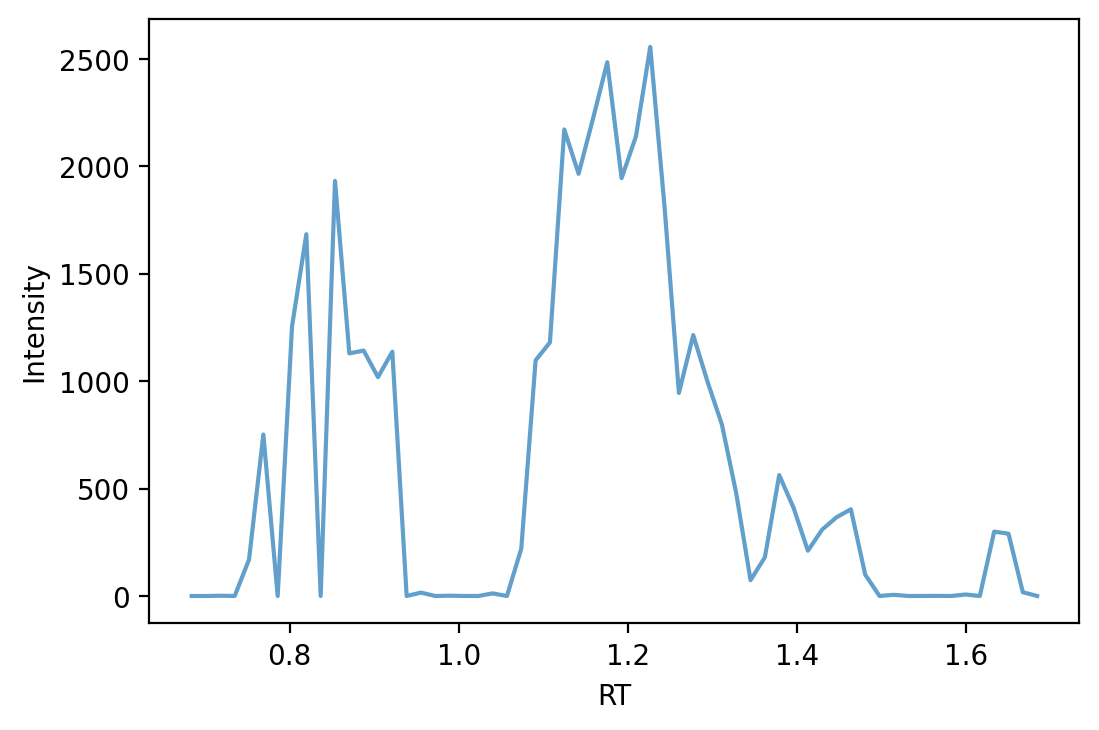

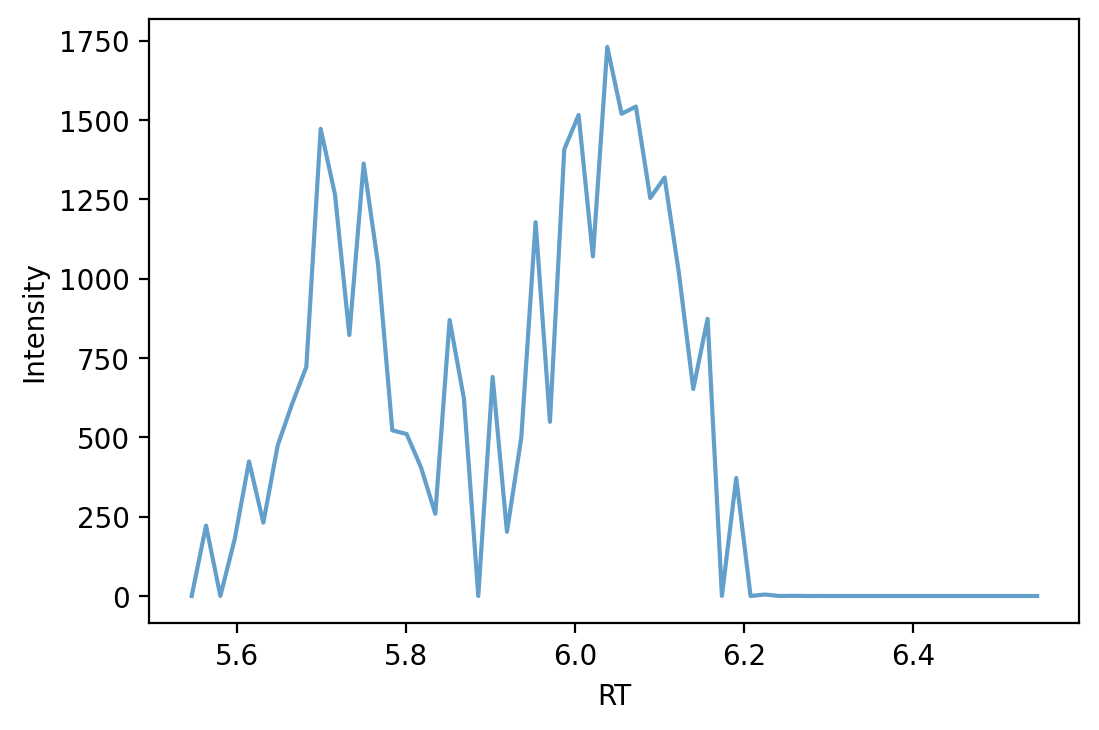

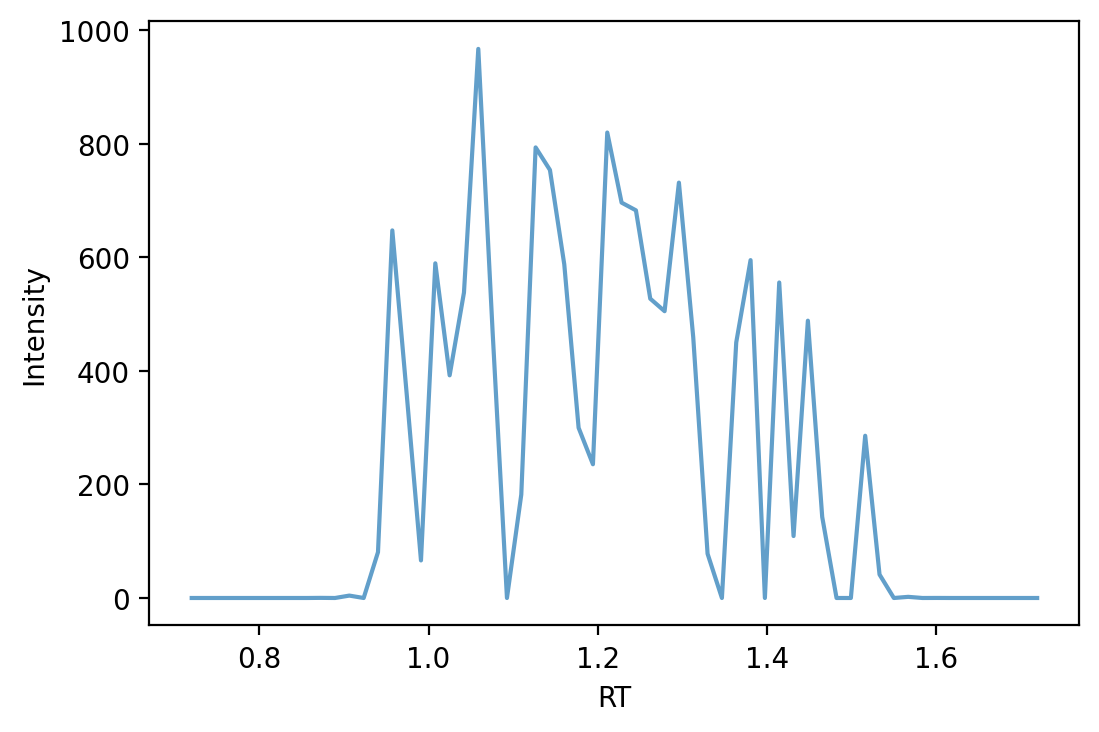

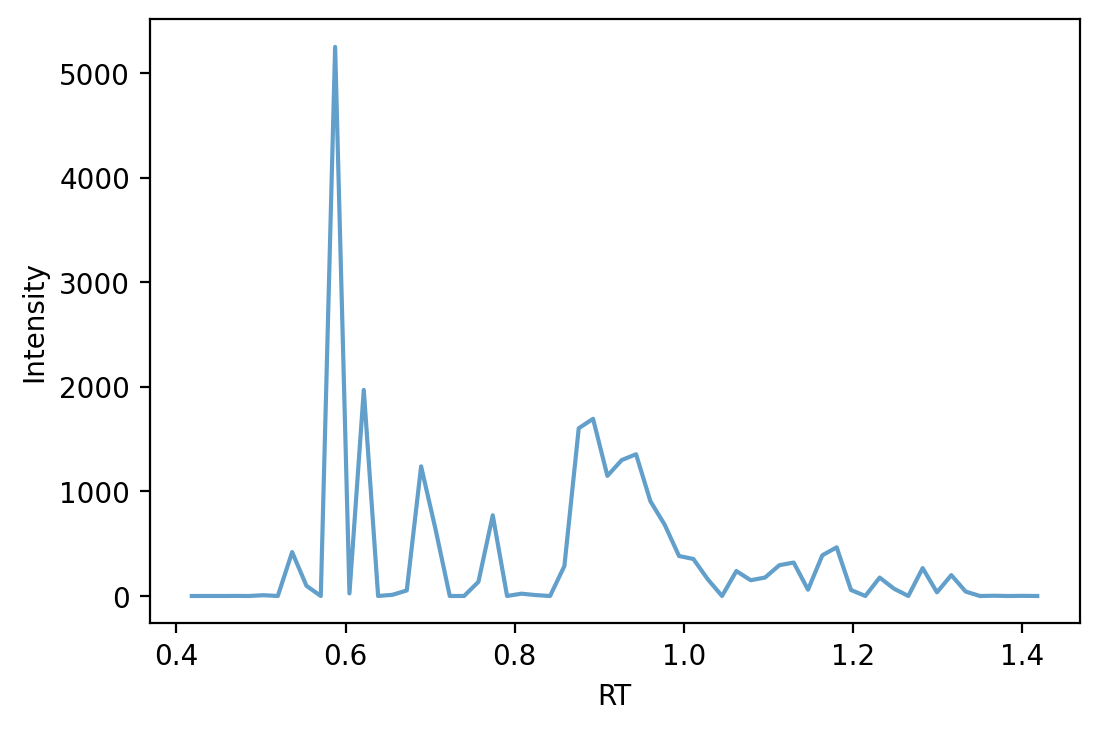

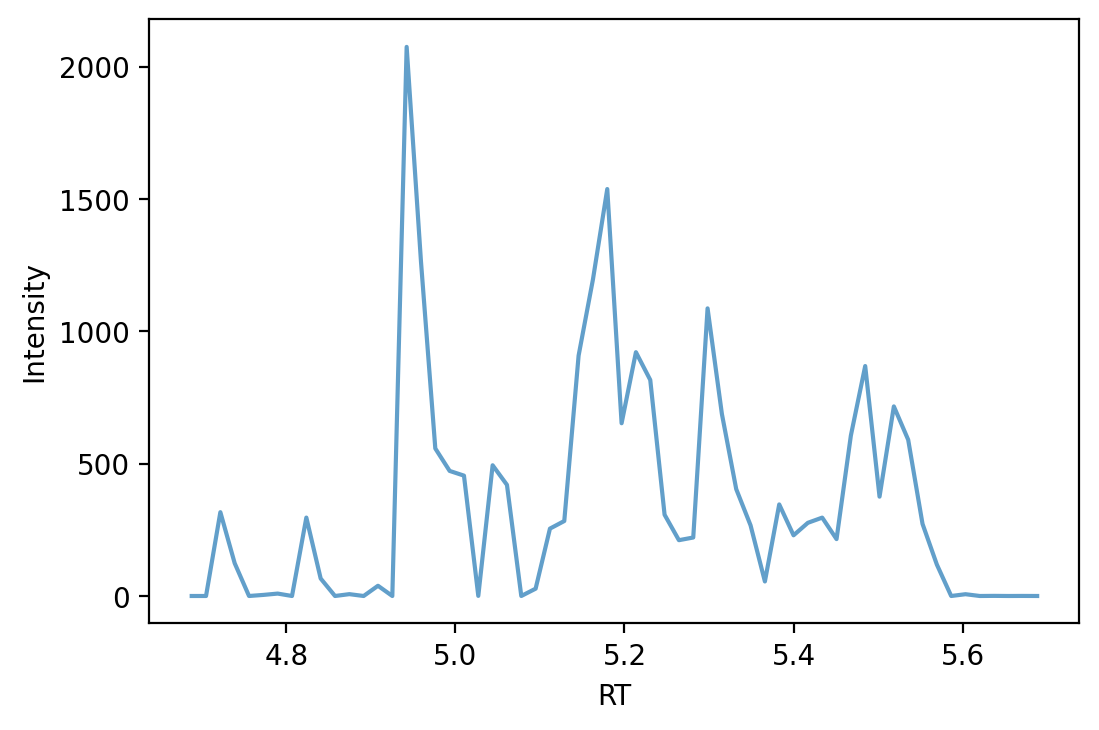

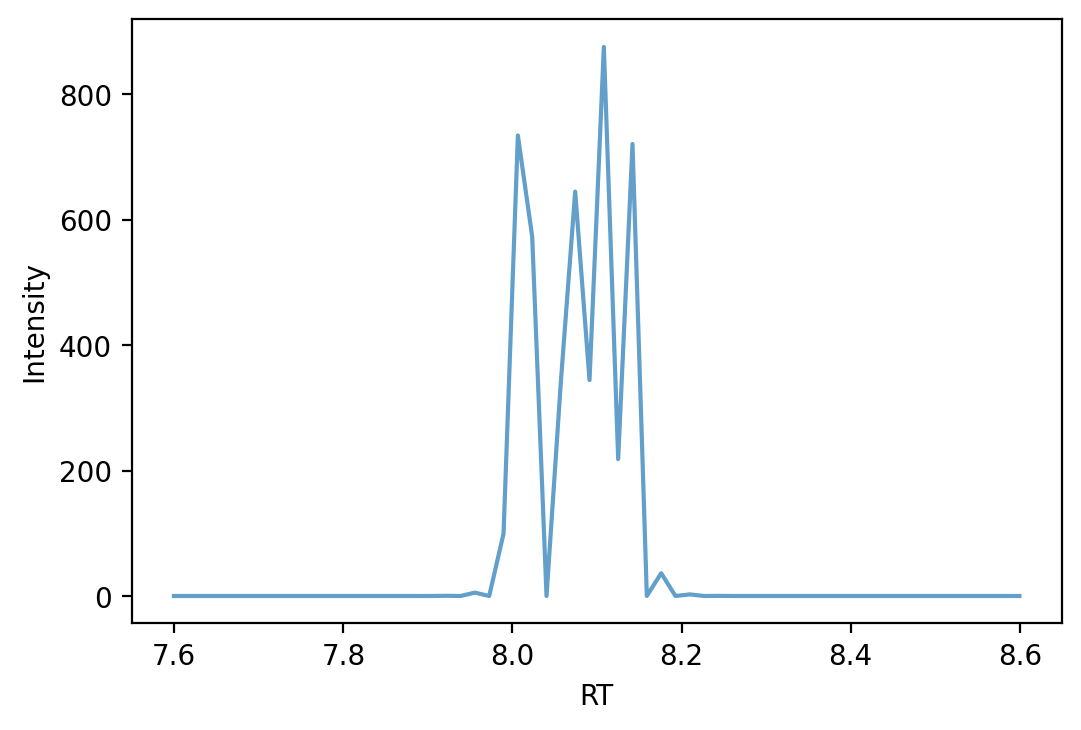

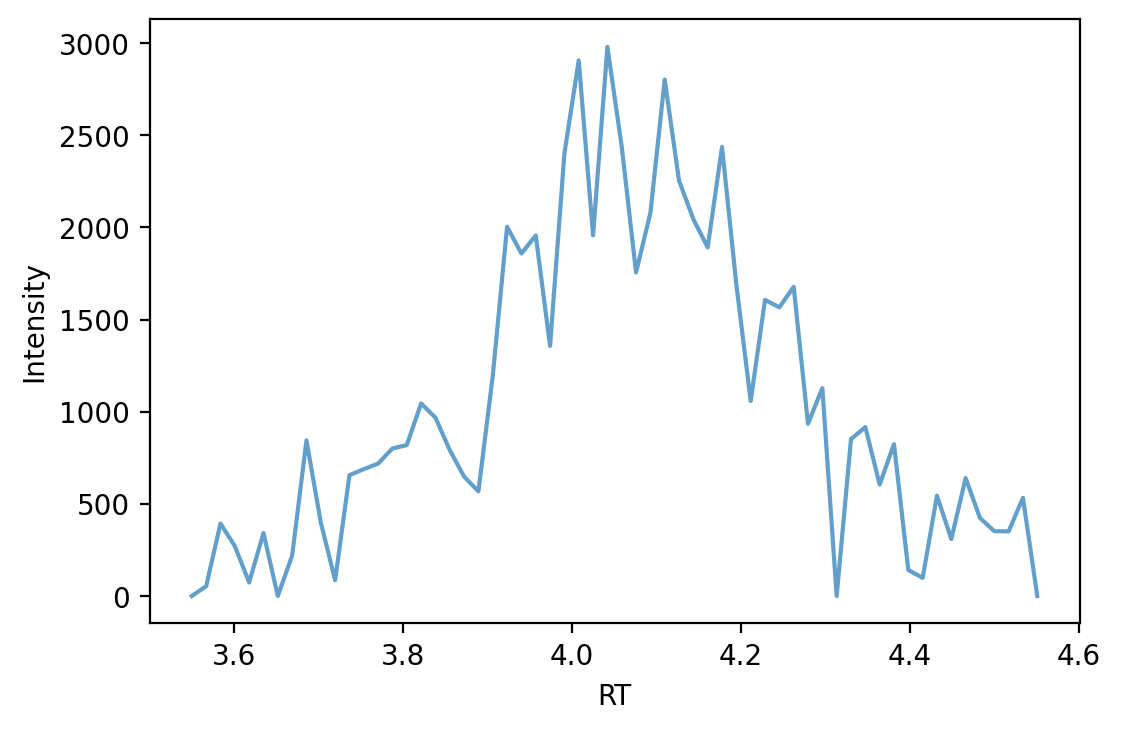

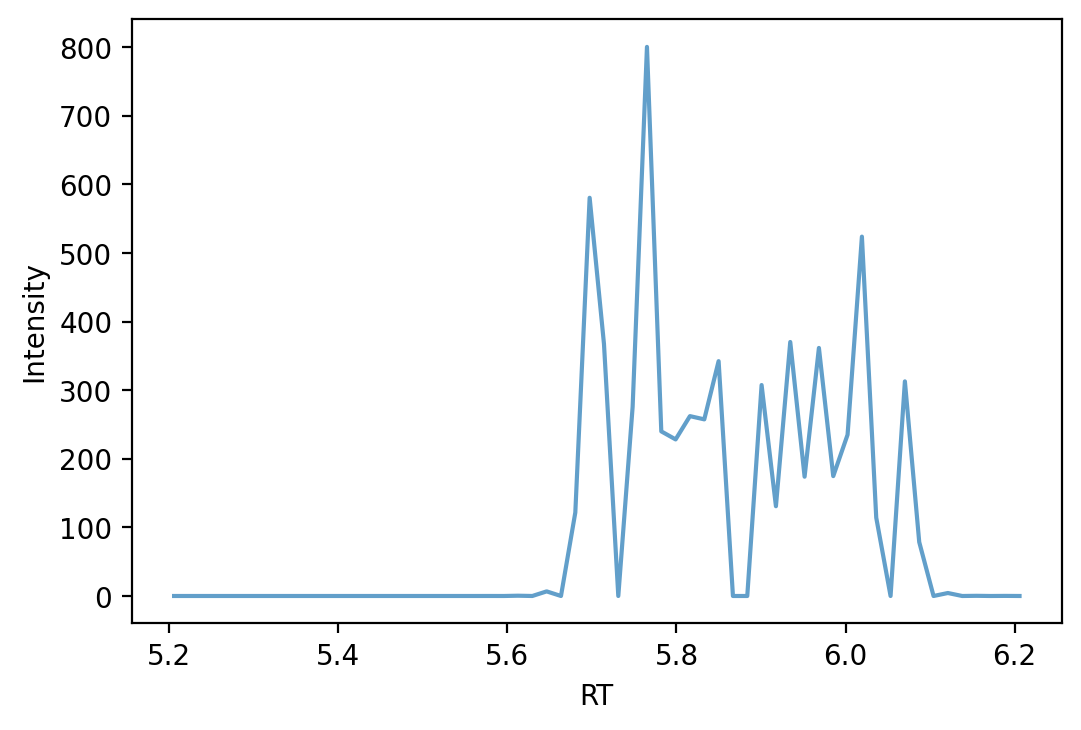

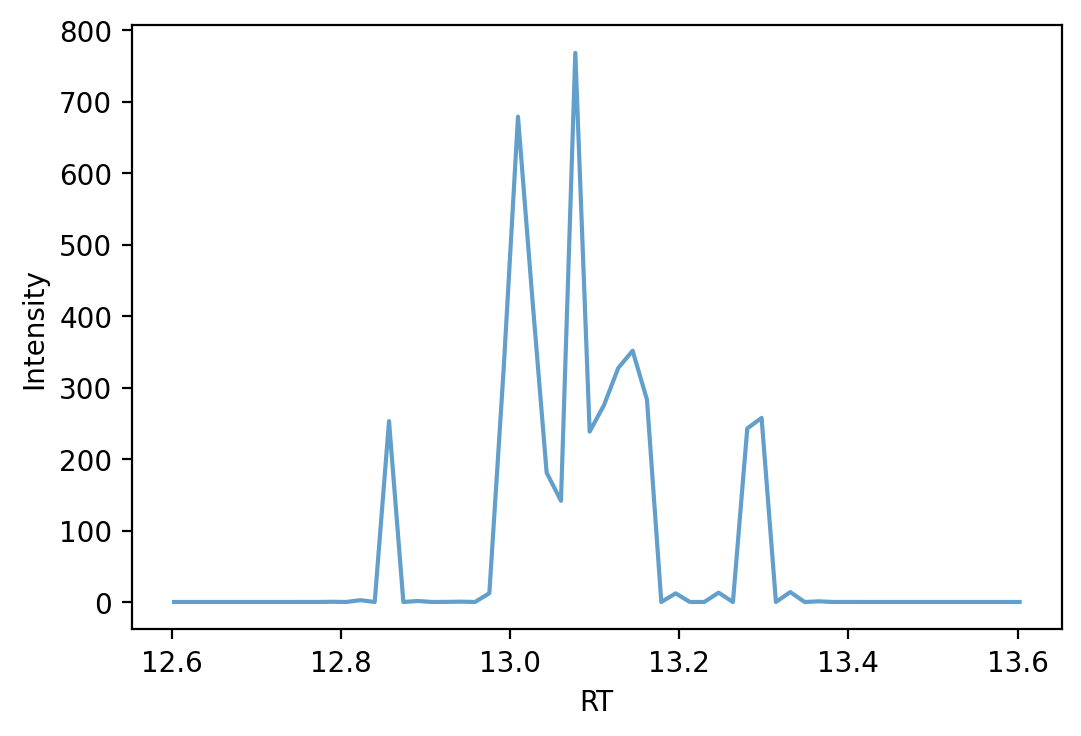

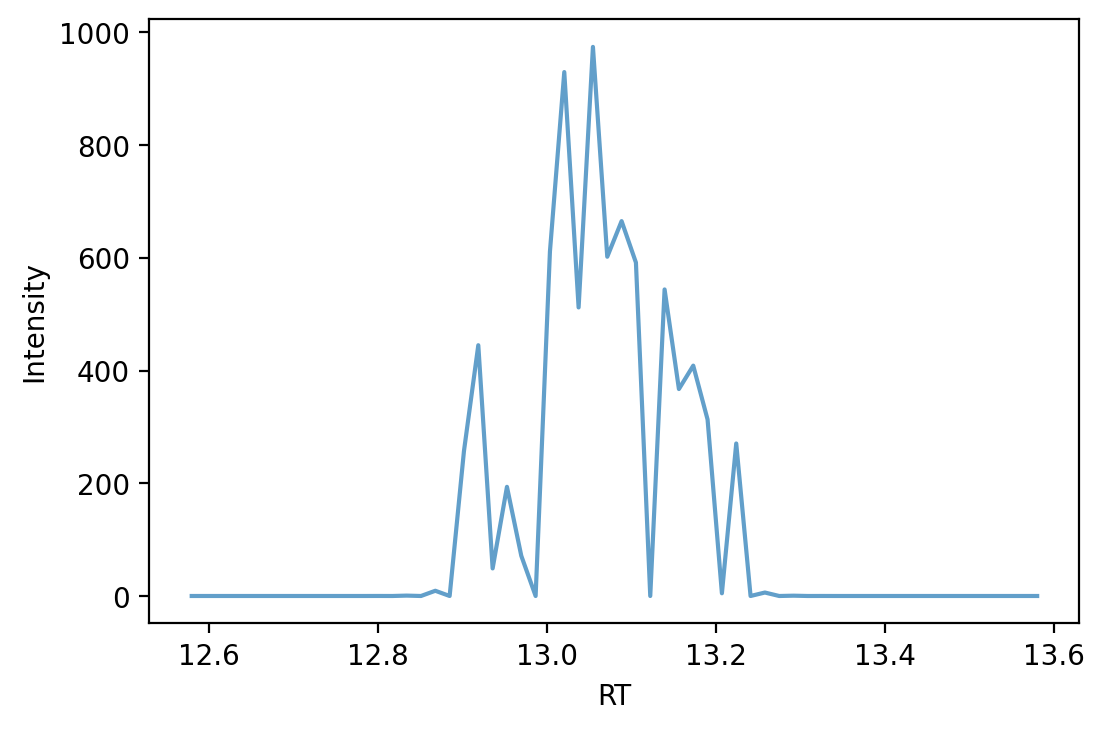

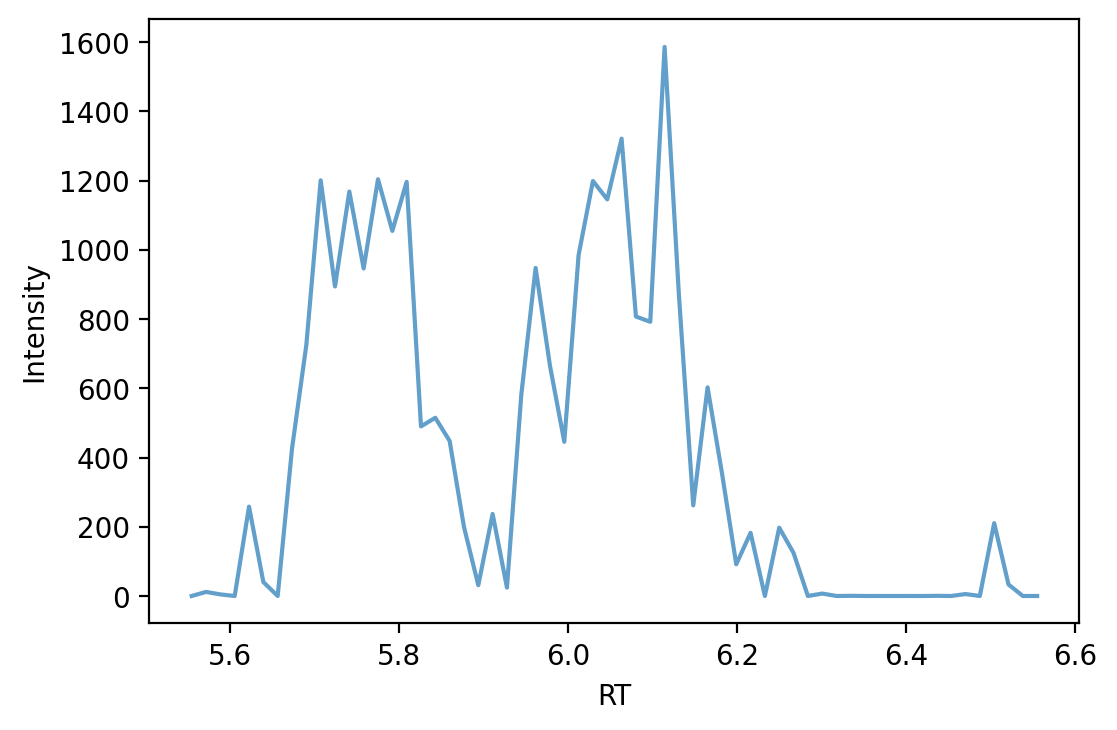

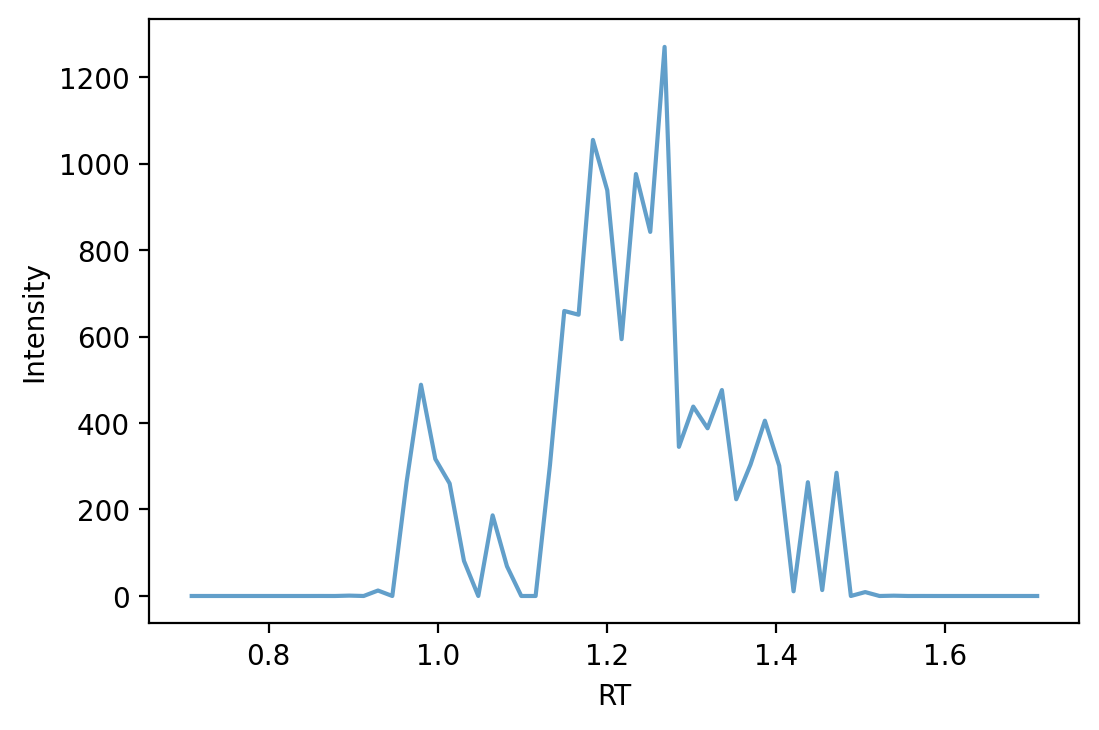

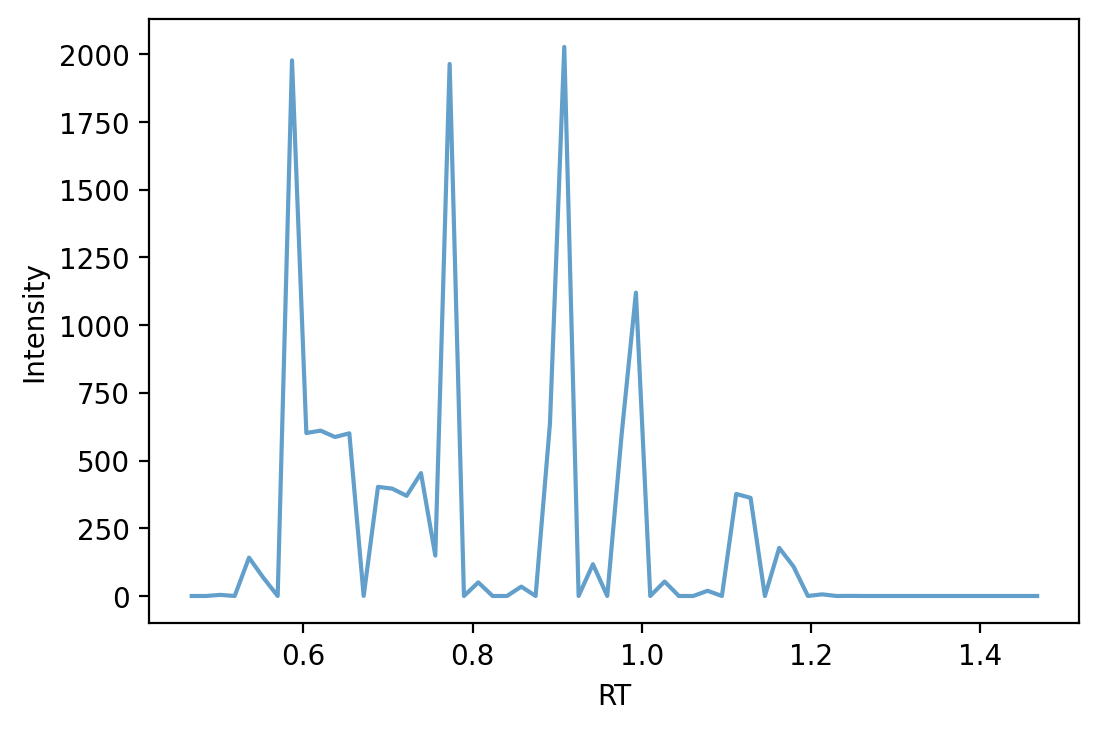

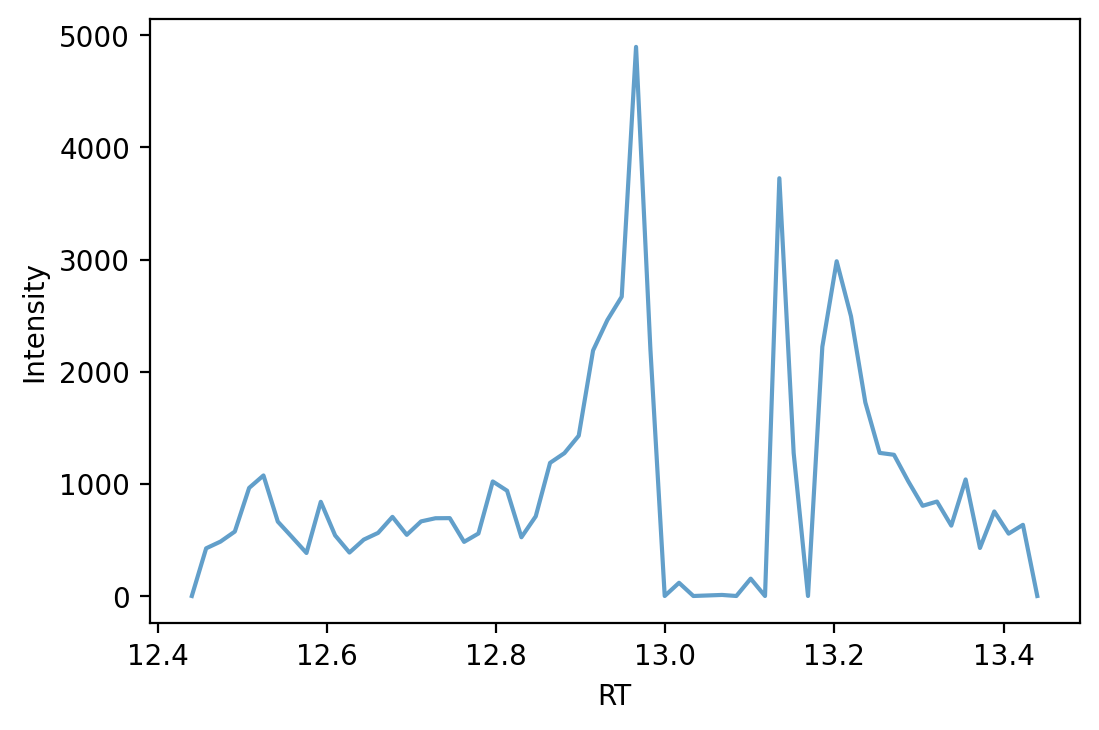

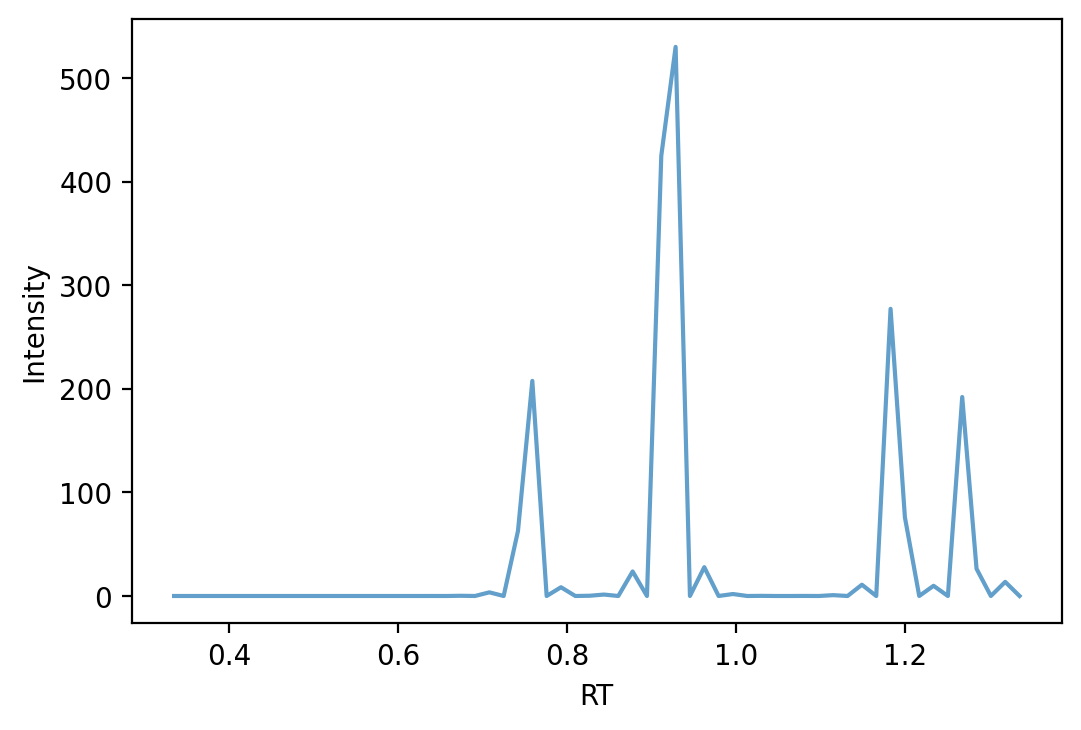

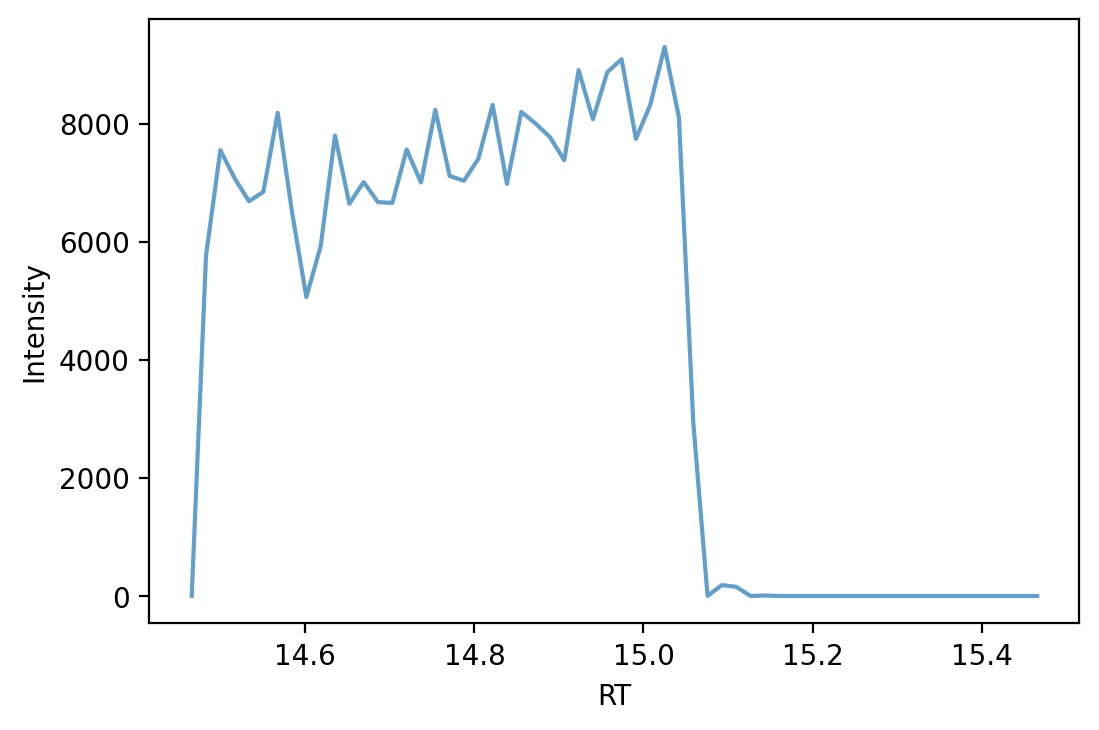

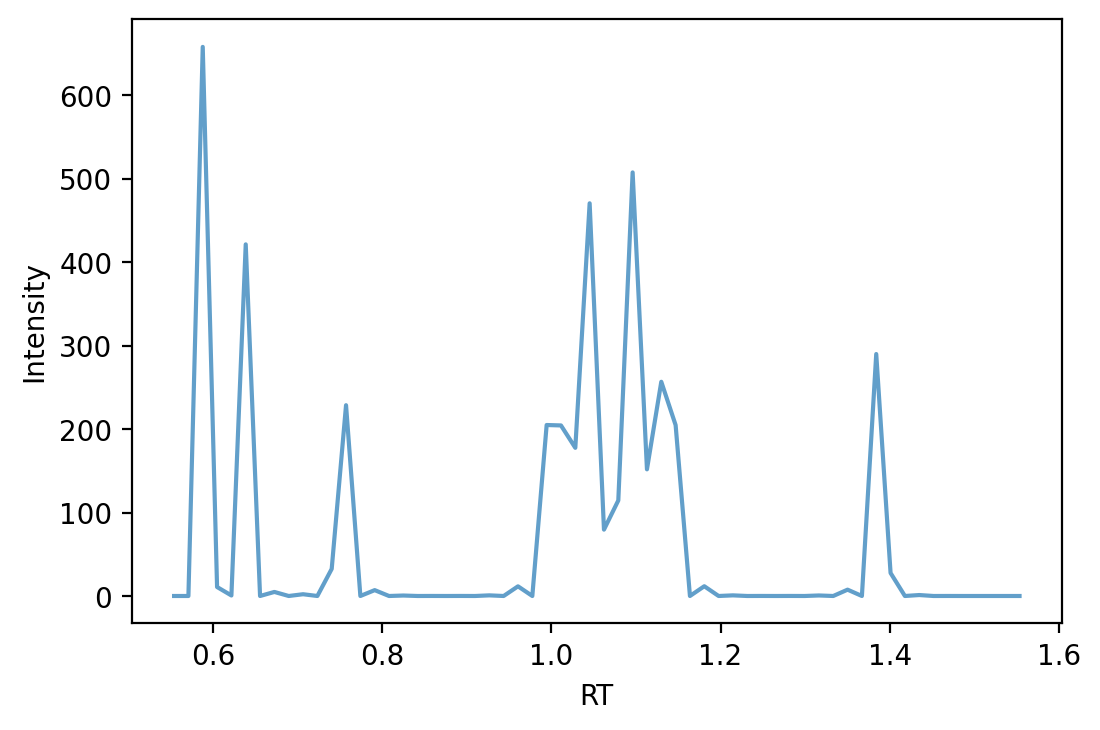

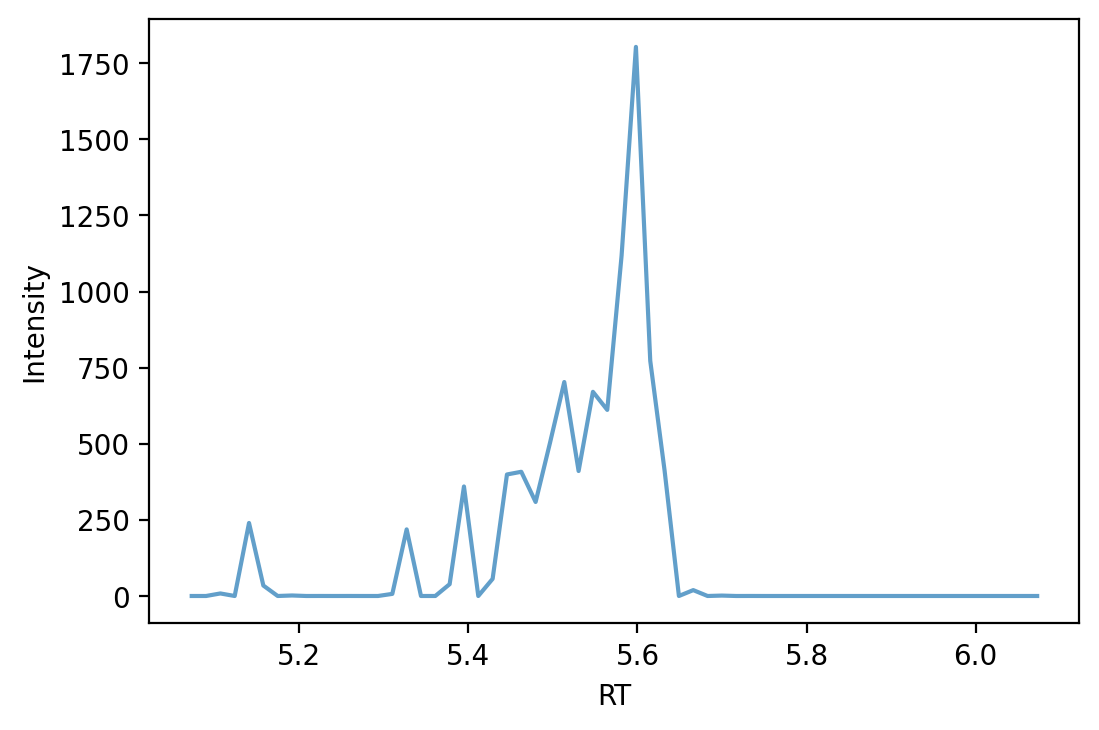

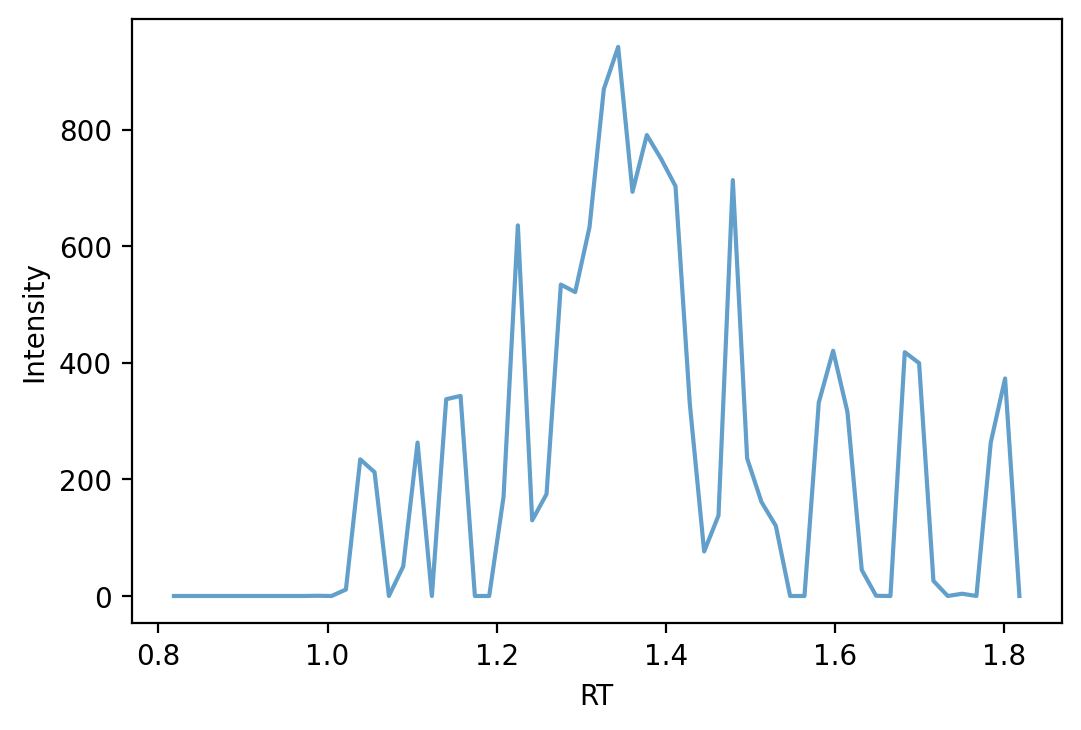

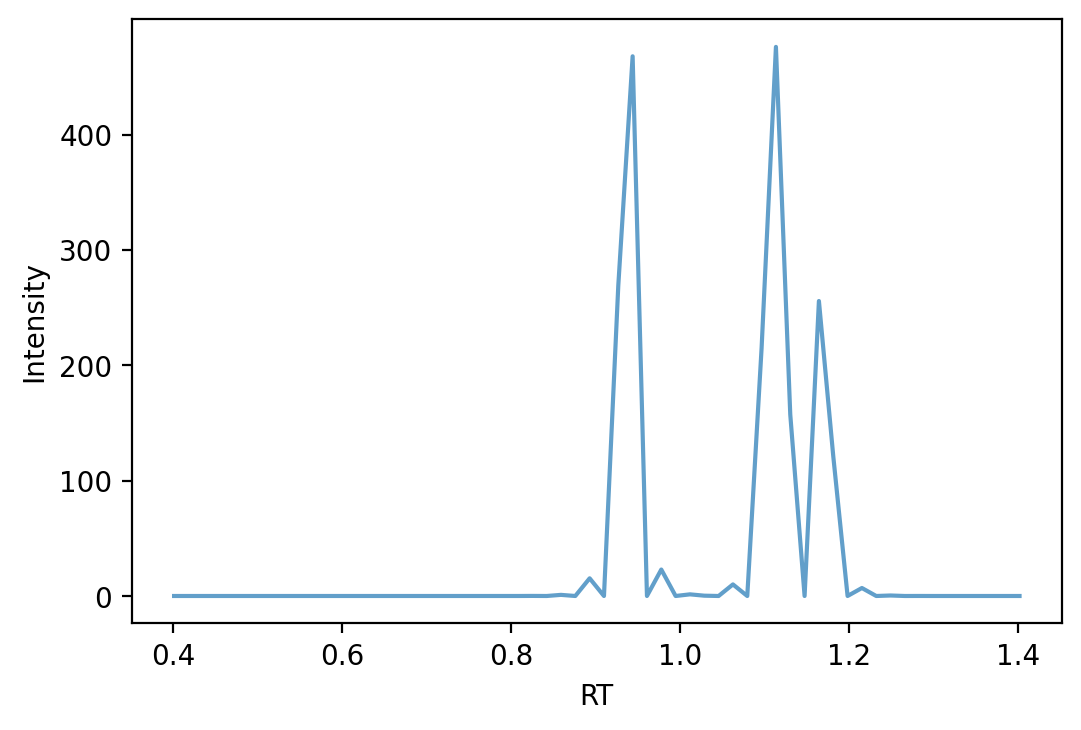

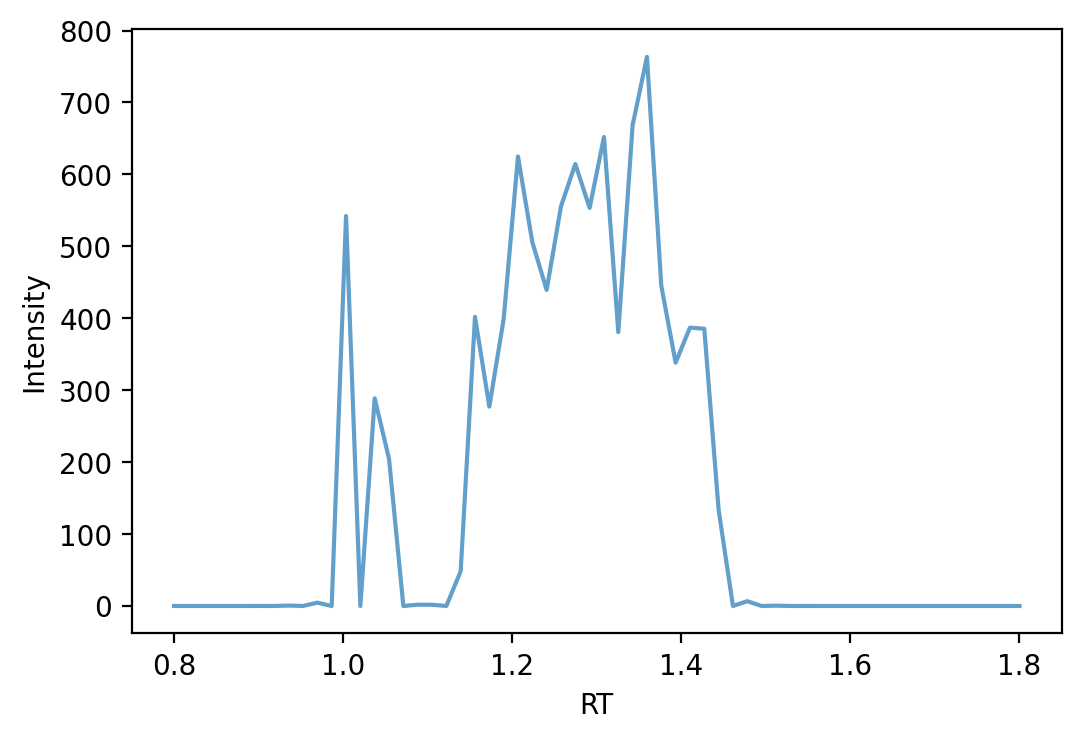

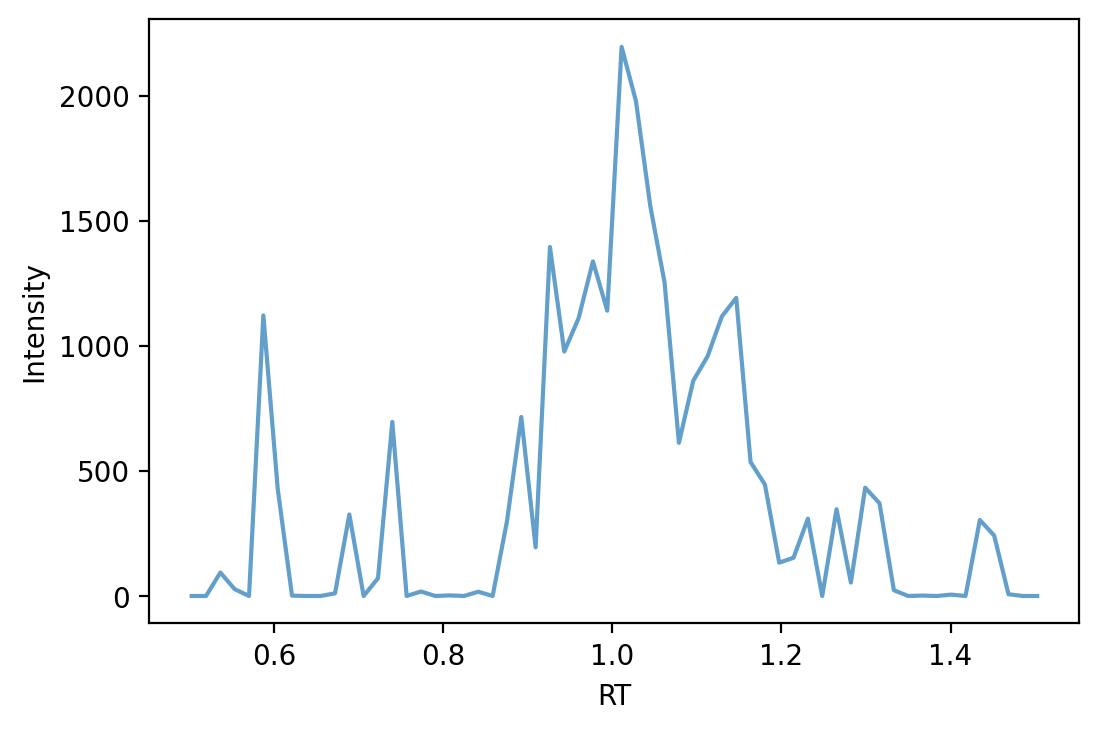

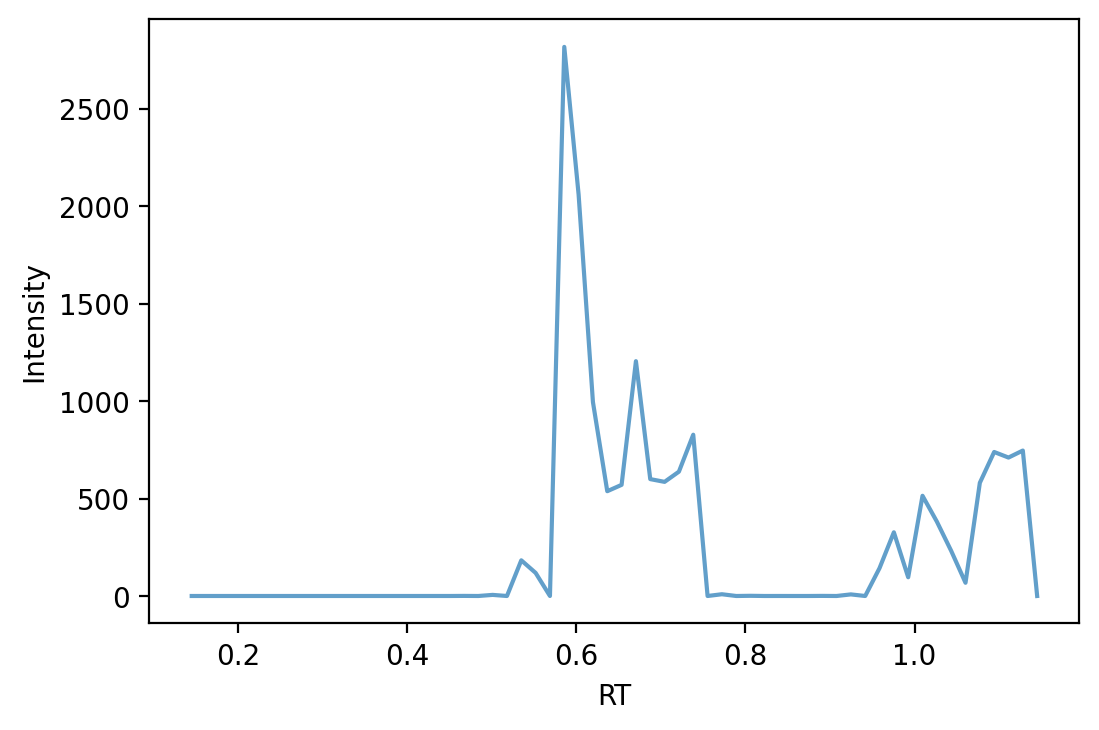

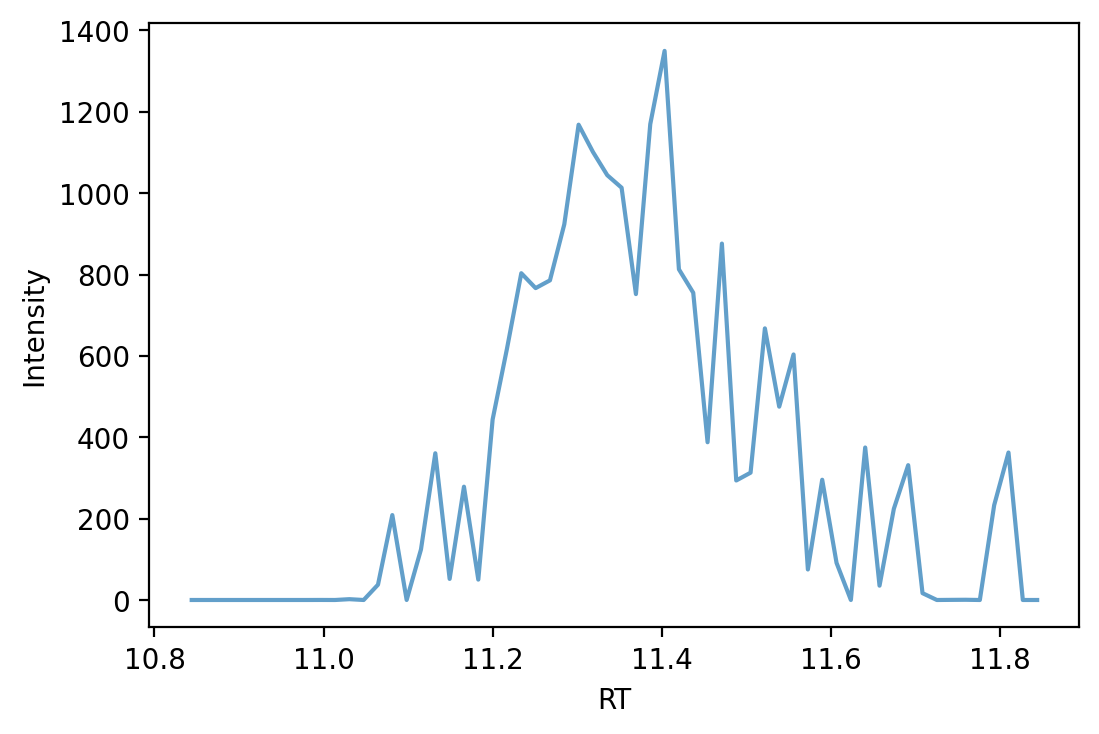

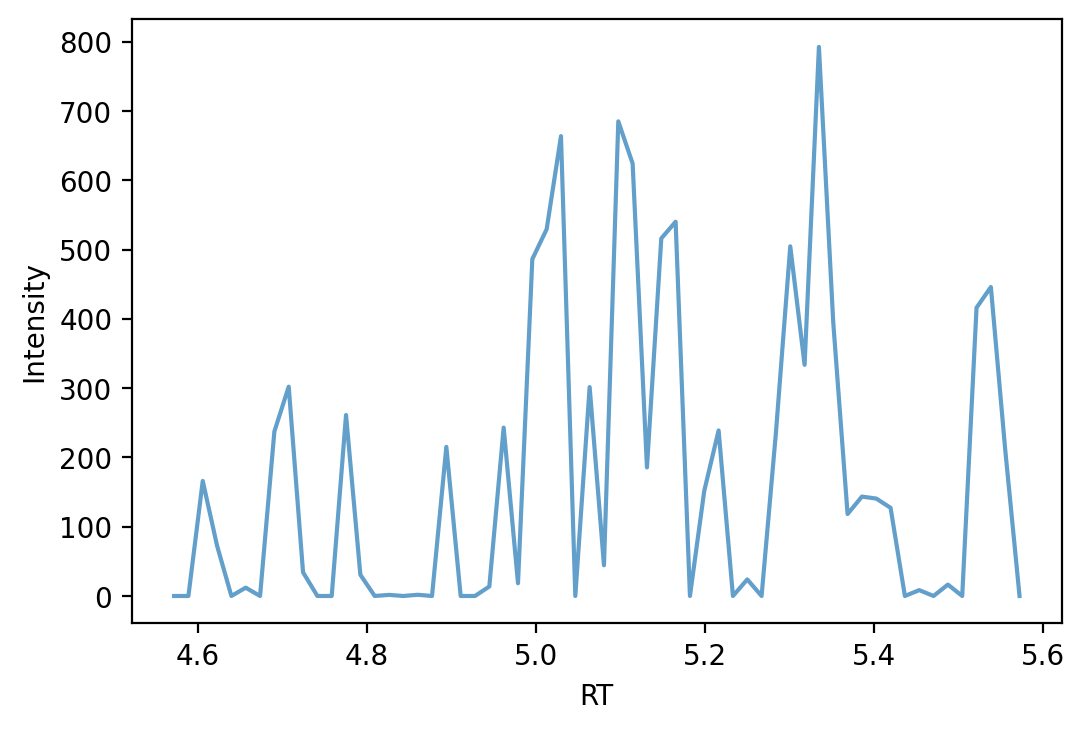

<Figure size 1200x800 with 0 Axes>

In [50]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],ms1_peaks_curated[datadir + file].at[ind,"mz"],ms1_peaks_curated[datadir + file].at[ind,"rt"]-.5,ms1_peaks_curated[datadir + file].at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

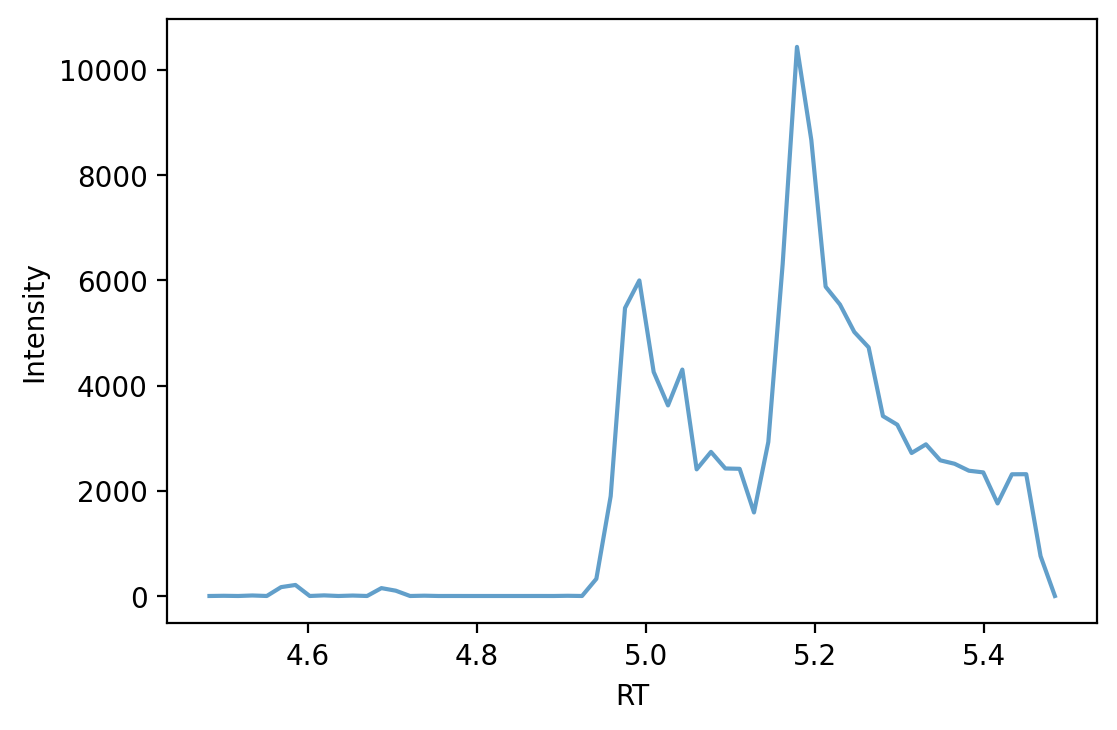

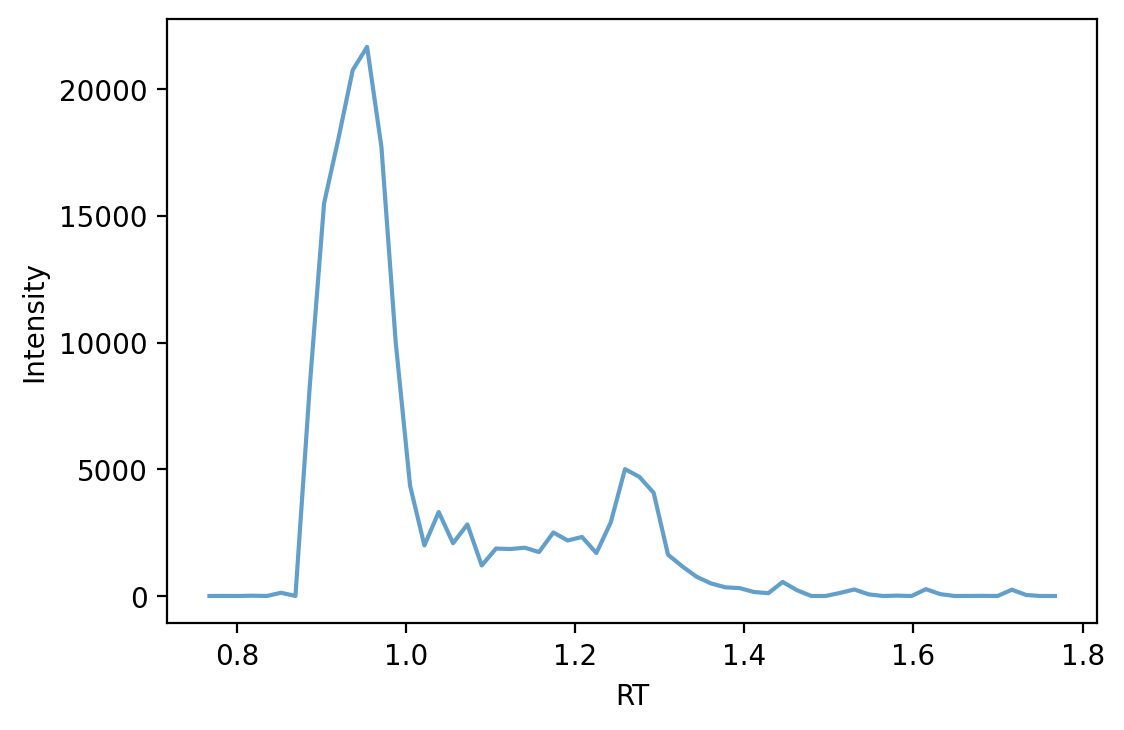

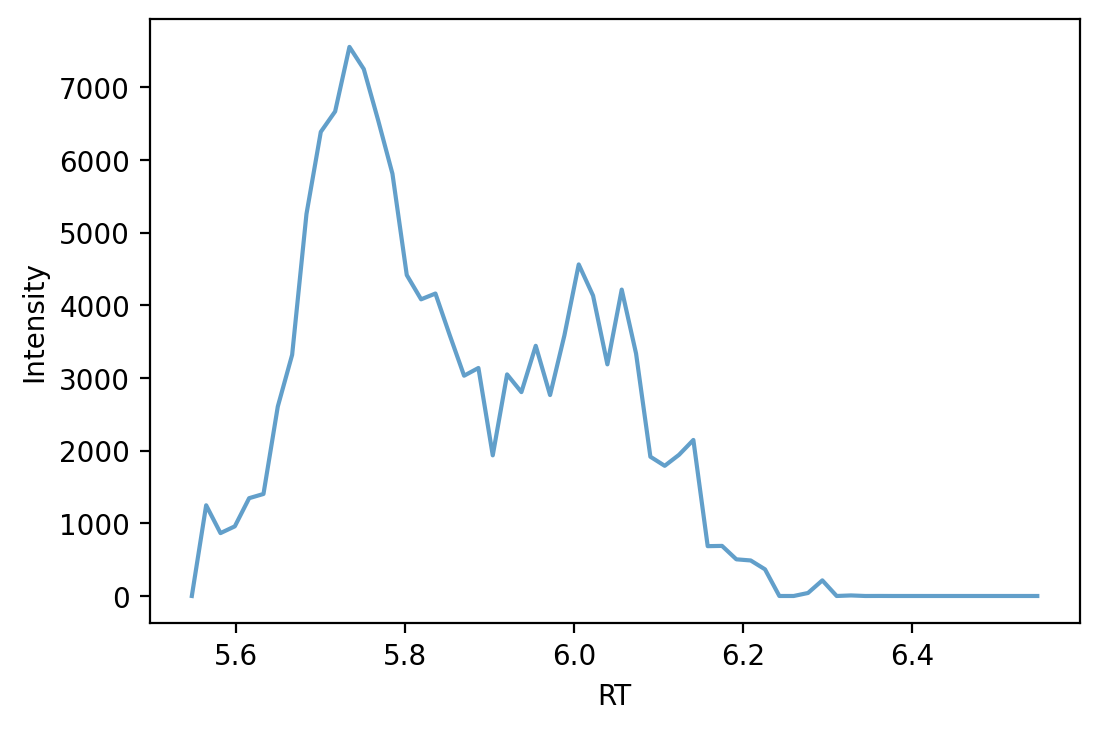

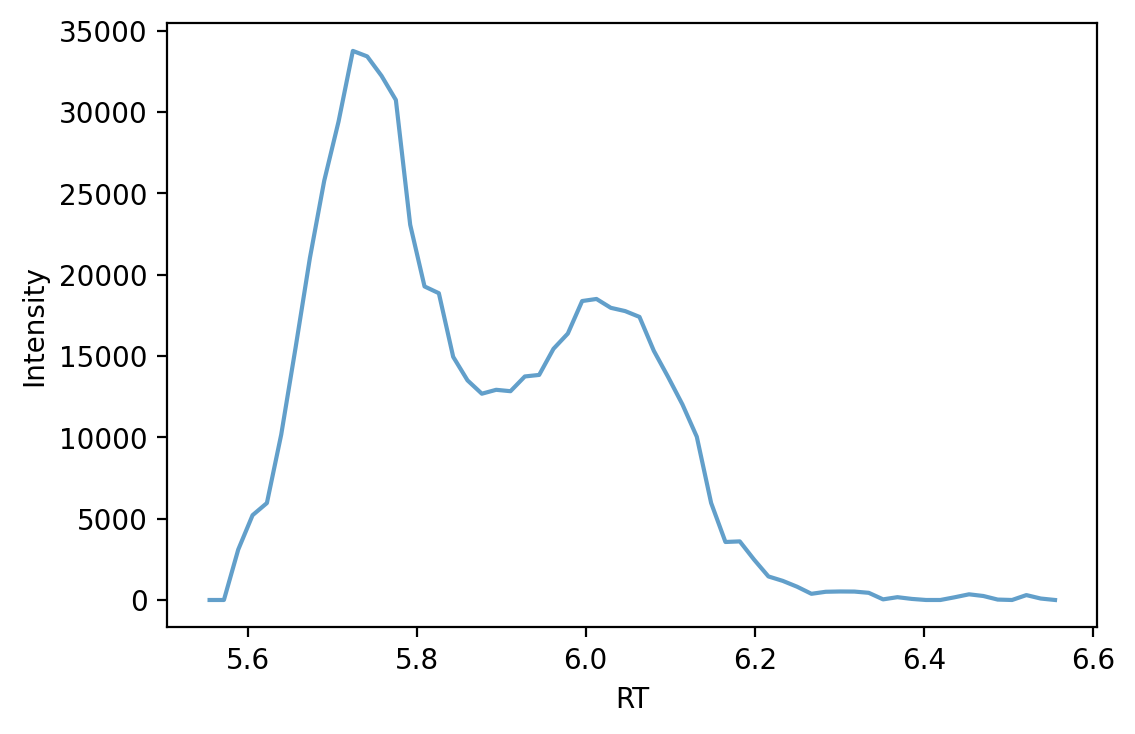

<Figure size 1200x800 with 0 Axes>

In [51]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peakList_labeled.at[ind,"mz"],peakList_labeled.at[ind,"rt"]-.5,peakList_labeled.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [52]:
peak_scores

mz         rt  ../data/covid_plasma/B1_NIST1950_1_6540.mzML  \
1       52.995260   5.082550                                      1.000000   
2       54.977009   5.083667                                      1.000000   
3       55.019199   6.030133                                      1.000000   
4       57.034543   5.399525                                      1.000000   
5       57.034540   1.583142                                      1.000000   
...           ...        ...                                           ...   
3928  1612.974731   6.589500                                      0.000000   
3929  1612.974770   2.198033                                      0.049012   
3930  1613.978781  15.015317                                      0.414235   
3931  1613.978738   2.198033                                      0.021377   
3932  1614.976147   2.198033                                      0.844933   

      ../data/covid_plasma/B1_NIST1950_2_6540.mzML  \
1                                         0.055201   
2                                         0.991856   
3                                         0.978008   
4                                         0.834973   
5                                         0.981307   
...                                            ...   
3928                                      0.052629   
3929                                      0.978893   
3930                                      0.995660   
3931                                      0.981313   
3932                                      0.986645   

      ../data/covid_plasma/B1_NIST1950_3_6540.mzML  
1                                     5.520099e-02  
2                                     9.926871e-01  
3                                     9.786588e-01  
4                                     9.343827e-01  
5                                     9.705968e-01  
...                                            ...  
3928                                  4.327918e-02  
3929                                  5.568261e-02  
3930                                  4.823959e-01  
3931                                  3.168398e-02  
3932                                  4.849239e-10  

[3932 rows x 5 columns]

0.9199

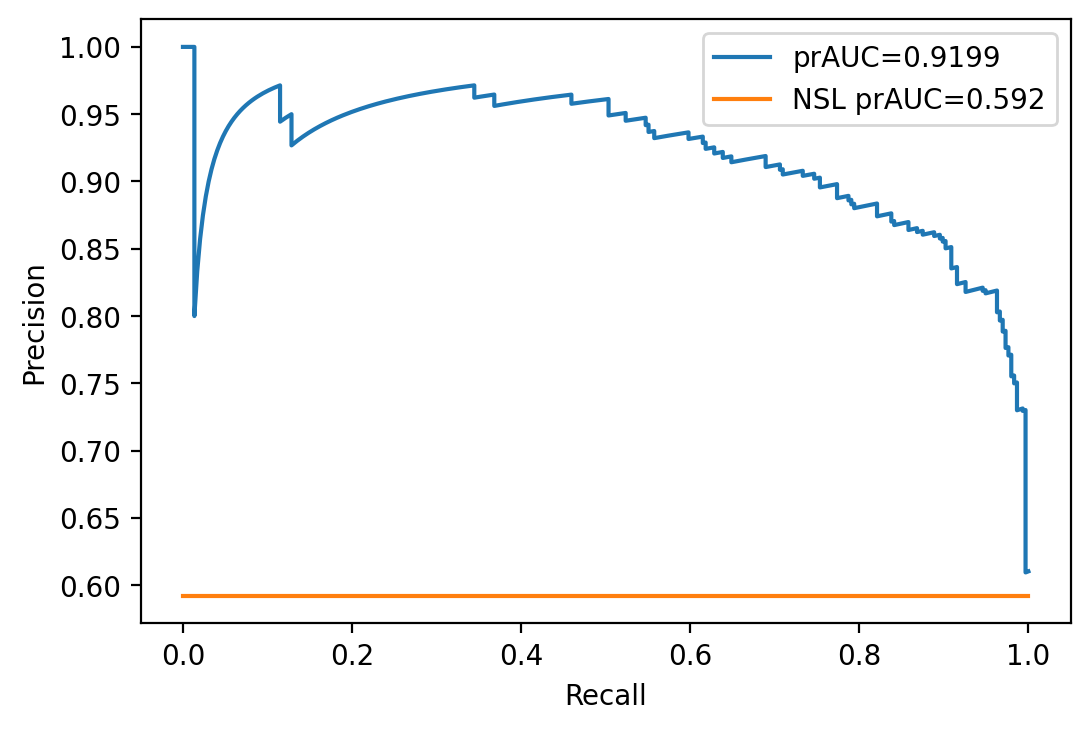

In [53]:
def makePRCPlot(pred,true,noSkill=True):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label="prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

true = []
pred = []
file = files[0]
for index,row in peakList_labeled.iterrows():
    pred.append(peak_scores.at[index,datadir+file])
    true.append(row["classification"])

makePRCPlot(pred,true)

In [23]:
if __name__ == "__main__":
    ms1_peaks_recurse = {}
    for x in range(len(files)):
        rois = integ.roiDetection(raw_data[x],intensityCutuff=1000,numDataPoints=5)
        ms1_peaks_recurse[files[x]] = integ.detectPeaks(raw_data[x],rois,window=10,cutoff = 0.99,noiseCutoff=4.0)
        

Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1833 ROIs found
1832  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 


c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:629: RuntimeWarning: divide by zero encountered in log10
  ticsOrig = np.log10(np.array([np.sum(x) for x in X]))
c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\PeakDetective\__init__.py:629: RuntimeWarning: invalid value encountered in log10
  ticsOrig = np.log10(np.array([np.sum(x) for x in X]))


done,  239992  EICs generated
smoothing EICs...
7500/7500 [==============================] - 26s 3ms/step
done
classifying peaks...
7500/7500 [==============================] - 13s 2ms/step
done
2335  peaks found
Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1656 ROIs found
1658  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done,  217198  EICs generated
smoothing EICs...
6788/6788 [==============================] - 19s 3ms/step
done
classifying peaks...
6788/6788 [==============================] - 12s 2ms/step
done
2098  peaks found
Detecting ROIs |█████████████████████████████████████████████████-| 99.8% 1670 ROIs found
1670  ROIs found
generating all EICs from ROIs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done,  218770  EICs generated
smoothing EICs...
6837/6837 [==============================] - 18s 3ms/step
done
classifying peaks...
6837/6837 

In [24]:
ms1_peaks_recurse

{'B1_NIST1950_1_6540.mzML':                mz         rt     score
 0       52.979819   5.056117  1.000000
 1       54.977003   5.056117  1.000000
 2       56.995793   0.722783  0.995805
 3       56.995793  13.056117  0.999964
 4       56.995793  17.389450  0.998500
 ...           ...        ...       ...
 2330  1055.866116   0.722783  0.999777
 2331  1055.866116  17.222783  0.994422
 2332  1055.866116  17.389450  0.999985
 2333  1069.285711   7.389450  1.000000
 2334  1612.974541   0.556117  0.998066
 
 [2335 rows x 3 columns],
 'B1_NIST1950_2_6540.mzML':                mz         rt     score
 0       52.979808   5.053433  1.000000
 1       54.976993   5.053433  1.000000
 2       56.995805   0.720100  0.999738
 3       56.995805  13.053433  0.999911
 4       56.995805  16.720100  0.990361
 ...           ...        ...       ...
 2093  1069.285104   7.553433  0.999997
 2094  1612.974279   2.220100  0.999987
 2095  1612.974279  15.053433  1.000000
 2096  1613.977752   2.220100  0.99999

In [25]:

#X_tot = self.makeDataMatrix([rawData],rois,rt_starts,rt_ends,0)
if __name__ == "__main__":

    uniqueFeatures = {}
    mzTol = 20
    rtTol = 10/60

    labels = []
    X_all = []

    for x in range(len(files)):
        print(x)
        xcms_peaks_curated = ms1_peaks_curated[datadir + files[x]]
        tmp = [x for x in peakList.index.values if x not in xcms_peaks_curated.index.values]
        xcms_peaks_not_curated = peakList.loc[tmp,:]
        inXCMS = []
        for index,row in ms1_peaks_recurse[files[x]].iterrows():
            minMz = row["mz"] - mzTol * row["mz"] / 1e6
            maxMz = row["mz"] + mzTol * row["mz"] / 1e6
            unique = True
            for index2,row2 in peakList.iterrows():
                if row2["mz"] > minMz and row2['mz'] < maxMz:
                    if np.abs(row2["rt"] - row["rt"]):
                        unique = False
                        break

            inXCMS.append(not unique)

        ms1_peaks_recurse[files[x]]["found in xcms"] = inXCMS

        newFeats = ms1_peaks_recurse[files[x]][ms1_peaks_recurse[files[x]]["found in xcms"] == False]

        tmp = integ.makeDataMatrix([raw_data[x]],xcms_peaks_not_curated["mz"].values,xcms_peaks_not_curated["rt"].values - .5, xcms_peaks_not_curated["rt"].values + .5)
        X_all += list(tmp)
        labels += [0 for _ in range(len(tmp))]

        tmp = integ.makeDataMatrix([raw_data[x]],xcms_peaks_curated["mz"].values,xcms_peaks_curated["rt"].values - .5, xcms_peaks_curated["rt"].values + .5)
        X_all += list(tmp)
        labels += [1 for _ in range(len(tmp))]

        tmp = integ.makeDataMatrix([raw_data[x]],newFeats["mz"].values,newFeats["rt"].values - .5, newFeats["rt"].values + .5)
        X_all += list(tmp)
        labels += [2 for _ in range(len(tmp))]

0
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
1
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
2
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 
forming matrix |██████████████████████████████████████████████████| 100.0% 


In [26]:
X_all_norm = integ.smoother.predict(normalizeMatrix(X_all))

394/394 [==============================] - 4s 9ms/step


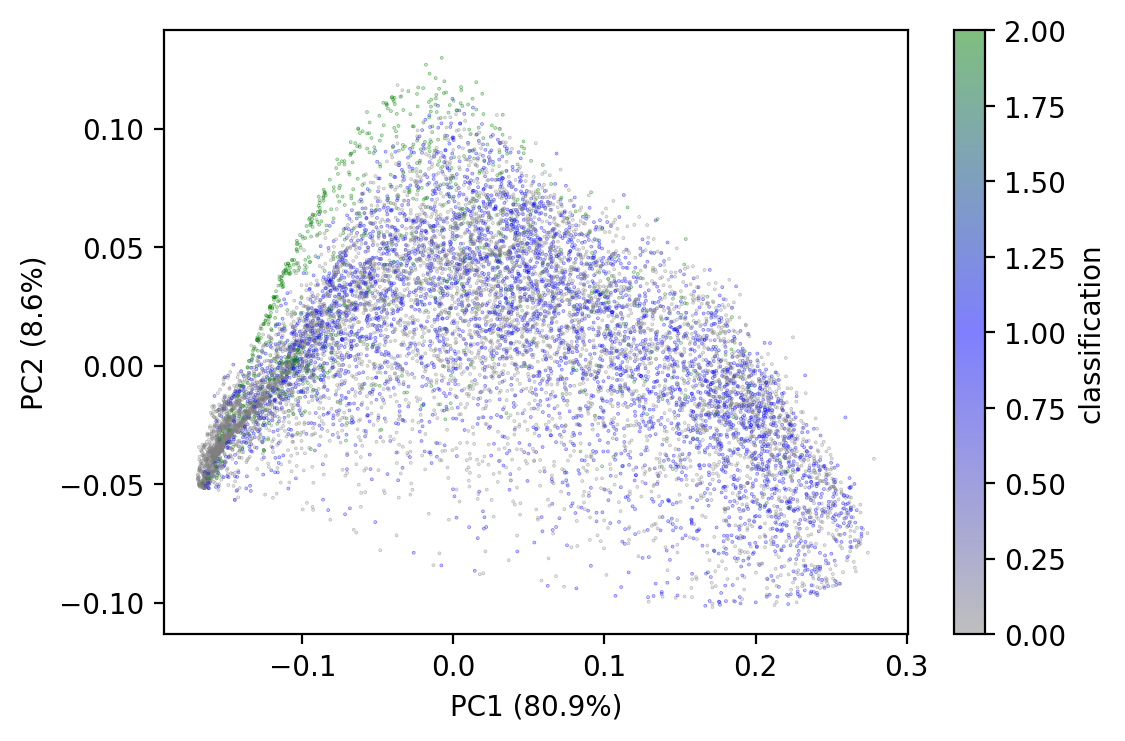

In [27]:
pca = PCA(2)
loads = pca.fit_transform(X_all_norm)
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue","green"],N=256)
plt.scatter(loads[:,0],loads[:,1],c=labels,s=.1,alpha=.5,cmap=colormap)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
plt.colorbar(label="classification")
#plt.xlim((-2,2))
#plt.ylim((-2,2))

XCMS artifact  XCMS true peak  \
sample                                                   
B1_NIST1950_1_6540.mzML      29.016160       64.424905   
B1_NIST1950_2_6540.mzML      77.732600       16.311887   
B1_NIST1950_3_6540.mzML      77.346355       16.317294   

                         PeakDetective recovered  
sample                                            
B1_NIST1950_1_6540.mzML                 6.558935  
B1_NIST1950_2_6540.mzML                 5.955513  
B1_NIST1950_3_6540.mzML                 6.336351

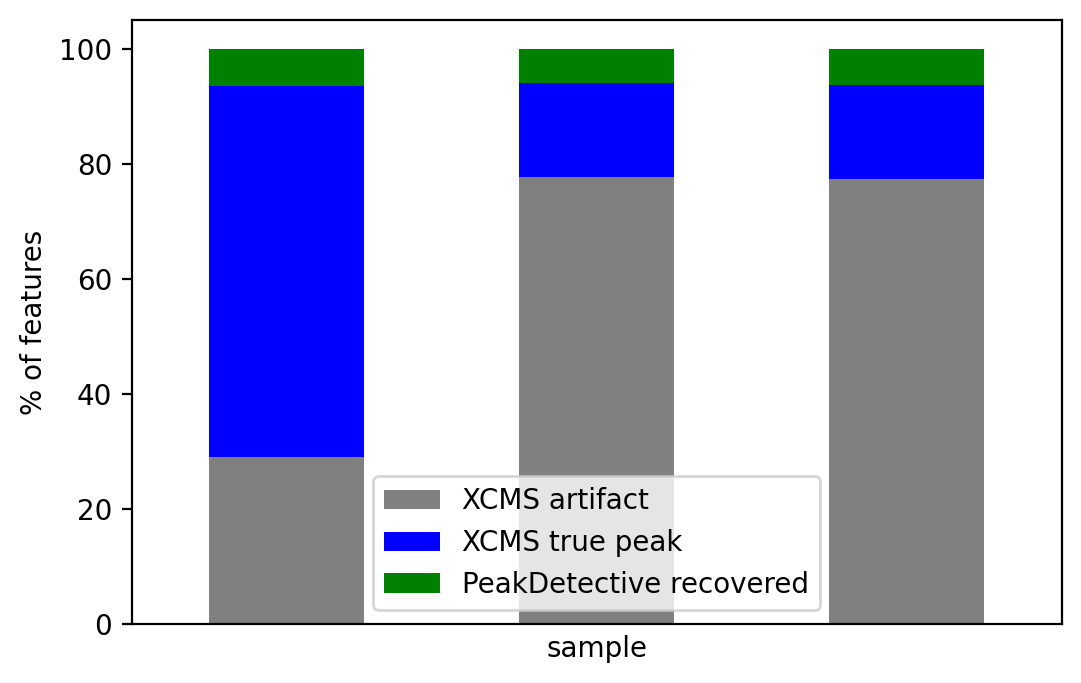

In [28]:
df = {}
for x in range(len(files)):
    xcms_peaks_curated = ms1_peaks_curated[datadir + files[x]]
    tmp = [x for x in peakList.index.values if x not in xcms_peaks_curated.index.values]
    xcms_peaks_not_curated = peakList.loc[tmp,:]
    for _ in range(len(xcms_peaks_not_curated)):
        df[len(df)] = {"sample":files[x],"classification":"XCMS artifact"}

    tmp = ms1_peaks_curated[datadir + files[x]]
    for _ in range(len(tmp)):
        df[len(df)] = {"sample":files[x],"classification":"XCMS true peak"} 
        
    tmp = ms1_peaks_recurse[files[x]][ms1_peaks_recurse[files[x]]["found in xcms"] == False]
    for _ in range(len(tmp)):
        df[len(df)] = {"sample":files[x],"classification":"PeakDetective recovered"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue","green"])
plt.xticks([],[])
plt.ylabel("% of features")
aggregate('sample','classification',df)

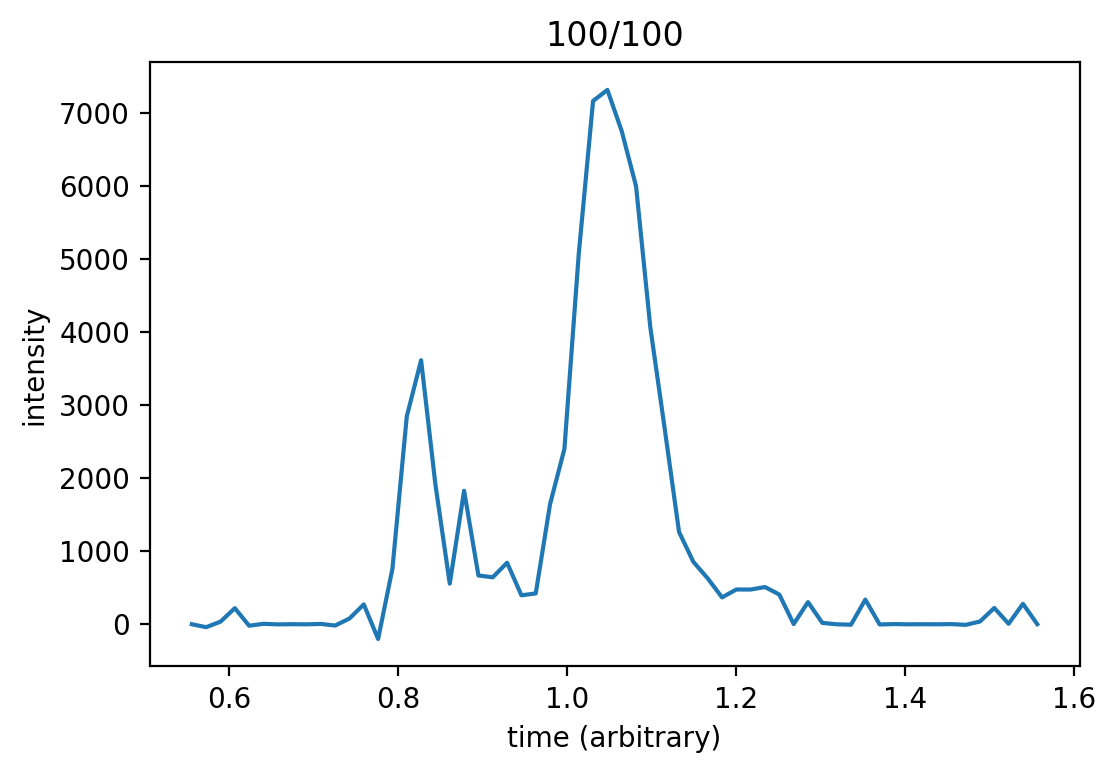

Enter classification (1=True Peak, 0=Artifact): 


 1


In [29]:
if __name__ == "__main__":
    tmp = ms1_peaks_recurse[files[0]][ms1_peaks_recurse[files[0]]["found in xcms"] == False]
    inds = list(tmp.index.values)
    inds = rd.sample(inds,100)
    tmp = tmp.loc[inds,:]
    print(tmp)
    peakList_recurse_labeled = integ.label_peaks(raw_data[0],tmp)

In [30]:
peakList_recurse_labeled[peakList_recurse_labeled["classification"] < 0.5]

mz         rt     score  found in xcms  classification
671   183.101938   0.889450  0.999936          False             0.0
944   224.091343   1.222783  0.999985          False             0.0
394   140.986248   0.722783  0.999541          False             0.0
1376  311.168491   6.056117  0.996280          False             0.0
116    96.967241   9.556117  0.998651          False             0.0
104    94.985560  14.889450  0.999999          False             0.0
766   196.890000   8.056117  1.000000          False             0.0
366   136.040817   1.222783  0.999137          False             0.0
1510  351.166765   1.056117  0.999948          False             0.0
100    94.985560  12.556117  0.999330          False             0.0
270   123.056417   0.722783  0.999914          False             0.0
1637  397.167468   1.222783  0.999038          False             0.0
805   203.091725   5.222783  0.998107          False             0.0
842   207.065515   1.056117  0.999993          False             0.0
1265  287.186228   1.222783  0.998733          False             0.0
1942  503.339778   0.889450  1.000000          False             0.0
1449  334.206387   0.889450  0.999941          False             0.0
1584  377.194963   0.889450  0.999999          False             0.0

In [31]:
true = []
pred = []
file = files[0]
for index,row in peakList_recurse_labeled.iterrows():
    pred.append(row["classification"])
    true.append(1.0)
confusion_matrix(true,pred)

array([[ 0,  0],
       [18, 82]], dtype=int64)